**Notebook 4-1-Fase 2** (v5)

Capa Silver (1): prepara datos para análisis de correlación

Dataset: **2023/01**

Objetivos del presente notebook:
- Crear variables derivadas básicas
- Preparar datos para análisis de correlación

Versiones:
- v1: código traspasado desde la v2 del notebook 3
- v2: preparación de datos, deja dataset acabado para estudio de la correlación; el código funciona, pero al ejecutar el notebook completo se para, seguramente por falta de memoria
- v3: divido el código en funciones para liberar memoria entre ellas -> no funciona, error de memoria en phase_5_1_new_variables
- v4: vuelvo a v2, separo en fases
- v5: limpieza de v4; acabado

# Importaciones

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew

from pyspark.sql import SparkSession, DataFrame

from pyspark.sql.functions import (
    sum as spark_sum,
    min as spark_min,
    max as spark_max,
    round as spark_round,
    pi as spark_pi,
    count, col, when, isnan, isnull, mean, stddev, desc, asc,
    year, month, dayofweek, dayofmonth, weekofyear, date_format, to_date,
    isnotnull, date_trunc, datediff, lit, percentile_approx, expr, broadcast,
    coalesce, avg, hour, unix_timestamp, sin, cos, udf, skewness
)

from pyspark.sql.types import (
    NumericType, StringType, DateType, TimestampType, DoubleType, BooleanType, IntegerType
)

from pyspark import StorageLevel
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import (
    StringIndexer, StandardScaler, MinMaxScaler, VectorAssembler, StringIndexerModel,
    OneHotEncoder
)

from datetime import datetime

from google.colab import drive

import os
import re
import json
import time
import sys
import gc

In [2]:
# enlace de autorización manual de acceso a Google Drive
'''
from google.colab import auth

print("Ve a este enlace para autorizar manualmente:")
auth.authenticate_user()
'''
print("Usar cuando se produzca algún error al montar Google Drive")

Usar cuando se produzca algún error al montar Google Drive


In [3]:
# monta Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# crea la estructura de directorios

# configuración de paths
PROJECT_ROOT = "/content/drive/MyDrive/taxi_project"
BRONZE_DIR = f"{PROJECT_ROOT}/bronze"
SILVER_DIR = f"{PROJECT_ROOT}/silver"
METADATA_DIR = f"{PROJECT_ROOT}/metadata"

# ruta de la capa Bronze
BRONZE_PATH = f"{BRONZE_DIR}/taxi_data"

# ruta de la capa Silver
SILVER_PATH = f"{SILVER_DIR}/taxi_data"

# crea directorios si no existen
paths = [BRONZE_DIR, SILVER_DIR, METADATA_DIR]

for path in paths:
    os.makedirs(path, exist_ok=True)

In [5]:
# dataset resultante de la fase 1
dir_dataset = f"{SILVER_DIR}/dataset_202301_filtered_outliers_251109"

In [6]:
# setup para Spark en Google Colab

# instala Java si no está
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

# fija JAVA_HOME
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

# asegura versión compatible de PySpark
!pip install -q pyspark==3.5.1

In [7]:
# configuración optimizada de Spark para Colab
'''
spark.driver.memory: asigna GB al proceso driver (máquina local actúa como driver y ejecutor)

spark.driver.maxResultSize: límite en GB de resultados que pueden ser devueltos al driver desde los executors;
evita que el driver se quede sin memoria

spark.executor.memory: memoria de los ejecutores (en local es el mismo proceso, pero influye en el planificador)

spark.sql.adaptive.enabled: activa el Adaptative Query Execution (AQE), ajuste dinámico del plan de ejecución
en tiempo de ejecución

spark.sql.adaptive.coalescePartitions.enabled: permite a AQE reducir el número de particiones en tiempo
de ejecución (mejor rendimiento si hay particiones vacías o desbalanceadas)

spark.sql.execution.arrow.pyspark.enabled: activa el uso de Apache Arrow para optimizar la conversión
entre dataframes de Spark y Pandas
'''

spark = SparkSession.builder \
    .appName("NYC-Taxi-Ingesta") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "2g") \
	  .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
	  .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"✅ Spark inicializado - Version: {spark.version}")

✅ Spark inicializado - Version: 3.5.1


# **Acceso a los datos**

In [8]:
def get_bronze_dataset_paths(bronze_root):
    """
    Devuelve todas las rutas individuales de datasets en la capa Bronze.

    Args:
        bronze_root (str): Ruta raíz de la capa Bronze.

    Returns:
        list: Lista de rutas individuales de datasets.
    """
    parquet_dirs = []
    for root, _, files in os.walk(bronze_root):
        if any(f.endswith(".parquet") for f in files):
            parquet_dirs.append(root)
    return sorted(parquet_dirs)

In [9]:
def extract_year_month_from_hive_partition(path):
    """
    Extrae año y mes de la estructura de particiones de Hive.

    Args:
        path (str): Ruta del dataset con estructura ingestion_year=YYYY/ingestion_month=MM

    Returns:
        tuple: (año, mes) o (None, None) si no se puede extraer
    """
    # busca patrones de partición de Hive en la ruta completa
    year_pattern = r'ingestion_year=(\d{4})'
    month_pattern = r'ingestion_month=(\d{1,2})'

    year_match = re.search(year_pattern, path)
    month_match = re.search(month_pattern, path)

    if year_match and month_match:
        year = int(year_match.group(1))
        month = int(month_match.group(1))

        # valida que el mes esté en rango válido
        if 1 <= month <= 12:
            return year, month

    return None, None

In [10]:
def format_date_info(year, month):
    """
    Formatea la información de fecha para mostrar.

    Args:
        year (int): Año
        month (int): Mes

    Returns:
        str: Fecha formateada
    """
    if year and month:
        try:
            # crea objeto datetime para obtener el nombre del mes
            date_obj = datetime(year, month, 1)
            month_names_es = {
                1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril',
                5: 'Mayo', 6: 'Junio', 7: 'Julio', 8: 'Agosto',
                9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
            }
            return f"{year}-{month:02d} ({month_names_es[month]} {year})"
        except ValueError:
            return f"{year}-{month:02d}"
    return "Fecha no identificada"

In [11]:
# lista de datasets disponibles
bronze_datasets = get_bronze_dataset_paths(BRONZE_PATH)

print(f"Total de datasets encontrados: {len(bronze_datasets)}")

# muestra mes y año de los datos de cada dataset
for i, path in enumerate(bronze_datasets):

    year_bronze, month_bronze = extract_year_month_from_hive_partition(path)
    date_info = format_date_info(year_bronze, month_bronze)

    print(f"{i:2d}: {date_info:<25}")

Total de datasets encontrados: 3
 0: 2023-01 (Enero 2023)     
 1: 2023-02 (Febrero 2023)   
 2: 2023-03 (Marzo 2023)     


# **Funciones auxiliares**

- **Carga y guardado de ficheros**

In [12]:
def save_parquet(df, ruta, modo="overwrite", compresion="snappy"):
    """
    Guarda un DataFrame en formato Parquet.

    Args:
        df: DataFrame de PySpark
        ruta: str, ruta donde guardar el archivo
        modo: str, modo de escritura ("overwrite", "append", "ignore", "error")
        compresion: str, tipo de compresión ("snappy", "gzip", "lzo", "brotli", "lz4", "zstd")

    Returns:
        True si se guardó correctamente, False en caso contrario
    """
    try:
        print(f"💾 Guardando DataFrame en {ruta}...")
        print(f"📊 Registros a guardar: {df.count()}")

        df.write \
          .mode(modo) \
          .option("compression", compresion) \
          .parquet(ruta)

        print(f"✅ Dataframe guardado correctamente en {ruta}")

        return True

    except Exception as e:
        print(f"❌ Error al guardar: {str(e)}")

        return False

In [13]:
def load_parquet(spark, ruta, mostrar_info=True):
    """
    Lee un DataFrame en formato Parquet.

    Args:
        spark: sesión de Spark
        ruta: str, ruta del archivo Parquet a leer
        mostrar_info: str, True para mostrar información del DataFrame leído

    Returns:
        DataFrame leído o None si hay error
    """
    try:
        print(f"📖 Leyendo DataFrame desde {ruta}...")

        df_leido = spark.read.parquet(ruta)

        if mostrar_info:
            filas = df_leido.count()
            columnas = len(df_leido.columns)
            print("✅ Dataframe cargado correctamente")
            print(f"📊 Registros leídos: {filas}")
            print(f"📋 Columnas: {columnas}")
            print(f"🏷️  Nombres de columnas: {df_leido.columns}")
        else:
            print("✅ Dataframe cargado correctamente")

        return df_leido

    except Exception as e:
        print(f"❌ Error al leer el Dataframe: {str(e)}")
        return None

In [14]:
'''
v2
'''
def save_models(models, dir_model):
    """
    Guarda los modelos, manejando por separado los metadatos (diccionarios Python) como JSON
    y los modelos de PySpark como Parquet

    Args:
        models: diccionario con los modelos
        dir_model: directorio donde guardar los modelos
    """

    # crea el directorio si no existe
    os.makedirs(dir_model, exist_ok=True)

    # contador de modelos
    k = 0

    # recorre los modelos
    for model_name, model in models.items():
        model_path = f"{dir_model}/{model_name}"

        # verifica si es modelo de PySpark o diccionario de Python
        if isinstance(model, dict):
            # guarda diccionario como JSON
            json_path = f"{model_path}_metadata.json"
            with open(json_path, 'w') as f:
                json.dump(model, f, indent=2)
            k += 1
            print(f"Metadatos {model_name} guardados en {json_path}")

        else:
            # guarda modelo de PySpark
            model.write().overwrite().save(model_path)
            k += 1
            print(f"Modelo {model_name} guardado en {model_path}")

    print(f"\nTotal de modelos guardados: {k}")

In [15]:
def load_models(dir_model, model_names):
    """
    Carga los modelos PySpark (Parquet) y los metadatos (diccionarios Python, JSON)

    Args:
        dir_model: directorio donde están los modelos
        model_names: lista de nombres de modelos a cargar

    Returns:
        diccionario con los modelos cargados
    """
    # inicializa modelos cargados
    loaded_models = {}

    # contador de modelos
    k = 0

    # recorre los modelos
    for model_name in model_names:
        model_path = f"{dir_model}/{model_name}"
        json_path = f"{model_path}_metadata.json"

        # verifica si existe archivo de metadatos
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                loaded_models[model_name] = json.load(f)
            k += 1
            print(f"Metadatos {model_name} cargados desde {json_path}")

        else:
            # carga modelo de PySpark
            try:
                loaded_models[model_name] = PipelineModel.load(model_path)
                k += 1
                print(f"Modelo Pipeline {model_name} cargado desde {model_path}")
            except:
                try:
                    loaded_models[model_name] = StringIndexerModel.load(model_path)
                    k += 1
                    print(f"Modelo StringIndexer {model_name} cargado desde {model_path}")
                except Exception as e:
                    print(f"Error cargando modelo {model_name}: {e}")

    print(f"\nTotal de modelos cargados: {k}")

    return loaded_models

In [16]:
def get_all_model_names(dir_model):
    """
    Obtiene los nombres de todos los modelos guardados (PySpark y JSON)

    Args:
        dir_model: directorio donde están guardados los modelos

    Returns:
        list: lista con todos los nombres de modelos
    """
    # comprueba que exista el directorio
    if not os.path.exists(dir_model):
        print(f"El directorio {dir_model} no existe")
        return []

    # inicializa resultados
    model_names = []

    # busca modelos de PySpark (directorios)
    pyspark_models = [name for name in os.listdir(dir_model)
                     if os.path.isdir(os.path.join(dir_model, name))]

    print("Modelos PySpark encontrados:")
    display(pyspark_models)

    # busca diccionarios Python (archivos JSON con sufijo _metadata.json)
    json_files = [name for name in os.listdir(dir_model)
                 if name.endswith('_metadata.json')]

    # extrae nombres base de los archivos JSON
    python_models = [name.replace('_metadata.json', '') for name in json_files]

    print("\nDiccionarios encontrados:")
    display(python_models)

    # combina ambos tipos
    model_names = pyspark_models + python_models

    print(f"\nTotal de modelos: {len(model_names)}")

    return model_names

- **Análisis de datos**

In [17]:
def show_column_spark(ds, col_name):
    """
    Muestra una descripción de la columna del Dataframe de Spark recibido.

    Args:
        ds: Dataframe de PySpark
        col_name: str, nombre de la columna
    """
    # validación
    if col_name not in ds.columns:
        raise ValueError(f"La columna '{col_name}' no está en el DataFrame.")

    # tipo de dato
    col_type = dict(ds.dtypes)[col_name]
    print(f"Tipo de dato: {col_type}")

    # número de registros
    total_rows = ds.count()
    print(f"Total de registros: {total_rows:,}")

    # frecuencia de valores
    print("\n")
    print("-" * 15, "Frecuencia de valores", "-" * 15)
    ds.groupBy(col_name).count().orderBy(desc("count")).show(20)

    # valores únicos
    print("-" * 50)
    unique_count = ds.select(col_name).distinct().count()
    print(f"Valores únicos: {unique_count:,}")

    # columnas numéricas: valores a cero y valores negativos
    if col_type in ['int', 'bigint', 'float', 'double', 'decimal']:
        zero_count = ds.select(count(when(col(col_name) == 0, col_name))).collect()[0][0]
        print(f"Valores a cero: {zero_count:,} ({zero_count/total_rows*100:.2f}%)")

        # valores negativos
        negative_count = ds.select(count(when(col(col_name) < 0, col_name))).collect()[0][0]
        print(f"Valores negativos: {negative_count:,} ({negative_count/total_rows*100:.2f}%)")

        # estadísticas descriptivas para numéricas
        print("-" * 50)
        print("Estadísticas descriptivas:")
        ds.select(col_name).describe().show()

    # valores nulos
    null_count = ds.filter(col(col_name).isNull()).count()
    print("-" * 50)
    print(f"Valores nulos: {null_count:,} ({null_count/total_rows*100:.2f}%)")

    print("-" * 50)

    # columnas de fecha: primera y última fecha
    if col_type in ['date', 'timestamp', 'timestamp_ntz']:
        # obtiene la primera y la última fecha (excluyendo nulos)
        date_stats = ds.filter(col(col_name).isNotNull()).agg(
            spark_min(col(col_name)).alias('fecha_minima'),
            spark_max(col(col_name)).alias('fecha_maxima')
        ).collect()[0]

        primera_fecha = date_stats['fecha_minima']
        ultima_fecha = date_stats['fecha_maxima']

        print(f"Primera fecha: {primera_fecha}")
        print(f"Última fecha: {ultima_fecha}")

        # limpia la memoria
        del date_stats
        gc.collect()

In [18]:
def analyze_median_hourly_variation(ds, columnas):
    """
    Calcula y muestra la variación de la mediana por hora para las columnas indicadas.
    Columna de fecha: tpep_pickup_datetime

    Args:
        ds: DataFrame de entrada
        columnas: lista de strings con los nombres de columnas a analizar
    """

    # añade columna auxiliar con la hora
    ds_hour = ds.withColumn("hour_of_day", hour("tpep_pickup_datetime"))

    for col_name in columnas:
        print(f"Variación de la mediana de '{col_name}':")

        # calcula el rango de variación
        stats = ds_hour.groupBy('hour_of_day').agg(
            percentile_approx(col_name, 0.5).alias('mediana')
        )

        # estadísticas de la variación de medianas

        # calcula valores mínimo, máximo y promedio de la mediana
        stats_summary = stats.agg(
            spark_min("mediana").alias("mediana_min"),
            spark_max("mediana").alias("mediana_max"),
            avg("mediana").alias("mediana_promedio")
        )

        # añade el rango de variación
        stats_summary = stats_summary.withColumn(
            "rango_variacion", col("mediana_max") - col("mediana_min")
        ).withColumn(
            "factor_variacion_tanto_por_uno",
            (col("mediana_max") - col("mediana_min")) / col("mediana_promedio")
        )

        # muestra resultados
        stats_summary.show()

In [19]:
'''
v2 - contadores separados para ceros, negativos y nulos
'''
def counting_columns_values(ds, columnas, contar_zeros=False, contar_negativos=False, contar_nulos=False):
    """
    Contabiliza los valores a cero, negativos y nulos de las columnas indicadas.

    Args:
        ds: Dataframe de Spark
        columnas: lista de columnas a contar
        contar_zeros: bool, contar valores a cero
        contar_negativos: bool, contar valores negativos
        contar_nulos: bool, contar valores nulos

    Returns:
        None
    """
    # comprueba que se haya solicitado contabilizar algo
    if not (contar_zeros or contar_negativos or contar_nulos):
        print("No se ha seleccionado ningún tipo de contabilización.")
        return

    # inicia lista con las agregaciones a ejecutar sobre el dataframe
    aggs = []

    # recorre las columnas
    for c in columnas:

        # condiciones a evaluar
        if contar_zeros:
            #condiciones.append(col(c) == 0)
            aggs.append(count(when(col(c) == 0, lit(1))).alias(f"{c}_zeros"))
        if contar_negativos:
            #condiciones.append(col(c) < 0)
            aggs.append(count(when(col(c) < 0, lit(1))).alias(f"{c}_negativos"))
        if contar_nulos:
            #condiciones.append(col(c).isNull())
            aggs.append(count(when(col(c).isNull(), lit(1))).alias(f"{c}_nulos"))

    # agregación que cuenta todas las filas del dataset, sin condiciones
    aggs.append(count(lit(1)).alias("total_rows"))

    # ejecuta todas las agregaciones, recoge el resultado y guarda la primera (y única) fila de resultados
    resultado = ds.agg(*aggs).collect()[0]

    # número total de filas
    total_rows = resultado["total_rows"]

    # comprueba que el dataframe tenga registros
    if total_rows == 0:
        print("El DataFrame no tiene ningún registro. No se pueden calcular porcentajes.")
        return

    # recorre las columnas
    for c in columnas:

        # comprueba si la columna actual está en 'resultado' para contar ceros, negativos o nulos
        if any(k in resultado for k in (f"{c}_zeros", f"{c}_negativos", f"{c}_nulos")):

            print(f"Variable '{c}':")

            # muestra contadores de la variable actual
            if contar_zeros:
                val = resultado[f"{c}_zeros"]
                print(f"   Valores a cero: {val:,} ({val/total_rows*100:.2f}%)")
            if contar_negativos:
                val = resultado[f"{c}_negativos"]
                print(f"   Valores negativos: {val:,} ({val/total_rows*100:.2f}%)")
            if contar_nulos:
                val = resultado[f"{c}_nulos"]
                print(f"   Valores nulos: {val:,} ({val/total_rows*100:.2f}%)")

    # limpia la memoria
    del resultado
    gc.collect()

- **Visualización de datos**

In [20]:
def analyze_categorical_variable_spark(
    ds, variable, fecha_col=None, frecuencia='W', top_n=10, filtro=None
):
    """
    Muestra análisis de una variable categórica de un DataFrame de Spark.

    Args:
        ds: DataFrame de Spark
        variable: str, nombre de la variable categórica
        fecha_col: str, nombre de la variable de fecha (si existe, para análisis temporal)
        frecuencia: str, intervalo de tiempo para el análisis temporal
            D: diario; W: semanal; M: mensual
        top_n: int, número de categorías más frecuentes a mostrar en gráficos
        filtro: str, expresión SQL opcional para filtrar la variable a analizar
            Ejemplo: "IS NOT NULL", "= 'valor'", "IN ('val1', 'val2')"

    Returns:
        diccionario con estadísticas de la variable categórica
            {'total_registros', 'categorias_unicas', 'categoria_mas_frecuente',
            'frecuencia_maxima', 'porcentaje_maximo', 'categoria_menos_frecuente',
            'frecuencia_minima', 'porcentaje_minimo', 'concentracion_top_n',
            'top_n_usado'}
    """
    # inicializa diccionario con los resultados
    resultado = {}

    # valida los datos recibidos
    if variable not in ds.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")
    if fecha_col and fecha_col not in ds.columns:
        raise ValueError(f"La columna de fecha '{fecha_col}' no está en el DataFrame.")

    # aplica filtro si se especifica
    ds_filtrado = ds
    if filtro:
        try:
            # construye la expresión de filtrado
            filtro_completo = f"{variable} {filtro}"
            ds_filtrado = ds.filter[filtro_completo]

            total_original = ds.count()
            total_filtrado = ds_filtrado.count()

            print(f"Filtro aplicado: {filtro_completo}")
            print(f"Registros después del filtrado: {total_filtrado:,} (de {total_original:,})")
            print()
        except Exception as e:
            raise ValueError(f"Error al aplicar el filtro '{filtro}': {str(e)}")

    # filtra nulos y cuenta registros totales
    ds_sin_nulos = ds_filtrado.filter(col(variable).isNotNull())
    total_registros = ds_sin_nulos.count()

    if total_registros == 0:
        print("ADVERTENCIA: No quedan datos después de aplicar el filtro ",
             f"{variable} {filtro}")
        return {'total_registros': 0, 'categorias_unicas': 0}

    # tabla de frecuencias (sin categorías vacías en caso de filtrado)
    freq_spark = (
        ds_sin_nulos
        .groupBy(variable)
        .agg(count("*").alias("frecuencia"))
        .orderBy(desc("frecuencia"))
    )

    # convierte a Pandas para facilitar el análisis y la visualización
    freq_pandas = freq_spark.toPandas()
    freq_pandas = freq_pandas.set_index(variable)['frecuencia']

    # calcula porcentajes
    freq_porcentajes = (freq_pandas / total_registros * 100).sort_values(ascending=False)

    # estadísticas básicas
    resultado['total_registros'] = total_registros
    resultado['categorias_unicas'] = len(freq_pandas)
    if len(freq_pandas) > 0:
        # hay datos después del filtrado
        resultado['categoria_mas_frecuente'] = freq_pandas.index[0]
        resultado['frecuencia_maxima'] = freq_pandas.iloc[0]
        resultado['porcentaje_maximo'] = freq_porcentajes.iloc[0]
        resultado['categoria_menos_frecuente'] = freq_pandas.index[-1]
        resultado['frecuencia_minima'] = freq_pandas.iloc[-1]
        resultado['porcentaje_minimo'] = freq_porcentajes.iloc[-1]
        # concentración (porcentaje acumulado de las top_n categorías)
        top_categorias = freq_porcentajes.head(min(top_n, len(freq_porcentajes)))
        resultado['concentracion_top_n'] = top_categorias.sum()
        resultado['top_n_usado'] = len(top_categorias)
    else:
        # no quedan datos después del filtrado
        print("ADVERTENCIA: No quedan datos después de aplicar el filtro ",
             f"{variable} {filtro}")
        return resultado

    # gráfico de barras (top_n categorías)
    plt.figure(figsize=(12, 6))
    top_freq = freq_pandas.head(top_n)
    plt.bar(range(len(top_freq)), top_freq.values, color='skyblue', alpha=0.7)

    titulo_grafico = f"Top {min(top_n, len(freq_pandas))} "
    titulo_grafico += f"categorías más frecuentes - {variable}"
    if filtro:
        titulo_grafico += f" (filtro: {variable} {filtro})"
    plt.title(titulo_grafico)
    plt.xlabel("Categorías")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(top_freq)), [str(x) for x in top_freq.index], rotation=45, ha='right')

    # añade valores sobre las barras
    for i, v in enumerate(top_freq.values):
        plt.text(i, v + max(top_freq.values) * 0.01, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # gráfico de sectores
    if len(freq_pandas) <= 8:
        # pocas categorías: muestra todas
        plt.figure(figsize=(8, 8))
        plt.pie(freq_pandas.values, labels=[str(x) for x in freq_pandas.index],
                autopct='%1.1f%%', startangle=90)
        titulo_pie = f"Distribución de {variable}"
        if filtro:
            titulo_pie += f" (filtro: {filtro})"
        plt.title(titulo_pie)
        plt.axis("equal")
        plt.show()
    else:
        # muchas categorías: muestra sólo las top_n y agrupa el resto
        plt.figure(figsize=(8, 8))
        top = freq_pandas.head(top_n)
        otros = freq_pandas.iloc[top_n:].sum()
        if otros > 0:
            valores = list(top.values) + [otros]
            etiquetas = [str(x) for x in top.index] + ['Otros']
        else:
            valores = top.values
            etiquetas = [str(x) for x in top.index] + ['Otros']
        plt.pie(valores, labels=etiquetas, autopct='%1.1f%%', startangle=90)
        titulo_pie = f"Distribución de {variable} (Top {top_n} + Otros)"
        if filtro:
            titulo_pie += f" (filtro: {filtro})"
        plt.title(titulo_pie)
        plt.axis("equal")
        plt.show()

    # análisis temporal (si se indica columna de fecha)
    if fecha_col:

        # dataframe con fechas
        ds_temp = (ds_sin_nulos
                   .select(fecha_col, variable)
                   .filter(col(fecha_col).isNotNull())
        )

        # configuración de frecuencia
        if frecuencia == 'D':
            fecha_truncada = date_trunc("day", col(fecha_col))
            frecuencia_txt = "día"
        elif frecuencia == 'W':
            fecha_truncada = date_trunc("week", col(fecha_col))
            frecuencia_txt = "semana"
        elif frecuencia == 'M':
            fecha_truncada = date_trunc("month", col(fecha_col))
            frecuencia_txt = "mes"
        else:
            print("*** Error en la frecuencia recibida ***")
            print(f"Sólo son válidos los valores D/W/M, pero se ha recibido {frecuencia}")
            return resultado

        # agrupa por periodo y categoría
        conteos_periodo_spark = (ds_temp
                                 .withColumn("periodo", fecha_truncada)
                                 .groupBy("periodo", variable)
                                 .agg(count("*").alias("conteo"))
                                 .orderBy("periodo")
        )

        # convierte a Pandas para visualización
        conteos_periodo_pandas = conteos_periodo_spark.toPandas()

        if not conteos_periodo_pandas.empty:
            # hay datos después del filtrado: crea tabla pivotada
            conteos_pivot = conteos_periodo_pandas.pivot_table(
                index='periodo', columns=variable, values='conteo', fill_value=0
            )

            # gráfico de evolución temporal (top_n categorías)
            plt.figure(figsize=(14, 8))
            top_cats_temporal = freq_pandas.head(top_n).index

            plotted_any = False

            for cat in top_cats_temporal:
                if str(cat) in conteos_pivot.columns:

                    serie_datos = conteos_pivot[str(cat)].fillna(0)
                    if serie_datos.sum() > 0:
                        # sólo grafica si hay datos
                        plt.plot(conteos_pivot.index, conteos_pivot[str(cat)],
                                 marker='o', label=str(cat), alpha=0.7, linewidth=2)
                    plotted_any = True

            if plotted_any:

                titulo_temporal = f"Evolución temporal de {variable} "
                titulo_temporal += f"(Top {top_n} categorías) por {frecuencia_txt}"
                if filtro:
                    titulo_temporal += f" (filtro: {filtro})"
                plt.title(titulo_temporal)
                plt.xlabel("Fecha")
                plt.ylabel(f"Conteo por {frecuencia_txt}")
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()

            else:
                print("No hay datos para mostrar en el gráfico de evolución temporal.")

            ## gráfico de barras apiladas
            plt.figure(figsize=(14, 8))
            top_cols = [str(cat) for cat in top_cats_temporal if str(cat) in conteos_pivot.columns]

            # comprueba que haya datos para graficar
            if top_cols and not conteos_pivot[top_cols].empty:
                # asegura que los datos sean numéricos
                datos_numericos = conteos_pivot[top_cols].fillna(0).astype(float)
                datos_numericos.plot(kind='bar', stacked=True, figsize=(14, 8), alpha=0.8)

                titulo_apiladas = f"Distribución de {variable} por {frecuencia_txt} "
                titulo_apiladas += f"(barras apiladas)"
                if filtro:
                    titulo_apiladas += f" (filtro: {filtro})"
                plt.title(titulo_apiladas)
                plt.xlabel("Fecha")
                plt.ylabel(f"Conteo por {frecuencia_txt}")
                plt.legend(title=variable, bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

            else:
                print("No hay datos para mostrar en el gráfico de barras apiladas.")

            # estadísticas adicionales para análisis temporal
            fechas_minmax = (ds_temp
                             .agg(spark_min(fecha_col).alias('fecha_min'),
                                  spark_max(fecha_col).alias('fecha_max'))
                             .collect()[0]
                             )
            resultado['periodos_analizados'] = len(conteos_pivot)
            resultado['fecha_inicio'] = fechas_minmax['fecha_min']
            resultado['fecha_fin'] = fechas_minmax['fecha_max']

        else:
            print("*** Error en la frecuencia recibida ***")
            print(f"Sólo son válidos los valores D/W/M, pero se ha recibido {frecuencia}")
            print()

        # limpia la memoria
        del conteos_periodo_pandas
        del fechas_minmax
        gc.collect()

    # muestra frecuencia de repetición de valores
    print("=" * 15, "Frecuencia de valores", "=" * 15)
    if filtro:
        print(f"Datos filtrados: {variable} {filtro}")
    for categoria, frecuencia in freq_pandas.items():
        print(f"{categoria}: {frecuencia}")

    # muestra resumen estadístico
    print("=" * 50)
    titulo_resumen = f"RESUMEN ESTADÍSTICO - {variable}"
    if filtro:
        titulo_resumen += f" (filtro: {filtro})"
    print(titulo_resumen)
    print("=" * 50)
    print(f"Total de registros: {resultado['total_registros']:,}")
    print(f"Categorías únicas: {resultado['categorias_unicas']:,}")

    if resultado['categorias_unicas'] > 0:
        print(f"Categoría más frecuente: '{resultado['categoria_mas_frecuente']}' ",
              f"({resultado['frecuencia_maxima']:,} veces, ",
              f"{resultado['porcentaje_maximo']:.1f}%)")
        print(f"Categoría menos frecuente: '{resultado['categoria_menos_frecuente']}' ",
              f"({resultado['frecuencia_minima']:,} veces, ",
              f"{resultado['porcentaje_minimo']:.1f}%)")
        print(f"Concentración {resultado['top_n_usado']} valores más repetidos: ",
              f"{resultado['concentracion_top_n']:.1f}% de los datos")

    if 'fecha_inicio' in resultado:
        print(f"Período analizado: {resultado['fecha_inicio']} ",
              f"a {resultado['fecha_fin']}")
        print(f"Períodos de {frecuencia_txt}: {resultado['periodos_analizados']:,}")

    # limpia la memoria
    del freq_pandas
    gc.collect()
    plt.close()

    return resultado

In [21]:
def analyze_datetime_variable_spark(
    ds, variable, frecuencia='M', top_n=10
):
    """
    Muestra análisis de una variable de fecha/datetime de un DataFrame de Spark.

    Args:
        ds: DataFrame de Spark
        variable: str, nombre de la variable datetime
        frecuencia: str, intervalo de tiempo para el análisis
            D: diario; W: semanal; M: mensual; Y: anual
        top_n: int, número de períodos más frecuentes a mostrar en algunos gráficos

    Returns:
        diccionario con estadísticas de la variable datetime
            {'total_registros', 'fecha_minima', 'fecha_maxima', 'rango_dias',
            'año_inicio', 'año_fin', 'rango_años', 'meses_unicos', 'años_unicos',
            'dia_semana_mas_frecuente', 'mes_mas_frecuente', 'año_mas_frecuente',
            'concentracion_temporal'}
    """
    # inicializa el diccionario de resultados
    resultado = {}

    # valida los datos recibidos
    if variable not in ds.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")

    # filtra valores no nulos y convierte a fecha si es necesario
    ds_clean = ds.filter(isnotnull(col(variable)))

    # asegura que la columna sea de tipo timestamp
    ds_clean = ds_clean.withColumn(variable, to_date(col(variable)))

    # estadísticas básicas
    estadisticas_basicas = ds_clean.agg(
        count(variable).alias('total'),
        spark_min(variable).alias('fecha_min'),
        spark_max(variable).alias('fecha_max')
    ).collect()[0]

    resultado['total_registros'] = estadisticas_basicas['total']
    resultado['fecha_minima'] = estadisticas_basicas['fecha_min']
    resultado['fecha_maxima'] = estadisticas_basicas['fecha_max']
    resultado['rango_dias'] = (estadisticas_basicas['fecha_max'] - estadisticas_basicas['fecha_min']).days
    resultado['año_inicio'] = estadisticas_basicas['fecha_min'].year
    resultado['año_fin'] = estadisticas_basicas['fecha_max'].year
    resultado['rango_años'] = resultado['año_fin'] - resultado['año_inicio']

    # análisis por componentes de fecha
    ds_componentes = ds_clean.withColumn("año", year(col(variable))) \
                       .withColumn("mes", month(col(variable))) \
                       .withColumn("dia_semana", dayofweek(col(variable)) - 1)   # 0: lunes

    resultado['años_unicos'] = ds_componentes.select('año').distinct().count()
    resultado['meses_unicos'] = ds_componentes.select('mes').distinct().count()

    # frecuencias por año
    freq_annos = ds_componentes.groupBy('año') \
        .count() \
        .orderBy('año') \
        .collect()

    # frecuencias por mes
    freq_meses = ds_componentes.groupBy('mes') \
        .count() \
        .orderBy('mes') \
        .collect()

    # frecuencias por día de la semana
    freq_dias_semana = ds_componentes.groupBy('dia_semana') \
        .count() \
        .orderBy('dia_semana') \
        .collect()

    # más frecuentes
    anno_mas_freq = ds_componentes.groupBy('año') \
        .count() \
        .orderBy(desc('count')) \
        .collect()[0]['año']
    mes_mas_freq = ds_componentes.groupBy('mes') \
        .count() \
        .orderBy(desc('count')) \
        .collect()[0]['mes']
    dia_mas_freq = ds_componentes.groupBy('dia_semana') \
        .count() \
        .orderBy(desc('count')) \
        .collect()[0]['dia_semana']

    resultado['año_mas_frecuente'] = anno_mas_freq
    resultado['mes_mas_frecuente'] = mes_mas_freq
    resultado['dia_semana_mas_frecuente'] = dia_mas_freq

    # nombres de meses y días
    nombres_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                     'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    nombres_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

    # gráfico de distribución por años
    plt.figure(figsize=(12, 6))

    annos_data = [ (row['año'], row['count']) for row in freq_annos]
    annos_x, annos_y = zip(*annos_data) if annos_data else ([], [])
    plt.bar(annos_x, annos_y, color='lightblue', alpha=0.7)

    plt.title(f"Distribución por años - {variable}")
    plt.xlabel("Año")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=45)

    # fuerza a que los años (eje x) se muestren como enteros
    plt.xticks(annos_x, [str(a) for a in annos_x])

    for i, (x, y) in enumerate(annos_data):
        plt.text(x, y + max(annos_y) * 0.01,
                str(y), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # gráfico de distribución por meses
    plt.figure(figsize=(12, 6))

    meses_data = [ (row['mes'], row['count']) for row in freq_meses]
    meses_indices, meses_counts = zip(*meses_data) if meses_data else ([], [])
    meses_nombres = [nombres_meses[i-1] for i in meses_indices]

    plt.bar(range(len(meses_data)), meses_counts, color='lightgreen', alpha=0.7)
    plt.title(f"Distribución por meses - {variable}")
    plt.xlabel("Mes")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(meses_data)), meses_nombres, rotation=45)

    for i, v in enumerate(meses_counts):
        plt.text(i, v + max(meses_counts) * 0.01, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # gráfico de distribución por días de la semana
    plt.figure(figsize=(10, 6))

    dias_data = [ (row['dia_semana'], row['count']) for row in freq_dias_semana]
    dias_indices, dias_counts = zip(*dias_data) if dias_data else ([], [])
    dias_nombres_filtrados = [nombres_dias[i] for i in dias_indices]
    plt.bar(range(len(dias_data)), dias_counts, color='lightcoral', alpha=0.7)

    plt.title(f"Distribución por días de la semana - {variable}")
    plt.xlabel("Día de la semana")
    plt.ylabel("Frecuencia")
    plt.xticks(range(len(dias_data)), dias_nombres_filtrados, rotation=45)

    for i, v in enumerate(dias_counts):
        plt.text(i, v + max(dias_counts) * 0.01, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    ## análisis temporal según frecuencia especificada

    # configuración de frecuencia
    match frecuencia:
        case "D":
            frecuencia_txt = "día"
            date_format_str = "yyyy-MM-dd"
            trunc_format = "day"
        case "W":
            frecuencia_txt = "semana"
            date_format_str = "yyyy-'W'ww"
            trunc_format = "week"
        case "M":
            frecuencia_txt = "mes"
            date_format_str = "yyyy-MM"
            trunc_format = "month"
        case "Y":
            frecuencia_txt = "año"
            date_format_str = "yyyy"
            trunc_format = "year"
        case _:
            frecuencia_txt = "mes"
            date_format_str = "yyyy-MM"
            trunc_format = "month"

    # conteo por período
    ds_periodo = ds_clean.withColumn("periodo", date_trunc(trunc_format, col(variable))) \
        .groupBy("periodo") \
        .count() \
        .orderBy("periodo")

    conteos_periodo = ds_periodo.collect()
    periodos_fechas = [row['periodo'] for row in conteos_periodo]
    periodos_counts = [row['count'] for row in conteos_periodo]

    # gráfico de serie temporal
    plt.figure(figsize=(14, 6))
    plt.plot(periodos_fechas, periodos_counts,
             marker='o', color='navy', alpha=0.7, linewidth=2)
    plt.title(f"Evolución temporal por {frecuencia_txt} - {variable}")
    plt.xlabel("Fecha")
    plt.ylabel(f"Conteo por {frecuencia_txt}")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # histograma de frecuencias por período
    plt.figure(figsize=(14, 6))
    plt.bar(range(len(periodos_counts)), periodos_counts,
            color='purple', alpha=0.6)
    plt.title(f"Histograma de frecuencias por {frecuencia_txt} - {variable}")
    plt.xlabel(f"Períodos ({frecuencia_txt})")
    plt.ylabel("Frecuencia")

    # muestra sólo algunas etiquetas en el eje x para evitar saturación
    step = max(1, len(periodos_counts) // 10)
    x_labels = [
        periodos_fechas[i].strftime('%Y-%m-%d') for i in range(
            0, len(periodos_fechas), step
        )
    ]
    x_positions = range(0, len(periodos_fechas), step)
    plt.xticks(x_positions, x_labels, rotation=45)

    plt.tight_layout()
    plt.show()

    # top_n períodos más activos
    top_periodos_ds = ds_periodo.orderBy(desc("count")).limit(min(top_n, len(conteos_periodo)))
    top_periodos = top_periodos_ds.collect()

    top_fechas = [row['periodo'] for row in top_periodos]
    top_counts = [row['count'] for row in top_periodos]

    plt.figure(figsize=(12, 6))
    plt.bar(range(len(top_counts)), top_counts, color='orange', alpha=0.7)
    plt.title(f"Top {len(top_counts)} períodos más activos - {variable}")
    plt.xlabel(f"Períodos ({frecuencia_txt})")
    plt.ylabel("Frecuencia")

    x_labels_top = [fecha.strftime('%Y-%m-%d') for fecha in top_fechas]
    plt.xticks(range(len(top_counts)), x_labels_top, rotation=45, ha='right')

    for i, v in enumerate(top_counts):
        plt.text(i, v + max(top_counts) * 0.01, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    ## estadísticas adicionales
    estadisticas_periodo = ds_periodo.agg(
        count('count').alias('periodos_con_datos'),
        (spark_sum('count') / count('count')).alias('promedio_por_periodo'),
        percentile_approx('count', 0.5).alias('mediana_por_periodo'),
        spark_min('count').alias('min_por_periodo'),
        spark_max('count').alias('max_por_periodo')
    ).collect()[0]

    resultado['periodos_con_datos'] = estadisticas_periodo['periodos_con_datos']
    resultado['promedio_por_periodo'] = estadisticas_periodo['promedio_por_periodo']
    resultado['mediana_por_periodo'] = estadisticas_periodo['mediana_por_periodo']
    resultado['max_por_periodo'] = estadisticas_periodo['max_por_periodo']
    resultado['min_por_periodo'] = estadisticas_periodo['min_por_periodo']
    resultado['concentracion_temporal'] = (sum(top_counts) / resultado['total_registros']) * 100

    ## muestra resumen estadístico
    print("=" * 60)
    print(f"RESUMEN ESTADÍSTICO - {variable}")
    print("=" * 60)
    print(f"Total de registros: {resultado['total_registros']:,}")
    print(f"Fecha mínima: {resultado['fecha_minima'].strftime('%Y-%m-%d')}")
    print(f"Fecha máxima: {resultado['fecha_maxima'].strftime('%Y-%m-%d')}")
    print(f"Rango temporal: {resultado['rango_dias']:,}",
          f"días ({resultado['rango_años']} años)")
    print(f"Años únicos: {resultado['años_unicos']}")
    print(f"Meses únicos: {resultado['meses_unicos']}")
    print()
    print("PATRONES TEMPORALES:")
    print(f"Año más frecuente: {resultado['año_mas_frecuente']}")
    print(f"Mes más frecuente: {nombres_meses[resultado['mes_mas_frecuente']-1]}")
    print("Día de semana más frecuente: ",
          f"{nombres_dias[resultado['dia_semana_mas_frecuente']]}")
    print()
    print(f"ANÁLISIS POR {frecuencia_txt.upper()}:")
    print(f"Períodos con datos: {resultado['periodos_con_datos']:,}")
    print(f"Promedio por {frecuencia_txt}: {resultado['promedio_por_periodo']:.1f}")
    print(f"Mediana por {frecuencia_txt}: {resultado['mediana_por_periodo']:.1f}")
    print(f"Máximo por {frecuencia_txt}: {resultado['max_por_periodo']:,}")
    print(f"Mínimo por {frecuencia_txt}: {resultado['min_por_periodo']:,}")
    print(f"Concentración top {len(top_periodos)}: ",
          f"{resultado['concentracion_temporal']:.1f}% de los datos")
    print("=" * 60)
    print()

    # limpia la memora
    del estadisticas_basicas
    del conteos_periodo
    del top_periodos
    del estadisticas_periodo
    gc.collect()
    plt.close()

    return resultado

In [22]:
'''
v4 - modificación de v3
'''
def analyze_numeric_variable_spark(ds, variable, fecha_col=None, frecuencia='W'):
    """
    Muestra análisis de una varible numérica de un Dataframe.

    Args:
        ds: Dataframe de Spark
        variable: str, nombre de la variable
        fecha_col: str, nombre de la variable de fecha (si existe, para análisis temporal)
        frecuencia: str, intervalo de tiempo para el promedio por período
            D: diario; W: semanal; M: mensual

    Returns:
        diccionario {'skewness', 'sesgo', 'num_outliers', 'porcentaje_outliers'}
    """
    # inicializa el diccionario de resultados
    resultado = {}

    # valida los datos recibidos
    if variable not in ds.columns:
        raise ValueError(f"La variable '{variable}' no está en el DataFrame.")
    if fecha_col and fecha_col not in ds.columns:
        raise ValueError(f"La columna de fecha '{fecha_col}' no está en el DataFrame.")

    # valores no nulos
    ds_filtered = ds.filter(col(variable).isNotNull()).cache()

    # coeficiente de asimetría (skewness) de la distribución
    estadisticas = ds_filtered.select(
        mean(col(variable)).alias('media'),
        stddev(col(variable)).alias('desv_std'),
        count(col(variable)).alias('count'),
        skewness(col(variable)).alias('skewness')
    ).collect()[0]

    skew_value = estadisticas['skewness']
    resultado['skewness'] = skew_value
    resultado['sesgo'] = (
        'simétrica' if abs(skew_value) < 0.2 else
        'ligeramente sesgada' if abs(skew_value) < 0.5 else
        'moderadamente sesgada' if abs(skew_value) < 1 else
        'muy sesgada'
    )

    ## cálculo de outliers

    # cálculo de percentiles
    percentiles = ds_filtered.select(
        percentile_approx(col(variable), 0.25).alias('Q1'),
        percentile_approx(col(variable), 0.75).alias('Q3'),
        percentile_approx(col(variable), 0.0).alias('min_val'),
        percentile_approx(col(variable), 1.0).alias('max_val')
    ).collect()[0]

    Q1 = percentiles['Q1']
    Q3 = percentiles['Q3']
    min_val = percentiles['min_val']
    max_val = percentiles['max_val']

    # cálculo de IQR y umbrales
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # calcula número y porcentaje de outliers
    total_count = estadisticas['count']
    outliers_count = ds_filtered.filter(
        (col(variable) < lower_bound) | (col(variable) > upper_bound)
    ).count()
    resultado['num_outliers'] = outliers_count
    resultado['porcentaje_outliers'] = (outliers_count / total_count) * 100

    ## muestra estadísticas

    print(f"\nEstadísticas de {variable}:")
    print(f"Media: {estadisticas['media']:.2f}")
    print(f"Desviación estándar: {estadisticas['desv_std']:.2f}")
    print(f"Skewness: {skew_value:.3f} ({resultado['sesgo']})")
    print(f"Outliers: {outliers_count:,} ({resultado['porcentaje_outliers']:.1f}%)")

    ## histograma

    n_bins = 50

    # Spark RDD histogram
    edges, counts = ds_filtered.select(variable).rdd.flatMap(lambda x: x).histogram(n_bins)

    # centros y frecuencias
    bin_centers = [(edges[i] + edges[i+1]) / 2 for i in range(len(edges)-1)]
    bin_widths = [edges[i+1] - edges[i] for i in range(len(edges)-1)]

    # normaliza para densidad
    total_area = sum(c * w for c, w in zip(counts, bin_widths))
    densities = [c / total_area for c, w in zip(counts, bin_widths)]

    # grafica histograma
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, densities, width=[w*0.8 for w in bin_widths], alpha=0.7, color='green')
    plt.title(f"Distribución de {variable}")
    plt.xlabel(variable)
    plt.ylabel("Densidad")
    plt.grid(True, alpha=0.3)
    plt.show()

    ## grafica los outliers

    # obtiene una muestra representativa del dataset real (hasta 'max_points' registros)
    max_points = 10_000
    sample_size = min(max_points, total_count)
    sample_fraction = sample_size / total_count

    # muestra aleatoria manteniendo la distribución original
    ds_sample = ds_filtered.sample(withReplacement=False, fraction=sample_fraction, seed=42)

    # convierte sólo la muestra a Pandas
    spark = ds_filtered.sparkSession
    # guarda valor anterior (si existe)
    try:
        prev = spark.conf.get("spark.sql.execution.arrow.pyspark.enabled")
    except Exception:
        prev = None

    # desactiva Arrow
    spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
    try:
        # conversión a Pandas
        sample_pandas = ds_sample.select(variable).toPandas()[variable]
    finally:
        # restaura configuración original (o "true" si no existía)
        spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", prev if prev is not None else "true")

    # prepara la gráfica
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=sample_pandas)

    # líneas de límites de outliers calculados en el dataset completo
    plt.axvline(x=lower_bound, color='red', linestyle='--', alpha=0.7, label=f'Límite inferior: {lower_bound:.2f}')
    plt.axvline(x=upper_bound, color='red', linestyle='--', alpha=0.7, label=f'Límite superior: {upper_bound:.2f}')

    # leyendas del gráfico
    plt.title(f"Outliers en {variable}")
    plt.xlabel(variable)
    plt.legend()

    # muestra el gráfico
    plt.show()

    # limpia la memoria
    plt.close()

    ## análisis temporal (si se indica columna de fecha)

    if fecha_col:
        # datos sin nulos en ambas columnas
        ds_temp = ds.filter(
            col(fecha_col).isNotNull() & col(variable).isNotNull()
        ).select(fecha_col, variable)

        # asegura que las fechas tengan formato correcto
        ds_temp = ds_temp.withColumn(fecha_col, to_date(col(fecha_col)))
        ds_temp = ds_temp.repartition(10, fecha_col).cache()

        # gráfica de línea con promedio diario para suavizar
        ds_daily = ds_temp.withColumn(
            'fecha_solo', date_trunc('day', col(fecha_col))
        ).groupBy('fecha_solo').agg(
            mean(col(variable)).alias('promedio_diario')
        ).orderBy('fecha_solo')

        # convierte a Pandas sólo el resultado agregado
        spark = ds_temp.sparkSession
        try:
            prev = spark.conf.get("spark.sql.execution.arrow.pyspark.enabled")
        except Exception:
            prev = None

        spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
        try:
            daily_pandas = ds_daily.toPandas()
            daily_pandas['fecha_solo'] = pd.to_datetime(daily_pandas['fecha_solo'])
        finally:
            spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", prev if prev is not None else "true")

        daily_pandas['fecha_solo'] = pd.to_datetime(daily_pandas['fecha_solo'])

        # gráfica
        plt.figure(figsize=(12, 6))
        plt.plot(daily_pandas['fecha_solo'], daily_pandas['promedio_diario'],
                marker='o', markersize=2, linewidth=1)
        plt.title(f"{variable} - promedio diario a lo largo del tiempo")
        plt.xlabel("Fecha")
        plt.ylabel(f"Promedio de {variable}")
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # libera memoria
        del daily_pandas
        plt.close()

        # resample temporal (promedio por período), media de la variable en cada intervalo
        match frecuencia:
            case "D":
                frecuencia_txt = "día"
                spark_freq = "day"
            case "W":
                frecuencia_txt = "semana"
                spark_freq = "week"
            case "M":
                frecuencia_txt = "mes"
                spark_freq = "month"
            case _:
                frecuencia_txt = "error"
                spark_freq = None

        if frecuencia_txt != "error":

            # resample
            ds_resample = ds_temp.withColumn(
                'periodo', date_trunc(spark_freq, col(fecha_col))
            ).groupBy('periodo').agg(
                mean(col(variable)).alias('promedio')
            ).orderBy('periodo')

            # convierte a Pandas sólo el resultado agregado para la visualización
            spark = ds_temp.sparkSession
            try:
                prev = spark.conf.get("spark.sql.execution.arrow.pyspark.enabled")
            except Exception:
                prev = None

            spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
            try:
                resample_pandas = ds_resample.toPandas()
                resample_pandas['periodo'] = pd.to_datetime(resample_pandas['periodo'])
            finally:
                spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", prev if prev is not None else "true")

            resample_pandas['periodo'] = pd.to_datetime(resample_pandas['periodo'])

            # grafica el resample
            plt.figure(figsize=(12, 4))
            plt.plot(
                resample_pandas['periodo'], resample_pandas['promedio'],
                marker='o', linewidth=2
            )
            plt.title(f'{variable} promedio por {frecuencia_txt}')
            plt.xlabel("Período")
            plt.ylabel(f"Promedio de {variable}")
            plt.grid(True, alpha=0.3)
            plt.tight_layout()

            plt.show()

            # libera memoria
            del resample_pandas
            plt.close()

        else:
            print("*** Error en la frecuencia recibida ***")
            print(f"Sólo son válidos los valores D/W/M, pero se ha recibido {frecuencia}")
            print()

    # libera memoria
    del estadisticas
    del percentiles
    plt.close()
    gc.collect()

    return resultado

- **Transformación de datos**

In [23]:
'''
v7 - acepta recibir variables acabadas en '_imputed'
'''
def impute_columns_with_median(
    ds: DataFrame, columnas: list, claves_agrupacion: list, valores_a_imputar: str
    ) -> DataFrame:
    """
    Sustituye los valores a cero, negativos o nulos de las columnas con su mediana histórica
    según las claves de agrupación proporcionadas y según los valores a imputar indicados.

    Args:
        ds: Dataframe de Spark
        columnas: lista de columnas a imputar
        claves_agrupacion: lista de columnas para agrupar
            Ej: ['PULocationID', 'DOLocationID'] o ['PULocationID', 'DOLocationID', 'pickup_hour']
        valores_a_imputar: string que especifica qué valores imputar
            Valores aceptados: 'ceros', 'negativos', 'ambos' (ceros y negativos), 'nulos'

    Returns:
        Dataframe con nuevas columnas (col_name_imputed) con las imputaciones
            Nota: si col_name ya acababa en _imputed, añade nueva variable acabada en _imputed_v2
    """
    # validación de parámetros
    if valores_a_imputar not in ["ceros", "negativos", "ambos", "nulos"]:
        raise ValueError("El valor de 'valores_a_imputar' debe ser 'ceros', 'negativos' o 'ambos'.")

    # verifica si necesitamos crear la columna de hora
    necesita_hora = "pickup_hour" in claves_agrupacion

    # dataframe con el resultado de todas las imputaciones
    ds_resultado = ds

    # crea la columna pickup_hour si es necesaria y no existe
    if necesita_hora and "pickup_hour" not in ds_resultado.columns:
        ds_resultado = ds_resultado.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

    def get_condition_to_impute(col_name):
        """
        Define la condición para identificar valores a imputar
        """
        if valores_a_imputar == "ceros":
            return col(col_name) == 0
        elif valores_a_imputar == "negativos":
            return col(col_name) < 0
        elif valores_a_imputar == "ambos":
            return col(col_name) <= 0
        else:
            # 'nulos'
            return col(col_name).isNull()

    def get_valid_condition(col_name):
        """
        Define la condición para identificar valores válidos (opuesta a la de imputación)
        """
        if valores_a_imputar == "ceros":
            return col(col_name) != 0
        elif valores_a_imputar == "negativos":
            return col(col_name) >= 0
        elif valores_a_imputar == "ambos":
            return col(col_name) > 0
        else:
            # 'nulos'
            return col(col_name).isNotNull()

    # recorre las columnas
    for col_name in columnas:
        print(f"\nImputación de {col_name}")

        # crea la columna imputada como copia de la original
        col_base = col_name[:-8] if col_name.endswith("_imputed") else col_name
        col_nueva = f"{col_base}_imputed_v2" if col_name.endswith("_imputed") else f"{col_name}_imputed"

        # condición para imputar
        condicion_imputar = get_condition_to_impute(col_name)

        # cuenta registros a imputar
        total_a_imputar = ds_resultado.filter(condicion_imputar).count()

        print(f"Registros con {col_name} a imputar ({valores_a_imputar}): {total_a_imputar}")

        # comprueba si hay registros a imputar
        if total_a_imputar == 0:
            # no hay registros a imputar

            print("No hay registros que imputar.")

            ds_resultado = ds_resultado.withColumn(col_nueva, col(col_name))

            # pasa a la siguiente columna
            continue

        ## cálculo de la mediana

        # sólo los valores válidos de distancia son útiles para el cálculo de la mediana
        ds_validos = ds_resultado.filter(get_valid_condition(col_name))

        # calcula la mediana por par de zonas origen-destino
        medianas = (
            ds_validos
            .groupBy(*claves_agrupacion)
            .agg(expr(f"percentile_approx({col_name}, 0.5)").alias("col_mediana"))
        )

        # mantiene en memoria para reutilización (Spark ejecuta el .groupBy cada vez que se use 'medianas')
        medianas.cache()

        # calcula la mediana global para casos sin mediana por zonas
        mediana_global = ds_validos.select(
            expr(f"percentile_approx({col_name}, 0.5)").alias("mediana_global")
        ).collect()[0]["mediana_global"]

        ## une las medianas al dataset original

        # grupos únicos encontrados
        num_grupos_unicos = medianas.count()

        # utiliza broadcast para optimizar la unión si es pequeño (evalúa primero el tamaño)
        if num_grupos_unicos < 10_000:
            # unión con broadcast
            ds_con_medianas = ds_resultado.join(
                broadcast(medianas),
                on=claves_agrupacion,
                how="left"
            )
        else:
            # unión normal
            ds_con_medianas = ds_resultado.join(
                medianas,
                on=claves_agrupacion,
                how="left"
            )

        ## imputa valores con la mediana correspondiente

        col_flag = f"{col_name}_fue_imputada"
        col_flag_global = f"{col_name}_usada_media_global"

        # crea columnas auxiliares
        ds_imputado = ds_con_medianas.withColumn(
            col_nueva,
            when(condicion_imputar,
                   coalesce(
                       # mediana de zona
                       col("col_mediana"),
                       # mediana global si no está disponible la de zona
                       lit(mediana_global)
                   )
            ).otherwise(col(col_name))
        ).withColumn(
            # flag para indicar si el valor ha sido imputado
            col_flag,
            when(condicion_imputar, 1).otherwise(0)
        ).withColumn(
            # flag para indicar si se ha imputado con la mediana global
            col_flag_global,
            when(condicion_imputar & col("col_mediana").isNull(), 1).otherwise(0)
        )

        # contadores de imputaciones
        contadores = ds_imputado.select(
            spark_sum(col_flag).alias("imputaciones_realizadas"),
            spark_sum(col_flag_global).alias("imputaciones_con_mediana_global")
        ).collect()[0]

        imputaciones_realizadas = contadores["imputaciones_realizadas"]
        imputaciones_globales = contadores["imputaciones_con_mediana_global"]

        # muestra un resumen
        print(f"Imputaciones realizadas: {imputaciones_realizadas}")
        print(f"Imputaciones usando mediana global: {imputaciones_globales}")
        print(f"Tasa de éxito: {imputaciones_realizadas/total_a_imputar:.2%}")

        ## reconstruye el dataframe final

        # mantiene las columnas originales
        columnas_originales = [col for col in ds_resultado.columns]

        ds_resultado = ds_imputado.select(
            *columnas_originales,
            # añade la columna imputada
            col(col_nueva)
        )

        # limpia la memoria
        del mediana_global
        del contadores

    # limpia la memoria
    gc.collect()

    return ds_resultado

In [24]:
def impute_columns_with_median_by_threshold(
    ds: DataFrame,
    columnas: list,
    umbrales: list,
    claves_agrupacion: list,
    tipo_umbral: str = "superior"
    ) -> DataFrame:
    """
    Sustituye los valores que excedan o no lleguen a umbrales específicos con
    su mediana histórica según las claves de agrupación proporcionadas.

    Args:
        ds: Dataframe de Spark
        columnas: lista de columnas a imputar
        umbrales: lista de umbrales correspondientes a cada columna
            - Para tipo_umbral "superior"/"inferior": lista de números
            - Para tipo_umbral "ambos": lista de tuplas (min, max)
        claves_agrupacion: lista de columnas para agrupar
            Ej: ['PULocationID', 'DOLocationID'] o ['PULocationID', 'DOLocationID', 'pickup_hour']
        tipo_umbral: string que especifica el tipo de umbral
            Valores aceptados: 'superior', 'inferior', 'ambos'
            - 'superior': imputa valores > umbral
            - 'inferior': imputa valores < umbral
            - 'ambos': imputa valores < min o > max (requiere tuplas en umbrales)

    Returns:
        Dataframe con nuevas columnas (col_name_imputed) con las imputaciones
            Nota: si col_name ya acababa en _imputed, añade nueva variable acabada en _imputed_v2
    """
    # validación de parámetros
    if tipo_umbral not in ["superior", "inferior", "ambos"]:
        raise ValueError("El valor de 'tipo_umbral' debe ser 'superior', 'inferior' o 'ambos'.")

    if len(columnas) != len(umbrales):
        raise ValueError("Las listas 'columnas' y 'umbrales' deben tener la misma longitud.")

    # validación específica para tipo_umbral "ambos"
    if tipo_umbral == "ambos":
        for i, umbral in enumerate(umbrales):
            if not isinstance(umbral, (tuple, list)) or len(umbral) != 2:
                raise ValueError(f"Para tipo_umbral 'ambos', umbral en posición {i} debe ser una tupla (min, max).")
            if umbral[0] >= umbral[1]:
                raise ValueError(
                    f"En umbral {i}, el valor mínimo ({umbral[0]}) debe ser menor que el máximo ({umbral[1]})."
                )

    # verifica si necesitamos crear la columna de hora
    necesita_hora = "pickup_hour" in claves_agrupacion

    # dataframe con el resultado de todas las imputaciones
    ds_resultado = ds

    # crea la columna pickup_hour si es necesaria y no existe
    if necesita_hora and "pickup_hour" not in ds_resultado.columns:
        ds_resultado = ds_resultado.withColumn("pickup_hour", hour(col("tpep_pickup_datetime")))

    def get_condition_to_impute(col_name, umbral):
        """
        Define la condición para identificar valores a imputar según el tipo de umbral
        """
        if tipo_umbral == "superior":
            return col(col_name) > umbral
        elif tipo_umbral == "inferior":
            return col(col_name) < umbral
        else:  # "ambos"
            min_val, max_val = umbral
            return (col(col_name) < min_val) | (col(col_name) > max_val)

    def get_valid_condition(col_name, umbral):
        """
        Define la condición para identificar valores válidos (opuesta a la de imputación)
        """
        if tipo_umbral == "superior":
            return (col(col_name) <= umbral) & col(col_name).isNotNull()
        elif tipo_umbral == "inferior":
            return (col(col_name) >= umbral) & col(col_name).isNotNull()
        else:  # "ambos"
            min_val, max_val = umbral
            return (col(col_name) >= min_val) & (col(col_name) <= max_val) & col(col_name).isNotNull()

    # recorre las columnas con sus umbrales correspondientes
    for col_name, umbral in zip(columnas, umbrales):
        umbral_str = f"{umbral}" if tipo_umbral != "ambos" else f"[{umbral[0]}, {umbral[1]}]"
        print(f"\nImputación de {col_name} (umbral {tipo_umbral}: {umbral_str})")

        # crea la columna imputada como copia de la original
        col_base = col_name[:-8] if col_name.endswith("_imputed") else col_name
        col_nueva = f"{col_base}_imputed_v2" if col_name.endswith("_imputed") else f"{col_name}_imputed"

        # condición para imputar
        condicion_imputar = get_condition_to_impute(col_name, umbral)

        # cuenta registros a imputar
        total_a_imputar = ds_resultado.filter(condicion_imputar).count()

        print(f"Registros con {col_name} que exceden el umbral: {total_a_imputar}")

        # comprueba si hay registros a imputar
        if total_a_imputar == 0:
            print("No hay registros que imputar.")
            ds_resultado = ds_resultado.withColumn(col_nueva, col(col_name))
            continue

        ## cálculo de la mediana

        # sólo los valores válidos (dentro del rango aceptable) son útiles para el cálculo de la mediana
        ds_validos = ds_resultado.filter(get_valid_condition(col_name, umbral))

        # verifica que hay datos válidos para calcular la mediana
        count_validos = ds_validos.count()
        if count_validos == 0:
            print(f"ADVERTENCIA: No hay valores válidos de {col_name} para calcular mediana. Se omitirá la imputación.")
            ds_resultado = ds_resultado.withColumn(col_nueva, col(col_name))
            continue

        # calcula la mediana por claves de agrupación
        medianas = (
            ds_validos
            .groupBy(*claves_agrupacion)
            .agg(expr(f"percentile_approx({col_name}, 0.5)").alias("col_mediana"))
        )

        # mantiene en memoria para reutilización
        medianas.cache()

        # calcula la mediana global para casos sin mediana por grupos
        mediana_global = ds_validos.select(
            expr(f"percentile_approx({col_name}, 0.5)").alias("mediana_global")
        ).collect()[0]["mediana_global"]

        print(f"Mediana global calculada: {mediana_global}")

        ## une las medianas al dataset original

        # grupos únicos encontrados
        num_grupos_unicos = medianas.count()

        # utiliza broadcast para optimizar la unión si es pequeño
        if num_grupos_unicos < 10_000:
            ds_con_medianas = ds_resultado.join(
                broadcast(medianas),
                on=claves_agrupacion,
                how="left"
            )
        else:
            ds_con_medianas = ds_resultado.join(
                medianas,
                on=claves_agrupacion,
                how="left"
            )

        ## imputa valores con la mediana correspondiente

        col_flag = f"{col_name}_fue_imputada"
        col_flag_global = f"{col_name}_usada_mediana_global"

        # crea columnas auxiliares
        ds_imputado = ds_con_medianas.withColumn(
            col_nueva,
            when(condicion_imputar,
                   coalesce(
                       # mediana del grupo
                       col("col_mediana"),
                       # mediana global si no está disponible la del grupo
                       lit(mediana_global)
                   )
            ).otherwise(col(col_name))
        ).withColumn(
            # flag para indicar si el valor ha sido imputado
            col_flag,
            when(condicion_imputar, 1).otherwise(0)
        ).withColumn(
            # flag para indicar si se ha imputado con la mediana global
            col_flag_global,
            when(condicion_imputar & col("col_mediana").isNull(), 1).otherwise(0)
        )

        # contadores de imputaciones
        contadores = ds_imputado.select(
            spark_sum(col_flag).alias("imputaciones_realizadas"),
            spark_sum(col_flag_global).alias("imputaciones_con_mediana_global")
        ).collect()[0]

        imputaciones_realizadas = contadores["imputaciones_realizadas"]
        imputaciones_globales = contadores["imputaciones_con_mediana_global"]

        # muestra un resumen
        print(f"Imputaciones realizadas: {imputaciones_realizadas}")
        print(f"Imputaciones usando mediana global: {imputaciones_globales}")
        print(f"Tasa de éxito: {imputaciones_realizadas/total_a_imputar:.2%}")

        ## reconstruye el dataframe final

        # mantiene las columnas originales
        columnas_originales = [col for col in ds_resultado.columns]

        ds_resultado = ds_imputado.select(
            *columnas_originales,
            # añade la columna imputada
            col(col_nueva)
        )

        # limpia la memoria
        del mediana_global
        del contadores

    # limpia la memoria
    gc.collect()

    return ds_resultado

- **Análisis de outliers**

In [25]:
'''
v4
'''
def create_histogram_spark(ds, col_name, num_bins=50):
    """
    Crea un histograma usando agregaciones de Spark para datasets grandes

    Args:
        ds: DataFrame de Spark
        col_name: str, nombre de la columna numérica
        num_bins: int, número de bins en el histograma

    Returns:
        tuple: array numpy con los conteos y array numpy con los bordes de los bins
    """

    # obtiene min y max de col_name para crear los bins
    min_max = ds.agg(spark_min(col_name).alias('min_val'),
                     spark_max(col_name).alias('max_val')).collect()[0]
    min_val, max_val = min_max['min_val'], min_max['max_val']

    # crea los num_bins+1 bordes de los bins
    bin_edges = np.linspace(min_val, max_val, num_bins + 1)

    # inicializa una expresión de columna con el valor 0 (se usará como valor por defecto)
    conditions = lit(0)

    # recorre los bins
    for i in range(num_bins):
        if i != num_bins - 1:
            # define el intervalo [edge_i, edge_{i+1}]
            condition = (col(col_name) >= bin_edges[i]) & (col(col_name) < bin_edges[i + 1])
        else:
            # último bin: incluye el valor máximo
            condition = (col(col_name) >= bin_edges[i]) & (col(col_name) <= bin_edges[i + 1])

        conditions = when(condition, i).otherwise(conditions)

    # añade columna con el índice del bin resultante de la expresión anterior
    ds_with_bins = ds.withColumn('bin_index', conditions)

    # agrupa por bin_index, cuenta filas por bin y ordena por índice
    hist_counts = (ds_with_bins
                   .groupBy('bin_index')
                   .count()
                   .orderBy('bin_index')
                   .collect())

    # convierte en array numpy, rellena bins vacíos con 0
    counts = np.zeros(num_bins)
    for row in hist_counts:
        counts[int(row['bin_index'])] = row['count']

    # limpia la memoria
    del min_max
    gc.collect()

    return counts, bin_edges

In [26]:
'''
v4
'''
def graph_histogram_aggregate(
    hist_counts, bin_edges, col_name, limite_sup, percentil_max = 95, valor_referencia_caida = None
    ):
    """
    Grafica histograma a partir de conteos pre-calculados con múltiples visualizaciones
    Histograma normal, logarítmico, excluyendo la barra dominante y con límite en el percentil 95 de frecuencias

    Args:
        hist_counts: array numpy con las frecuencias de los bins
        bin_edges: array numpy con los bordes de los bins
        col_name: str, nombre de la columna numérica
        limite_sup: float, valor del límite superior del histograma
        percentil_max: float, percentil máximo para el histograma
        valor_referencia_caida: float, valor de referencia para estudiar la caída a partir de dicho valor

    Returns:
        None
    """

    # calcula centro y ancho de los bins
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    # crea figura con subplots (2x2)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    # título general
    fig.suptitle(f'Análisis de distribución: {col_name}', fontsize=16)

    ## 1. Histograma normal

    # barras centradas en cada bin
    ax1.bar(bin_centers, hist_counts, width=bin_width * 0.8,
            alpha=0.7, edgecolor='black', color='skyblue')
    # línea vertical marcando el límite superior
    ax1.axvline(limite_sup, color='red', linestyle='--',
               label=f'Límite IQR: {limite_sup:.2f}')

    ax1.set_xlabel(col_name)
    ax1.set_ylabel("Frecuencia")
    ax1.set_title("1. Escala lineal")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ## 2. Histograma con escala logarítmica

    # evita log(0) sumando 1 a todas las frecuencias
    hist_counts_log = hist_counts + 1

    # barras centradas en cada bin
    ax2.bar(bin_centers, hist_counts_log, width=bin_width * 0.8,
            alpha=0.7, edgecolor='black', color='lightgreen')
    # línea vertical marcando el límite superior
    ax2.axvline(limite_sup, color='red', linestyle='--',
               label=f'Límite IQR: {limite_sup:.2f}')

    ax2.set_xlabel(col_name)
    ax2.set_ylabel("Frecuencia (log scale)")

    # eje y logarítmico
    ax2.set_yscale('log')

    ax2.set_title("2. Escala logarítmica")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ## 3. Histograma excluyendo la barra dominante

    # localiza el bin de mayor frecuencia y lo elimina para ver sólo el resto en la gráfica
    max_count_idx = np.argmax(hist_counts)
    hist_counts_filtered = hist_counts.copy()
    hist_counts_filtered[max_count_idx] = 0

    # grafica el histograma filtrado
    ax3.bar(bin_centers, hist_counts_filtered, width=bin_width * 0.8,
            alpha=0.7, edgecolor='black', color='salmon')
    ax3.axvline(limite_sup, color='red', linestyle='--',
               label=f'Límite IQR: {limite_sup:.2f}')

    # marca dónde estaba la barra excluida
    ax3.axvline(bin_centers[max_count_idx], color='orange', linestyle=':',
               label=f'Barra excluida: {hist_counts[max_count_idx]:,.0f}')

    ax3.set_xlabel(col_name)
    ax3.set_ylabel("Frecuencia")
    ax3.set_title("3. Sin barra dominante")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ## 4. Histograma con límite en el percentil 'percentil_max' de frecuencias

    # calcula 'percentil_max' y recorta por arriba cada barra a ese nivel
    freq_cap = np.percentile(hist_counts[hist_counts > 0], percentil_max)
    hist_counts_capped = np.minimum(hist_counts, freq_cap)

    # grafica el histograma
    ax4.bar(bin_centers, hist_counts_capped, width=bin_width * 0.8,
            alpha=0.7, edgecolor='black', color='plum')
    ax4.axvline(limite_sup, color='red', linestyle='--',
               label=f'Límite IQR: {limite_sup:.2f}')

    # marca el umbral
    ax4.axhline(freq_cap, color='orange', linestyle=':',
               label=f'Cap P{percentil_max:.0f} freq: {freq_cap:.0f}')

    ax4.set_xlabel(col_name)
    ax4.set_ylabel("Frecuencia (limitada)")
    ax4.set_title(f"4. Frecuencias limitadas al P{percentil_max:.0f}")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # ajusta los subplots para que no se solapen
    plt.tight_layout()
    # muestra la figura
    plt.show()

    ## información adicional sobre la distribución

    # frecuencia máxima
    max_freq = np.max(hist_counts)
    # centro del bin dominante
    max_bin = bin_centers[max_count_idx]
    # total de registros
    total_records = np.sum(hist_counts)

    ## análisis de mayor caída global

    # evita dividir por cero: sólo posiciones con frecuencia > 0
    non_zero_idx = np.where(hist_counts[:-1] > 0)[0]

    if len(non_zero_idx) > 0:

        # calcula diferencias consecutivas entre bins
        diffs = np.diff(hist_counts)
        # inicializa array para almacenar las caídas relativas; rellenará con NaN donde no se pueda calcular
        rel_diffs = np.full_like(diffs, np.nan, dtype=float)
        # calcula la caída relativa (siguiente-anterior)/anterior
        rel_diffs[non_zero_idx] = diffs[non_zero_idx] / hist_counts[non_zero_idx]
        # índice del valor mínimo: mayor caída relativa (más negativa)
        idx_caida = np.nanargmin(rel_diffs)

        print("\n📉 Análisis de caída en histograma:")
        print(f"• Índice del bin con mayor caída: {idx_caida}")
        print(f"• Frecuencia antes: {hist_counts[idx_caida]:.0f}, después: {hist_counts[idx_caida+1]:.0f}")
        print(f"• Caída relativa: {rel_diffs[idx_caida]:.2f}")
        print(f"• Intervalo de caída: {bin_edges[idx_caida]:.2f} - {bin_edges[idx_caida+1]:.2f}")
        print(f"• Centro del bin: {(bin_edges[idx_caida] + bin_edges[idx_caida+1]) / 2:.2f}")

    else:
        print("\nNo hay bins con frecuencia > 0 para calcular la caída global.")

    ## análisis de la primera caída grande después de un valor de referencia

    if valor_referencia_caida is not None:

        # filtra bins cuyo centro esté por encima del valor de referencia
        indices_filtrados = np.where((bin_centers > valor_referencia_caida) & (hist_counts > 0))[0]
        # evita dividir por cero: sólo posiciones con frecuencia > 0
        non_zero_ref = np.where(hist_counts[indices_filtrados][:-1] > 0)[0]

        # comprueba que haya al menos dos bins válidos para calcular diferencias consecutivas
        if len(indices_filtrados) > 1 and len(non_zero_ref) > 0:

            # calcula diferencias consecutivas entre bins
            diffs = np.diff(hist_counts[indices_filtrados])
            # inicializa array para almacenar las caídas relativas; rellenará con NaN donde no se pueda calcular
            rel_diffs = np.full_like(diffs, np.nan, dtype=float)

            # calcula la caída relativa (siguiente-anterior)/anterior
            rel_diffs[non_zero_ref] = diffs[non_zero_ref] / hist_counts[indices_filtrados][:-1][non_zero_ref]
            # índice del valor mínimo: mayor caída relativa (más negativa)
            idx_rel = np.argmin(rel_diffs)
            # traduce el índice del array filtrado al índice global
            idx_caida = indices_filtrados[idx_rel]

            print("\n📉 Análisis de caída tras valor de referencia:")
            print(f"• Valor de referencia: {valor_referencia_caida}")
            print(f"• Índice del bin con mayor caída (tras referencia): {idx_caida}")
            print(f"• Frecuencia antes: {hist_counts[idx_caida]:.0f}, después: {hist_counts[idx_caida+1]:.0f}")
            print(f"• Caída relativa: {rel_diffs[idx_rel]:.2f}")
            print(f"• Intervalo de caída: {bin_edges[idx_caida]:.2f} - {bin_edges[idx_caida+1]:.2f}")
            print(f"• Centro del bin: {(bin_edges[idx_caida] + bin_edges[idx_caida+1]) / 2:.2f}")
        else:
            print("\nNo hay suficientes bins después del valor de referencia para analizar la caída.")

    ## resumen
    print(f"\n📊 Análisis de la distribución:")
    print(f"• Barra más alta: {max_freq:,.0f} registros ({max_freq/total_records*100:.1f}%) en valor ~{max_bin:.2f}")
    print(f"• Total de registros: {total_records:,.0f}")
    print(f"• Ratio máx/mín frecuencia: {max_freq/np.min(hist_counts[hist_counts > 0]):.1f}:1")
    print(f"• Bins con datos: {np.sum(hist_counts > 0)}/{len(hist_counts)}")
    print(f"• Frecuencia capada al P{percentil_max:.0f}: {freq_cap:.0f}")

    # limpia la memoria
    plt.close()

In [27]:
'''
v4
'''
def graph_histogram_traditional(data, col_name, limite_sup):
    """
    Grafica histograma tradicional con múltiples visualizaciones para datasets pequeños

    Args:
        data: array numpy con los datos
        col_name: str, nombre de la columna numérica
        limite_sup: float, valor del límite superior del histograma

    Returns:
        None
    """

    # crea figura con subplots (2x2)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle(f'Análisis de distribución: {col_name} (método tradicional)', fontsize=16)

    ## 1. Histograma normal

    n1, bins1, patches1 = ax1.hist(data, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    ax1.axvline(limite_sup, color='red', linestyle='--', label=f'Límite IQR: {limite_sup:.2f}')
    ax1.set_xlabel(col_name)
    ax1.set_ylabel("Frecuencia")
    ax1.set_title("1. Escala lineal")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ## 2. Histograma con escala logarítmica

    ax2.hist(data, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
    ax2.axvline(limite_sup, color='red', linestyle='--', label=f'Límite IQR: {limite_sup:.2f}')
    ax2.set_xlabel(col_name)
    ax2.set_ylabel("Frecuencia (log scale)")
    ax2.set_yscale('log')
    ax2.set_title("2. Escala logarítmica")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    ## 3. Histograma excluyendo valores más frecuentes

    # valores únicos y sus frecuencias
    unique_vals, counts = np.unique(data, return_counts=True)
    # si hay más de uno, busca el más frecuente
    if len(unique_vals) > 1:
        # valor más frecuente
        max_freq_val = unique_vals[np.argmax(counts)]
        # excluye el valor más frecuente
        data_filtered = data[data != max_freq_val]

        if len(data_filtered) > 0:
            # hay valores más frecuentes: grafica histograma sin el valor dominante
            ax3.hist(data_filtered, bins=30, alpha=0.7, edgecolor='black', color='salmon')
            ax3.axvline(limite_sup, color='red', linestyle='--', label=f'Límite IQR: {limite_sup:.2f}')
            ax3.axvline(max_freq_val, color='orange', linestyle=':',
                       label=f'Valor excluido: {max_freq_val:.2f}')
            ax3.set_title(f"3. Sin valor más frecuente ({np.max(counts):,} registros)")
        else:
            # no hay valores más frecuentes
            ax3.text(0.5, 0.5, 'Todos los valores son iguales',
                    transform=ax3.transAxes, ha='center', va='center')
            ax3.set_title("3. Sin variación")
    else:
        # sólo un valor único: grafica el histograma normal
        ax3.hist(data, bins=50, alpha=0.7, edgecolor='black', color='salmon')
        ax3.set_title("3. Datos únicos")

    ax3.set_xlabel(col_name)
    ax3.set_ylabel("Frecuencia")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    ## 4. Zoom en la cola (valores por encima de la mediana)

    # mediana
    median_val = np.median(data)
    # selecciona los valores superiores a la mediana
    data_tail = data[data > median_val]

    if len(data_tail) > 0:
        # hay valores por encima de la mediana: grafica histograma con estos valores (cola derecha)
        ax4.hist(data_tail, bins=30, alpha=0.7, edgecolor='black', color='plum')
        ax4.axvline(limite_sup, color='red', linestyle='--', label=f'Límite IQR: {limite_sup:.2f}')
        ax4.axvline(median_val, color='green', linestyle=':', label=f'Mediana: {median_val:.2f}')
        ax4.set_title("4. Zoom en cola derecha (> mediana)")
    else:
        # no hay valores por encima de la mediana
        ax4.text(0.5, 0.5, 'No hay valores > mediana',
                transform=ax4.transAxes, ha='center', va='center')
        ax4.set_title("4. Sin cola derecha")

    ax4.set_xlabel(col_name)
    ax4.set_ylabel("Frecuencia")
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # ajusta los subplots para que no se solapen
    plt.tight_layout()
    # muestra la figura
    plt.show()

    # limpia la memoria
    plt.close()

In [28]:
'''
v4
'''
def show_outliers_iqr(
    ds, col_name, percentil_max=99, top_valores=10, sample_size=100_000, valor_referencia_caida = None
    ):
    """
    Analiza outliers usando método IQR con optimizaciones de memoria

    Args:
        ds: DataFrame de PySpark
        col_name: nombre de la columna a analizar
        percentil_max: percentil máximo para el histograma (default: 99)
        top_valores: número de valores top a mostrar (default: 10)
        sample_size: tamaño máximo para usar histograma tradicional (default: 100_000)
        valor_referencia_caida: float, valor de referencia para estudiar la caída a partir de dicho valor

    Returns:
        None
    """

    try:

        ## 1. Calcula todos los cuantiles
        quantiles_needed = [0.25, 0.75, percentil_max/100] + [0.95, 0.99, 0.995, 0.999]
        quantiles_values = ds.approxQuantile(col_name, quantiles_needed, 0.01)

        q1, q3 = quantiles_values[0], quantiles_values[1]
        limite_grafico = quantiles_values[2]
        percentiles_outliers = quantiles_values[3:]

        # calcula IQR
        iqr = q3 - q1
        limite_sup = q3 + 1.5 * iqr

        print(f"Columna: {col_name}")
        print(f"Q1: {q1:.2f}, Q3: {q3:.2f}, IQR: {iqr:.2f}")
        print(f"Límite superior (IQR): {limite_sup:.2f}")

        ## 2. Filtra outliers

        # filtra valores mayores que limite_sup (q3 + 1.5 * iqr)
        outliers_ds = ds.filter(col(col_name) > limite_sup)
        num_outliers = outliers_ds.count()
        total_rows = ds.count()

        print(f"\nNúmero de outliers: {num_outliers:,} ({num_outliers/total_rows*100:.2f}%)")

        if num_outliers == 0:
            print("No se encontraron outliers.")
            return

        ## 3. Muestra percentiles de outliers

        print("\nPercentiles de outliers:")

        percentile_names = [95, 99, 99.5, 99.9]
        for name, val in zip(percentile_names, percentiles_outliers):
            if val is not None:
                print(f"P{name}: {val:.2f}")

        ## 4. Top valores más frecuentes entre outliers

        print("\nTop valores más frecuentes entre outliers:")

        if num_outliers > 0:
            # agrupa outliers por valor, cuenta la frecuencia, ordena descendente y muestra los valores más frecuentes
            (outliers_ds.groupBy(col_name)
                        .count()
                        .orderBy(col("count").desc(), col(col_name).desc())
                        .limit(top_valores)
                        .show(truncate=False))

        ## 5. Histograma: procesado en tramos para gestión de memoria

        print(f"\nGenerando histograma (recortado al P{percentil_max})...")

        # filtra datos para el histograma
        ds_filtered = ds.filter(col(col_name) <= limite_grafico)

        # tamaño del dataset filtrado
        total_filtered = ds_filtered.count()
        print(f"Registros para histograma: {total_filtered:,}")

        if total_filtered > sample_size:
            # dataset grande: crea histograma usando agregaciones de Spark
            print(f"Dataset grande, procesando en tramos...")
            hist_counts, bin_edges = create_histogram_spark(ds_filtered, col_name, num_bins=50)
            graph_histogram_aggregate(
                hist_counts, bin_edges, col_name, limite_sup, percentil_max, valor_referencia_caida
            )

            # estadísticas usando Spark (más eficiente)
            stats = ds_filtered.agg(
                spark_min(col_name).alias('min_val'),
                spark_max(col_name).alias('max_val'),
                mean(col_name).alias('mean_val'),
                count(col_name).alias('count_val')
            ).collect()[0]

            print(f"\nEstadísticas del histograma:")
            print(f"Registros procesados: {stats['count_val']:,}")
            print(f"Valor mínimo: {stats['min_val']:.2f}")
            print(f"Valor máximo: {stats['max_val']:.2f}")
            print(f"Media: {stats['mean_val']:.2f}")

            # limpia la memoria
            del stats

        else:
            # dataset pequeño: método tradicional (Pandas)
            df_pandas = ds_filtered.select(col_name).toPandas()
            graph_histogram_traditional(df_pandas[col_name], col_name, limite_sup)

            print(f"\nEstadísticas del histograma:")
            print(f"Registros graficados: {len(df_pandas):,}")
            print(f"Valor mínimo: {df_pandas[col_name].min():.2f}")
            print(f"Valor máximo: {df_pandas[col_name].max():.2f}")
            print(f"Media: {df_pandas[col_name].mean():.2f}")

            # limpia la memoria
            del df_pandas

    except Exception as e:
        print(f"Error durante el análisis: {str(e)}")
        # información adicional para debugging
        print(f"Tipo de error: {type(e).__name__}")

        # sugerencias basadas en el tipo de error
        if "OutOfMemoryError" in str(e):
            print("\n💡 Sugerencias para el error de memoria:")
            print("1. Reduce el sample_size (ej: 50_000)")
            print("2. Aumenta la memoria de Spark")
            print("3. Usa un percentil_max más bajo (ej: 95)")

    # limpia la memoria
    gc.collect()

In [29]:
def granular_percentile_analysis(ds, col_name, pmin=0.90, pmax=0.99):
    """
    Análisis granular de percentiles: busca saltos en percentiles consecutivos

    Args:
        ds: DataFrame de PySpark
        col_name: str, nombre de la columna a analizar
        pmin, pmax: float, rango de percentiles a evaluar (default: 0.90 a 0.99)

    Returns:
        None
    """

    print(f"ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE {col_name}")

    # lista de percentiles con paso 0.001 con 3 decimales en el rango recibido
    percentiles = [round(p, 3) for p in np.arange(pmin, pmax+0.01, 0.001)]
    # calcula los valores de cada percentil; error máximo relativo 0.01
    values = ds.approxQuantile(col_name, percentiles, 0.01)

    # inicializa variables para el mayor salto y su índice; max_ratio = 1.0 para ignorar valores consecutivos iguales
    max_ratio = 1.0
    max_ratio_idx = -1

    print("\nCalculando ratios entre percentiles consecutivos...")

    ## calcula el mayor salto por ratio

    # recorre todos los percentiles
    for i in range(1, len(values)):
        # evita dividir por cero
        if values[i-1] > 0:
            # ratio entre valores consecutivos
            ratio = values[i] / values[i-1]
            # comprueba si el ratio actual es mayor que el mayor calculado hasta ahora
            if ratio > max_ratio:

                # actualiza el ratio y guarda el índice
                max_ratio = ratio
                max_ratio_idx = i

    # comprueba si se ha encontrado algún salto
    if max_ratio_idx > 0:
        # percentiles y valores antes y después del salto
        p_anterior = percentiles[max_ratio_idx-1] * 100
        p_salto = percentiles[max_ratio_idx] * 100
        v_anterior = values[max_ratio_idx-1]
        v_salto = values[max_ratio_idx]

        # muestra resultados
        print(f"\n🎯 MAYOR SALTO ENCONTRADO:")
        print(f"   Entre P{p_anterior:.1f}% y P{p_salto:.1f}%")
        print(f"   De {v_anterior:.2f} → {v_salto:.2f}")
        print(f"   Multiplicador: {max_ratio:.1f}x")

        # muestra un rango más amplio alrededor del salto
        print(f"\n📊 PERCENTILES ALREDEDOR DEL SALTO:")

        # define un rango alrededor del salto: 8 antes y después
        start = max(0, max_ratio_idx - 8)
        end = min(len(values), max_ratio_idx + 8)

        # recorre los percentiles del rango definido
        for i in range(start, end):
            # calcula cada percentil y su valor
            p = percentiles[i] * 100
            v = values[i]

            if i == max_ratio_idx:
                # marca el percentil con el mayor salto
                print(f"   P{p:5.1f}%: {v:>12.2f} ← SALTO MÁXIMO")
            else:
                # muestra los demás percentiles del rango
                print(f"   P{p:5.1f}%: {v:>12.2f}")
    else:
        print("\nNo se encontraron saltos entre los percentiles indicados ",
              f"[{pmin}-{pmax}]")

- **Codificación y escalado**

In [30]:
'''
v5 - algunas mejoras
'''
def apply_codification_spark(ds, column_name, method, **kwargs):
    """
    Aplica transformaciones de encoding o scaling a una columna de un DataFrame de PySpark.
    Devuelve un nuevo DataFrame añadiendo la columna transformada con el sufijo '_encoded'.

    Args:
        df: DataFrame de PySpark
        column_name: str, nombre de la columna a transformar
        method: str, método a aplicar:
            'SI' (StringIndexer)
            'SS' (StandardScaler)
            'MM' (MinMaxScaler)
            'DT' (codificación específica para fechas)
            'BN' (variables binarias, convierte a 0 y 1)
            'OH' (One-Hot Encoding para categorías sin orden)
            'HR' (codificación cíclica para horas del día 0-23)
        **kwargs: argumentos adicionales para métodos específicos:
            - binary_mapping (para BN): dict con mapeo de valores a 0/1
            - true_values (para BN): lista de valores que se mapean a 1
            - max_categories (para OH): número máximo de categorías (default: 20)

    Returns:
        tuple: (nuevo_dataframe, modelo_ajustado, new_column_name)
            modelo_ajustado para DT es un diccionario con metadatos de transformación; claves:
            {'method', 'original_column', 'clean_name', 'generated_columns', 'transformation_type'}
            new_column_name: str, nombre de la columna transformada con sufijos
    """

    def clean_column_name(col_name):
        """
        Limpia el nombre de la columna eliminando sufijos de imputación
        """
        # primero elimina '_imputed_v2' (más específico)
        if col_name.endswith('_imputed_v2'):
            return col_name.replace('_imputed_v2', '')
        # luego elimina '_imputed'
        elif col_name.endswith('_imputed'):
            return col_name.replace('_imputed', '')
        return col_name

    def extract_scalar(vector):
        """
        Devuelve el valor escalar del vector recibido
        """
        if vector is None:
            return None
        try:
          return float(vector[0])
        except Exception:
          return None

    # obtiene el nombre base de la columna limpio para los sufijos
    clean_name = clean_column_name(column_name)

    # nombre de la nueva columna transformada
    new_column_name = clean_name + '_encoded'

    if method == 'SI':

        ## StringIndexer

        # aplica StringIndexer
        indexer = StringIndexer(
            inputCol = column_name,
            outputCol = clean_name + '_encoded',
            handleInvalid = 'skip'
        )

        # entrena y transforma
        model_fitted = indexer.fit(ds)
        ds_transformed = model_fitted.transform(ds)

        # muestra value_counts
        print("Value counts de la columna transformada:")
        ds_transformed.groupBy(new_column_name).count().orderBy('count', ascending=False).show()

        print(f"✓ Variable {column_name} codificada como {new_column_name}")

        return ds_transformed, model_fitted, new_column_name

    elif method == 'SS':

        ## StandardScaler

        # fuerza tipo numérico seguro
        ds = ds.withColumn(column_name, col(column_name).cast(DoubleType()))

        # convierte la columna a vector
        assembler = VectorAssembler(
            inputCols=[column_name],
            outputCol=column_name + '_vector'
        )

        # aplica StandardScaler
        scaler = StandardScaler(
            inputCol=column_name + '_vector',
            outputCol=column_name + '_scaled_vector',
            withStd=True,
            withMean=True
        )

        # crea pipeline
        pipeline = Pipeline(stages=[assembler, scaler])
        model_fitted = pipeline.fit(ds)

        # inspección rápida del scaler para detectar medias/desvíos extraños
        scaler_model = model_fitted.stages[-1]
        print("StandardScaler model -- mean (if present):", getattr(scaler_model, "mean", None))
        print("StandardScaler model -- std:", getattr(scaler_model, "std", None))

        ds_scaled = model_fitted.transform(ds)

        # extrae el valor escalar del vector
        extract_udf = udf(extract_scalar, DoubleType())

        # transforma
        ds_transformed = ds_scaled.withColumn(
            new_column_name,
            when(
                col(column_name + '_scaled_vector').isNotNull(),
                extract_udf(col(column_name + '_scaled_vector'))
            ).otherwise(lit(None).cast(DoubleType()))
        ).drop(column_name + '_vector', column_name + '_scaled_vector')

        # muestra value_counts
        print("Value counts de la columna transformada:")
        ds_transformed.groupBy(new_column_name).count().orderBy('count', ascending=False).show()

        print(f"✓ Variable {column_name} escalada como {new_column_name}")

        return ds_transformed, model_fitted, new_column_name

    elif method == 'MM':

        ## MinMaxScaler

        # fuerza tipo numérico seguro
        ds = ds.withColumn(column_name, col(column_name).cast(DoubleType()))

        # convierte la columna a vector
        assembler = VectorAssembler(
            inputCols=[column_name],
            outputCol=column_name + '_vector'
        )

        # aplica MinMaxScaler
        scaler = MinMaxScaler(
            inputCol=column_name + '_vector',
            outputCol=column_name + '_scaled_vector'
        )

        # crea pipeline
        pipeline = Pipeline(stages=[assembler, scaler])
        model_fitted = pipeline.fit(ds)
        ds_scaled = model_fitted.transform(ds)

        # extrae el valor escalar del vector
        extract_udf = udf(extract_scalar, DoubleType())

        # transforma
        ds_transformed = ds_scaled.withColumn(
            new_column_name,
            extract_udf(col(column_name + '_scaled_vector'))
        ).drop(column_name + '_vector', column_name + '_scaled_vector')

        # muestra value_counts
        print("Value counts de la columna transformada:")
        ds_transformed.groupBy(new_column_name).count().orderBy('count', ascending=False).show()

        print(f"✓ Variable {column_name} escalada como {new_column_name}")

        return ds_transformed, model_fitted, new_column_name

    elif method == 'DT':

        ## codificación específica para fechas

        # componentes básicos
        ds_transformed = ds.withColumn(clean_name + '_year', year(col(column_name))) \
                           .withColumn(clean_name + '_month', month(col(column_name))) \
                           .withColumn(clean_name + '_day', dayofmonth(col(column_name))) \
                           .withColumn(clean_name + '_dayofweek', dayofweek(col(column_name))) \
                           .withColumn(clean_name + '_week', weekofyear(col(column_name)))

        # codificación cíclica para patrones estacionales (para codif cíclica mejor 0-11, restamos 1)
        ds_transformed = ds_transformed.withColumn(
            clean_name + '_month_sin',
            sin(2 * spark_pi() * (month(col(column_name)) -1) / 12)
        ).withColumn(
            clean_name + '_month_cos',
            cos(2 * spark_pi() * (month(col(column_name)) -1) / 12)
        )

        # codificación cíclica para día de la semana (para codif cíclica mejor 0-6, restamos 1)
        ds_transformed = ds_transformed.withColumn(
            clean_name + '_dayofweek_sin',
            sin(2 * spark_pi() * (dayofweek(col(column_name)) -1) / 7)
        ).withColumn(
            clean_name + '_dayofweek_cos',
            cos(2 * spark_pi() * (dayofweek(col(column_name)) -1) / 7)
        )

        # crea diccionario de metadatos para las fechas
        date_model_metadata = {
            'method': 'DT',
            'original_column': column_name,
            'clean_name': clean_name,
            'generated_columns': [
                clean_name + '_year',
                clean_name + '_month',
                clean_name + '_day',
                clean_name + '_dayofweek',
                clean_name + '_week',
                clean_name + '_month_sin',
                clean_name + '_month_cos',
                clean_name + '_dayofweek_sin',
                clean_name + '_dayofweek_cos'
            ],
            'transformation_type': 'date_encoding'
        }

        # muestra información del resultado
        print("Columnas generadas:\n")
        columns = date_model_metadata['generated_columns']
        columns.sort()
        for c in columns:
            print(c)

        print(f"\n✓ Variable {column_name} transformada con múltiples componentes temporales")

        return ds_transformed, date_model_metadata, new_column_name

    elif method == 'BN':

        ## Codificación binaria (0 y 1)

        # obtiene mapeo de kwargs
        binary_mapping = kwargs.get('binary_mapping', None)
        true_values = kwargs.get('true_values', None)

        if binary_mapping is not None:
            # usa mapeo personalizado
            mapping_expr = when(col(column_name).isin(list(binary_mapping.keys())),
                               lit(1)).otherwise(lit(0))
            for value, binary_val in binary_mapping.items():
                mapping_expr = when(col(column_name) == value, lit(binary_val)).otherwise(mapping_expr)
        elif true_values is not None:
            # usa lista de valores que se mapean a 1
            mapping_expr = when(col(column_name).isin(true_values), lit(1)).otherwise(lit(0))

        else:
            # mapeo automático: primer valor único encontrado = 1, resto = 0
            unique_values = [row[0] for row in ds.select(column_name).distinct().collect()]
            if len(unique_values) == 2:
                # para valores binarios, ordena alfabéticamente y usa el segundo como True
                unique_values.sort()
                true_value = unique_values[1]
                mapping_expr = when(col(column_name) == true_value, lit(1)).otherwise(lit(0))
            else:
                raise ValueError(f"Columna {column_name} tiene {len(unique_values)} valores únicos. "
                               f"Para BN especifica 'binary_mapping' o 'true_values'")

            # limpia la memoria
            del unique_values
            gc.collect()

        ds_transformed = ds.withColumn(new_column_name, mapping_expr.cast(IntegerType()))

        # crea metadatos
        binary_model_metadata = {
            'method': 'BN',
            'original_column': column_name,
            'clean_name': clean_name,
            'generated_columns': [new_column_name],
            'transformation_type': 'binary_encoding',
            'mapping_used': binary_mapping if binary_mapping else true_values
        }

        # muestra información del resultado
        print("Value counts de la columna transformada:")
        ds_transformed.groupBy(new_column_name).count().orderBy('count', ascending=False).show()

        print(f"✓ Variable {column_name} codificada como {new_column_name}")

        return ds_transformed, binary_model_metadata, new_column_name

    elif method == 'OH':

        ## One-Hot Encoding

        # limitado a 20 categorías (o menos si así se indica)
        max_categories = kwargs.get('max_categories', 20)

        # primero aplica StringIndexer
        indexer = StringIndexer(
            inputCol=column_name,
            outputCol=column_name + '_indexed',
            handleInvalid='skip'
        )

        # después aplica OneHotEncoder
        encoder = OneHotEncoder(
            inputCol=column_name + '_indexed',
            outputCol=column_name + '_onehot_vector',
            dropLast=False  # incluye todas las categorías
        )

        # verifica número de categorías
        num_categories = ds.select(column_name).distinct().count()
        if num_categories > max_categories:
            print(f"Advertencia: La columna {column_name} tiene {num_categories} categorías únicas. "
                  f"Esto puede crear muchas columnas One-Hot.")

        # crea pipeline
        pipeline = Pipeline(stages=[indexer, encoder])
        model_fitted = pipeline.fit(ds)
        ds_onehot = model_fitted.transform(ds)

        # obtiene las etiquetas del StringIndexer
        labels = model_fitted.stages[0].labels

        # función UDF para extraer valores del vector sparse
        def extract_onehot_values(vector):
            if vector is None:
                return [0.0] * len(labels)
            # convierte sparse vector a dense array
            dense_array = vector.toArray()
            return dense_array.tolist()

        extract_udf = udf(extract_onehot_values, "array<double>")

        # extrae los valores del vector
        ds_with_array = ds_onehot.withColumn(
            column_name + '_onehot_array',
            extract_udf(col(column_name + '_onehot_vector'))
        )

        # crea columnas individuales para cada categoría
        for i, label in enumerate(labels):
            safe_label = label.replace(' ', '_').replace('-', '_').replace('.', '_').replace('(', '').replace(')', '')
            col_name = f"{clean_name}_oh_{safe_label}"
            ds_with_array = ds_with_array.withColumn(
                col_name,
                col(column_name + '_onehot_array')[i].cast(IntegerType())
            )

        # elimina columnas temporales
        ds_transformed = ds_with_array.drop(
            column_name + '_indexed',
            column_name + '_onehot_vector',
            column_name + '_onehot_array'
        )

        # genera lista de columnas creadas
        generated_columns = [f"{clean_name}_oh_{label.replace(' ', '_').replace('-', '_').replace('.', '_').replace('(', '').replace(')', '')}"
                           for label in labels]

        # crea metadatos
        onehot_model_metadata = {
            'method': 'OH',
            'original_column': column_name,
            'clean_name': clean_name,
            'generated_columns': generated_columns,
            'transformation_type': 'onehot_encoding',
            'categories': labels,
            'num_categories': len(labels)
        }

        # muestra información del resultado
        print("Columnas generadas:\n")
        columns = onehot_model_metadata['generated_columns']
        columns.sort()
        for c in columns:
            print(c)

        print(f"\n✓ Variable {column_name} de {len(labels)} categorías ha generado {len(generated_columns)} columnas")

        return ds_transformed, onehot_model_metadata, generated_columns[0]

    elif method == 'HR':

        ## Codificación cíclica para horas (0-23)

        # verifica que los valores estén en rango 0-23
        min_hour = ds.agg({column_name: "min"}).collect()[0][0]
        max_hour = ds.agg({column_name: "max"}).collect()[0][0]

        if min_hour < 0 or max_hour > 23:
            print(f"Advertencia: Los valores de hora están fuera del rango 0-23. "
                  f"Min: {min_hour}, Max: {max_hour}")

        # aplica codificación cíclica para horas
        ds_transformed = ds.withColumn(
            clean_name + '_hour_sin',
            sin(2 * spark_pi() * col(column_name) / 24)
        ).withColumn(
            clean_name + '_hour_cos',
            cos(2 * spark_pi() * col(column_name) / 24)
        )

        generated_columns = [
            clean_name + '_hour_sin',
            clean_name + '_hour_cos'
        ]

        # puede ser útil mantener la hora original como categórica
        #ds_transformed = ds_transformed.withColumn(
        #    clean_name + '_hour_cat',
        #    col(column_name).cast(IntegerType())
        #)

        # crea metadatos
        hour_model_metadata = {
            'method': 'HR',
            'original_column': column_name,
            'clean_name': clean_name,
            'generated_columns': [
                clean_name + '_hour_sin',
                clean_name + '_hour_cos',
                #clean_name + '_hour_cat'
            ],
            'transformation_type': 'hour_cyclic_encoding',
            'hour_range': {'min': min_hour, 'max': max_hour}
        }

        # muestra información del resultado
        print("Columnas generadas:\n")
        columns = hour_model_metadata['generated_columns']
        columns.sort()
        for c in columns:
            print(c)

        print(f"\n✓ Variable {column_name} codificada")

        return ds_transformed, hour_model_metadata, generated_columns[0]

    else:
        raise ValueError("Valores válidos para 'method': 'SI', 'SS', 'MM', 'DT', 'BN', 'OH', 'HR'")

# **Carga del Dataset: Enero de 2023 (2023-01)**

Carga del dataset resultante de la fase 1.

In [31]:
# lee dataframe en formato Parquet
ds_filtered_outliers = load_parquet(spark, dir_dataset, mostrar_info=True)

if ds_filtered_outliers is None:
    print("❌ El DataFrame no se ha cargado correctamente.")


📖 Leyendo DataFrame desde /content/drive/MyDrive/taxi_project/silver/dataset_202301_filtered_outliers_251109...
✅ Dataframe cargado correctamente
📊 Registros leídos: 3066715
📋 Columnas: 38
🏷️  Nombres de columnas: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'ingestion_timestamp', 'source_file', 'passenger_count_imputed', 'pickup_hour', 'trip_distance_imputed', 'extra_imputed', 'tip_amount_imputed', 'tolls_amount_imputed', 'improvement_surcharge_imputed', 'congestion_surcharge_imputed', 'airport_fee_imputed', 'mta_tax_imputed', 'fare_amount_imputed', 'total_reconstructed', 'total_amount_imputed', 'RatecodeID_imputed', 'store_and_fwd_flag_imputed', 'congestion_surcharge_imputed_v2', 'airport_fee_imputed_v2']


# **5) Nuevas variables**

In [32]:
ds_filtered_outliers.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'ingestion_timestamp',
 'source_file',
 'passenger_count_imputed',
 'pickup_hour',
 'trip_distance_imputed',
 'extra_imputed',
 'tip_amount_imputed',
 'tolls_amount_imputed',
 'improvement_surcharge_imputed',
 'congestion_surcharge_imputed',
 'airport_fee_imputed',
 'mta_tax_imputed',
 'fare_amount_imputed',
 'total_reconstructed',
 'total_amount_imputed',
 'RatecodeID_imputed',
 'store_and_fwd_flag_imputed',
 'congestion_surcharge_imputed_v2',
 'airport_fee_imputed_v2']

A partir de estas variables vamos a generar nuevas variables que puedan aportar información significativa al dataset.

**5.1) Nuevas variables**

*5.1.1) Hora de recogida*

pickup_hour, esta variable no estaba en el dataset original y se ha generado en los pasos previos de estudio del dataset. Puede mostrar patrones horarios de demanda y precios.

Valores repartidos entre 24 categorías (las 24 horas del día). No hay valores negativos, los valores a cero son válidos y sin valores nulos ni extremos.

In [33]:
ds_filtered_outliers.select(
    "tpep_pickup_datetime",
    "pickup_hour"
    ).show(5, truncate=False)

+--------------------+-----------+
|tpep_pickup_datetime|pickup_hour|
+--------------------+-----------+
|2023-01-01 00:32:10 |0          |
|2023-01-01 00:55:08 |0          |
|2023-01-01 00:25:04 |0          |
|2023-01-01 00:03:48 |0          |
|2023-01-01 00:10:29 |0          |
+--------------------+-----------+
only showing top 5 rows



In [34]:
col_name = 'pickup_hour'

show_column_spark(ds_filtered_outliers, col_name)

Tipo de dato: int
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+-----------+------+
|pickup_hour| count|
+-----------+------+
|         18|215889|
|         17|209492|
|         15|196423|
|         16|195974|
|         19|192801|
|         14|191602|
|         13|178738|
|         12|169858|
|         20|165861|
|         21|161547|
|         11|154156|
|         22|147412|
|         10|143666|
|          9|131110|
|          8|116865|
|         23|114506|
|          7| 86876|
|          0| 84957|
|          1| 59799|
|          6| 43860|
+-----------+------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 24
Valores a cero: 84,957 (2.77%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+------------------+
|summary|       pickup_hour|
+-------+------------------+
|  count|           3066715|
|   mean|14.128930794025528|
| stddev| 5.7

In [35]:
# variable para análisis temporal
col_fecha = 'tpep_pickup_datetime'

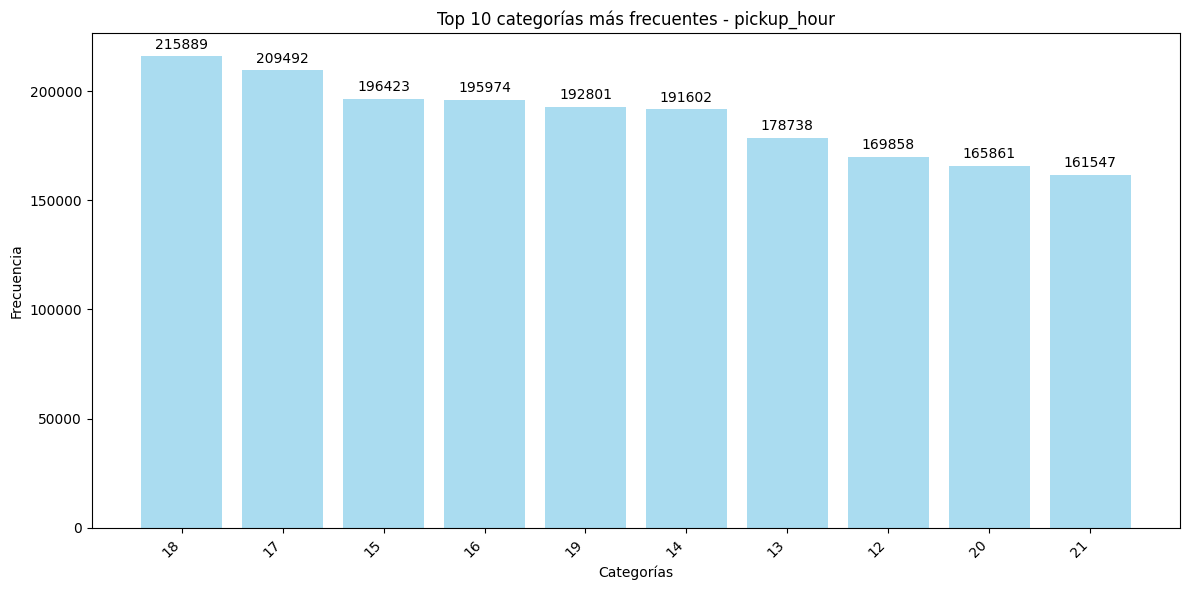

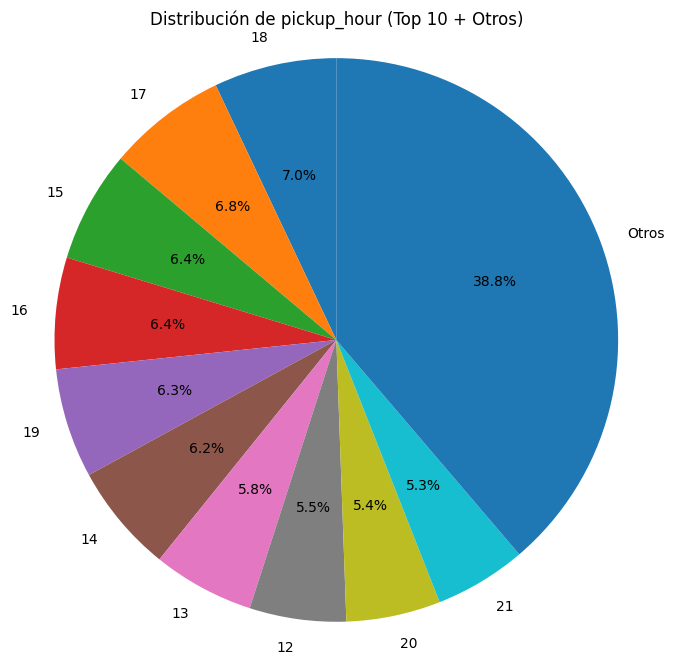

No hay datos para mostrar en el gráfico de evolución temporal.
No hay datos para mostrar en el gráfico de barras apiladas.
=============== Frecuencia de valores ===============
18: 215889
17: 209492
15: 196423
16: 195974
19: 192801
14: 191602
13: 178738
12: 169858
20: 165861
21: 161547
11: 154156
22: 147412
10: 143666
9: 131110
8: 116865
23: 114506
7: 86876
0: 84957
1: 59799
6: 43860
2: 42040
3: 27437
5: 18011
4: 17835
RESUMEN ESTADÍSTICO - pickup_hour
Total de registros: 3,066,715
Categorías únicas: 24
Categoría más frecuente: '18'  (215,889 veces,  7.0%)
Categoría menos frecuente: '4'  (17,835 veces,  0.6%)
Concentración 10 valores más repetidos:  61.2% de los datos
Período analizado: 2023-01-01 00:00:00  a 2023-01-31 23:59:59
Períodos de semana: 6


<Figure size 1400x800 with 0 Axes>

In [36]:
info = analyze_categorical_variable_spark(ds_filtered_outliers, col_name, col_fecha)

*5.1.2) Duración del trayecto*

trip_duration_minutes, permite medir eficiencia, velocidad y tiempo de servicio.

Los valores son minutos: no son válidos los valores a cero ni negativos. No tiene valores nulos.

Distribución muy sesgada, menos del 10% de valores extremos y sin relación temporal. 3 outliers muy por encima del resto.

In [37]:
ds_features = ds_filtered_outliers.withColumn(
    "trip_duration_minutes",
    (unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 60
)

ds_features.select(
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "trip_duration_minutes"
    ).show(5, truncate=False)

+--------------------+---------------------+---------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_duration_minutes|
+--------------------+---------------------+---------------------+
|2023-01-01 00:32:10 |2023-01-01 00:40:36  |8.433333333333334    |
|2023-01-01 00:55:08 |2023-01-01 01:01:27  |6.316666666666666    |
|2023-01-01 00:25:04 |2023-01-01 00:37:49  |12.75                |
|2023-01-01 00:03:48 |2023-01-01 00:13:25  |9.616666666666667    |
|2023-01-01 00:10:29 |2023-01-01 00:21:19  |10.833333333333334   |
+--------------------+---------------------+---------------------+
only showing top 5 rows



In [38]:
col_name = 'trip_duration_minutes'

show_column_spark(ds_features, col_name)

Tipo de dato: double
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+---------------------+-----+
|trip_duration_minutes|count|
+---------------------+-----+
|                  7.0| 3697|
|                  8.0| 3665|
|                  9.0| 3558|
|                  6.0| 3523|
|                 11.0| 3518|
|                 10.0| 3472|
|                  6.5| 3326|
|    6.333333333333333| 3281|
|    6.166666666666667| 3280|
|    7.233333333333333| 3279|
|                 7.85| 3267|
|                  7.4| 3264|
|                 12.0| 3263|
|    6.666666666666667| 3256|
|    6.833333333333333| 3254|
|    7.166666666666667| 3253|
|    7.516666666666667| 3249|
|    7.933333333333334| 3245|
|    6.766666666666667| 3243|
|    6.733333333333333| 3238|
+---------------------+-----+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 8,575
Valores a cero: 1,118 (0.04%)
Valores negativos: 3 (0.00%)
---------------


Estadísticas de trip_duration_minutes:
Media: 15.67
Desviación estándar: 42.54
Skewness: 35.268 (muy sesgada)
Outliers: 170,610 (5.6%)


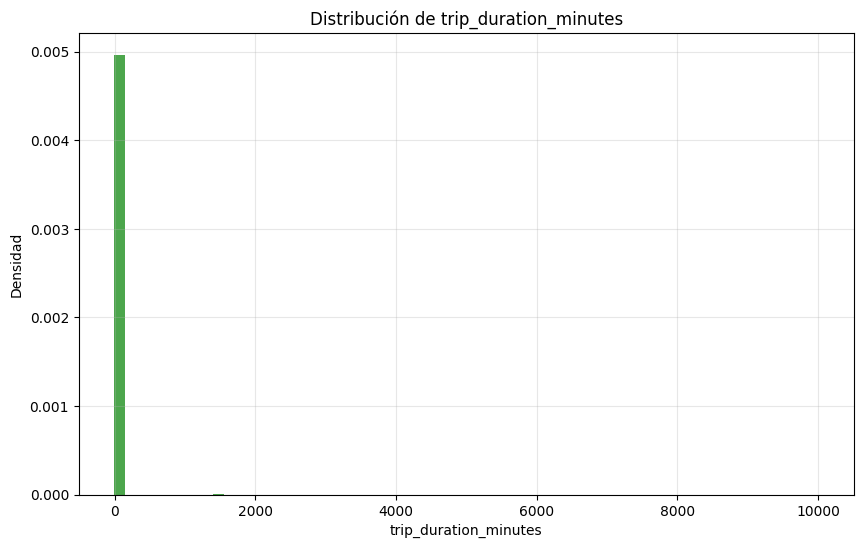

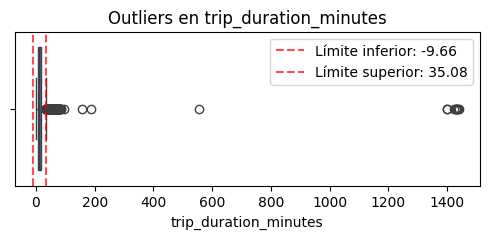

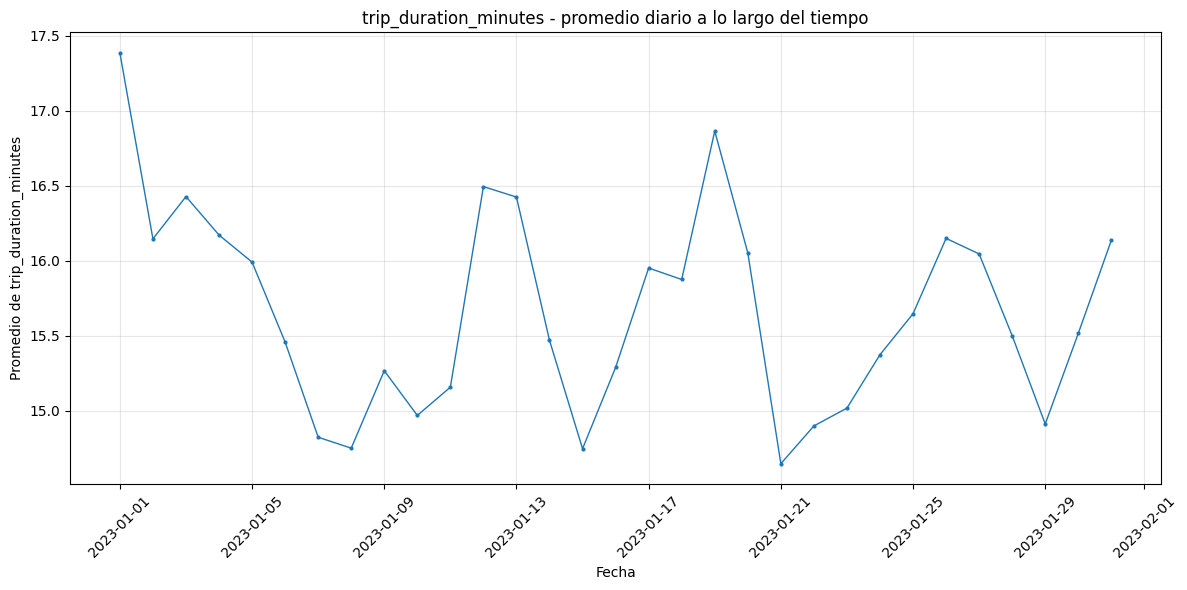

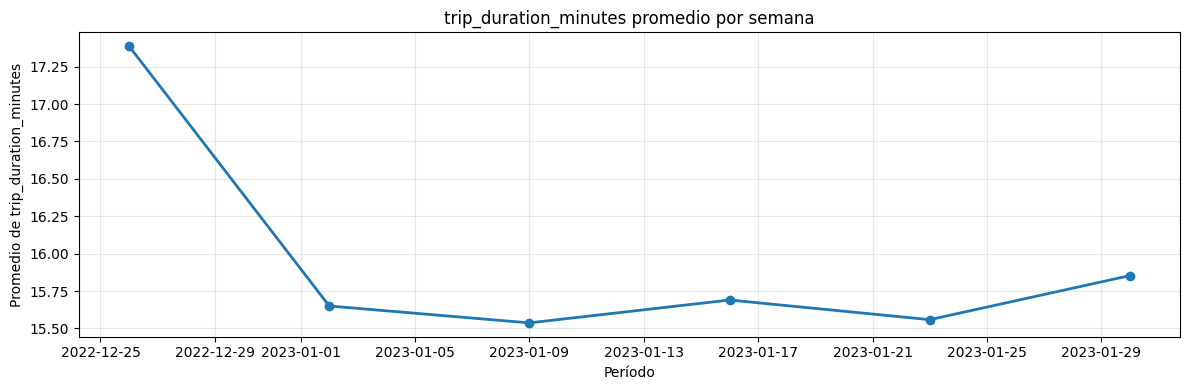

In [39]:
info = analyze_numeric_variable_spark(ds_features, col_name, col_fecha)

In [40]:
# limpia la memoria
if 'ds_filtered_outliers' in locals():
    ds_filtered_outliers.unpersist()

*5.1.3) Fin de semana*

is_weekend, indica si el trayecto ha sido o no en fin de semana y detectar con ello diferencias en la demanda y el comportamiento de los clientes en fines de semana.

Dos únicos valores (0 y 1, False y True), sin valores nulos ni extremos. La clase mayoritaria tiene más del 70% de los registros.

In [41]:
ds_features = ds_features.withColumn(
    "is_weekend",
    when(dayofweek(col("tpep_pickup_datetime")).isin([1, 7]), 1).otherwise(0)
)

# muestra los 5 primeros registros
ds_features.select(
    "is_weekend"
    ).show(5, truncate=False)

# muestra los 5 últimos registros
ds_features.orderBy(col("tpep_pickup_datetime").desc()).select("is_weekend").show(5, truncate=False)

+----------+
|is_weekend|
+----------+
|1         |
|1         |
|1         |
|1         |
|1         |
+----------+
only showing top 5 rows

+----------+
|is_weekend|
+----------+
|0         |
|0         |
|0         |
|0         |
|0         |
+----------+
only showing top 5 rows



In [42]:
col_name = 'is_weekend'

show_column_spark(ds_features, col_name)

Tipo de dato: int
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+----------+-------+
|is_weekend|  count|
+----------+-------+
|         0|2188651|
|         1| 878064|
+----------+-------+

--------------------------------------------------
Valores únicos: 2
Valores a cero: 2,188,651 (71.37%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+-------------------+
|summary|         is_weekend|
+-------+-------------------+
|  count|            3066715|
|   mean| 0.2863207047280233|
| stddev|0.45204117666869836|
|    min|                  0|
|    max|                  1|
+-------+-------------------+

--------------------------------------------------
Valores nulos: 0 (0.00%)
--------------------------------------------------


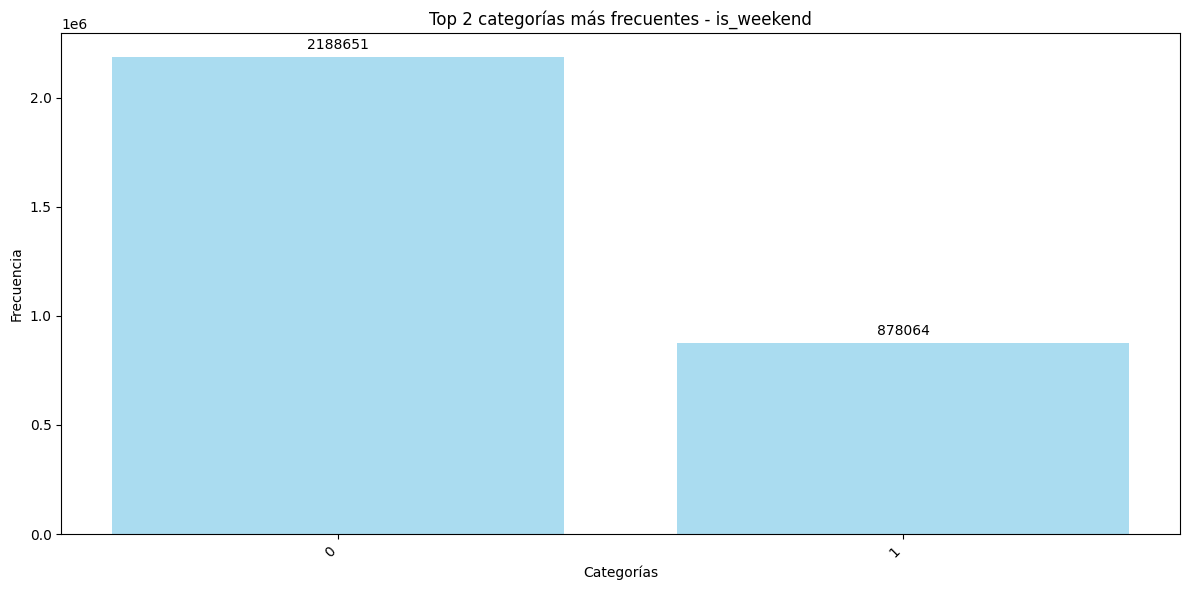

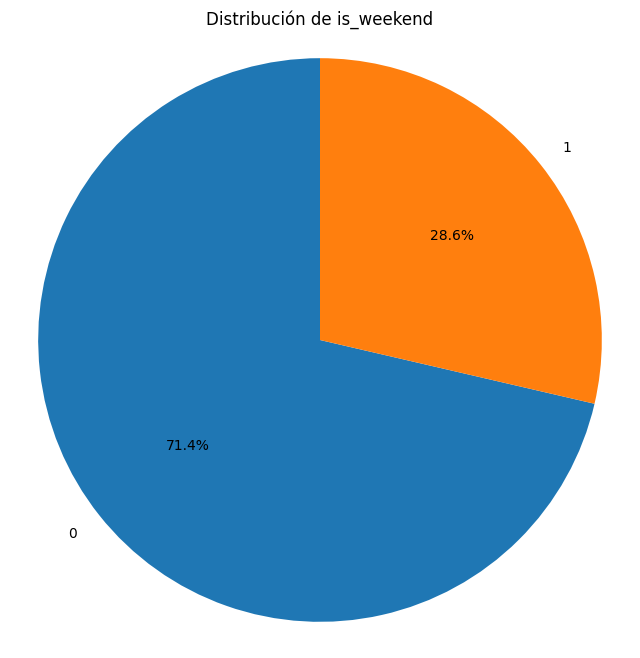

No hay datos para mostrar en el gráfico de evolución temporal.
No hay datos para mostrar en el gráfico de barras apiladas.
=============== Frecuencia de valores ===============
0: 2188651
1: 878064
RESUMEN ESTADÍSTICO - is_weekend
Total de registros: 3,066,715
Categorías únicas: 2
Categoría más frecuente: '0'  (2,188,651 veces,  71.4%)
Categoría menos frecuente: '1'  (878,064 veces,  28.6%)
Concentración 2 valores más repetidos:  100.0% de los datos
Período analizado: 2023-01-01 00:00:00  a 2023-01-31 23:59:59
Períodos de semana: 6


<Figure size 1400x800 with 0 Axes>

In [43]:
info = analyze_categorical_variable_spark(ds_features, col_name, col_fecha)

*5.1.4) Media de velocidad del trayecto*

average_speed_mph, indicador de estado del tráfico o de rutas anómalas. Cálculo en millas por hora.

Sin valores a cero ni negativos y menos del 1% de valores nulos. Distribución muy sesgada, con algo menos del 10% de outliers, y sin relación temporal. Algunos valores extremos muy elevados.

In [44]:
ds_features = ds_features.withColumn(
    "average_speed_mph",
    when(col("trip_duration_minutes") > 0,
         col("trip_distance_imputed") / (col("trip_duration_minutes") / 60))
    .otherwise(None)
)

ds_features.select(
    "trip_distance_imputed",
    "trip_duration_minutes",
    "average_speed_mph"
    ).show(5, truncate=False)

+---------------------+---------------------+------------------+
|trip_distance_imputed|trip_duration_minutes|average_speed_mph |
+---------------------+---------------------+------------------+
|0.97                 |8.433333333333334    |6.901185770750987 |
|1.1                  |6.316666666666666    |10.448548812664908|
|2.51                 |12.75                |11.811764705882352|
|1.9                  |9.616666666666667    |11.854419410745232|
|1.43                 |10.833333333333334   |7.92              |
+---------------------+---------------------+------------------+
only showing top 5 rows



In [45]:
col_name = 'average_speed_mph'

show_column_spark(ds_features, col_name)

Tipo de dato: double
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+------------------+-----+
| average_speed_mph|count|
+------------------+-----+
|               9.0| 4618|
|              12.0| 3401|
|               8.0| 2726|
|10.285714285714286| 2487|
|               7.2| 1922|
| 9.818181818181818| 1693|
|               7.5| 1621|
|              10.0| 1599|
|10.588235294117647| 1581|
|              18.0| 1568|
| 8.470588235294118| 1555|
|               6.0| 1522|
| 8.571428571428571| 1522|
| 8.181818181818182| 1512|
|  9.72972972972973| 1447|
|             11.25| 1437|
|  8.78048780487805| 1429|
|10.285714285714285| 1361|
|12.857142857142858| 1341|
|               9.6| 1328|
+------------------+-----+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 629,269
Valores a cero: 0 (0.00%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+--


Estadísticas de average_speed_mph:
Media: 20.65
Desviación estándar: 2153.94
Skewness: 865.971 (muy sesgada)
Outliers: 254,980 (8.3%)


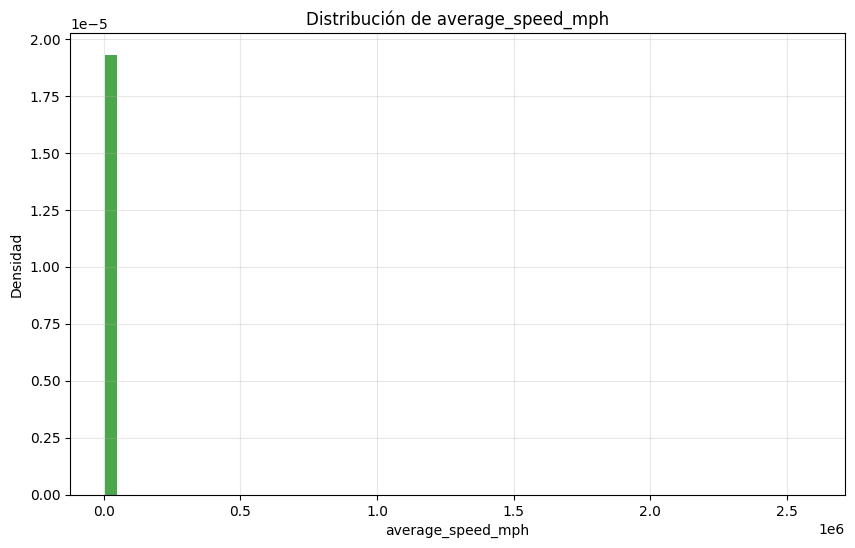

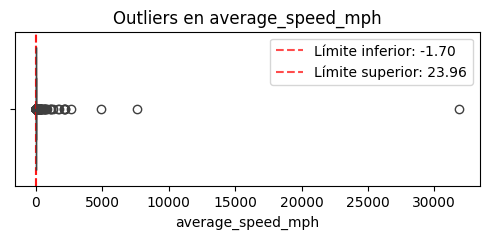

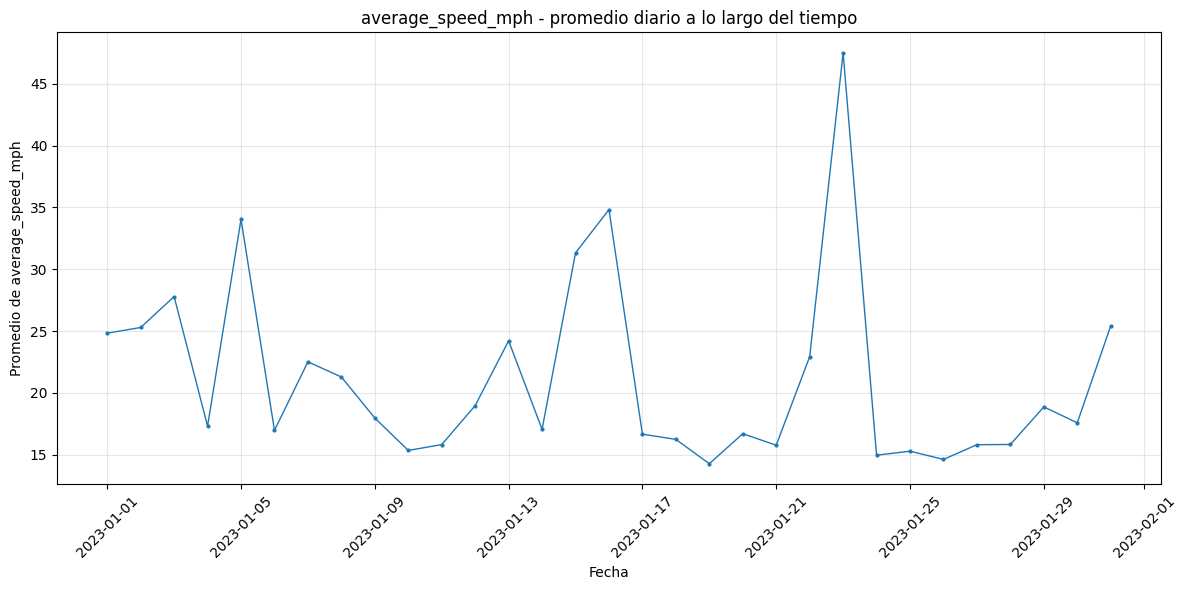

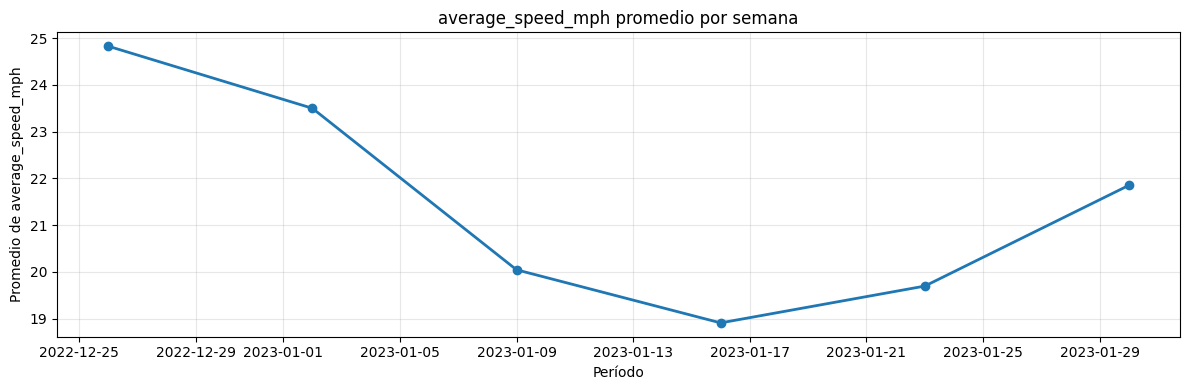

In [46]:
info = analyze_numeric_variable_spark(ds_features, col_name, col_fecha)

*5.1.5) Porcentaje de la propina sobre el importe total*

tip_percentage, indicador de satisfacción o generosidad del pasajero.

Sin valores negativos ni nulos, los valores a cero son válidos. Distribución muy sesgada, con menos del 1% de valores extremos y sin relación temporal. Algunos outliers muy elevados.

In [47]:
ds_features = ds_features.withColumn(
    "tip_percentage",
    when((col("total_amount_imputed") - col("tip_amount_imputed")) > 0,
         (col("tip_amount_imputed") / (col("total_amount_imputed") - col("tip_amount_imputed"))) * 100)
    .otherwise(0)
)

ds_features.select(
    "total_amount_imputed",
    "tip_amount_imputed",
    "tip_percentage"
    ).show(5, truncate=False)

+--------------------+------------------+-----------------+
|total_amount_imputed|tip_amount_imputed|tip_percentage   |
+--------------------+------------------+-----------------+
|14.3                |0.0               |0.0              |
|16.9                |4.0               |31.0077519379845 |
|34.9                |15.0              |75.37688442211056|
|20.85               |0.0               |0.0              |
|19.68               |3.28              |20.0             |
+--------------------+------------------+-----------------+
only showing top 5 rows



In [48]:
col_name = 'tip_percentage'

show_column_spark(ds_features, col_name)

Tipo de dato: double
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+------------------+------+
|    tip_percentage| count|
+------------------+------+
|              20.0|945473|
|               0.0|694925|
|              25.0| 91308|
|20.000000000000004| 56324|
|              10.0| 48555|
|              30.0| 38723|
|              15.0| 33649|
|30.000000000000004| 17456|
|19.841269841269842| 14045|
|19.999999999999996| 12279|
| 19.69437652811736| 10232|
|19.924812030075188|  9689|
|19.897959183673468|  9307|
|14.285714285714285|  9232|
|15.000000000000002|  9211|
| 8.928571428571429|  8059|
|29.999999999999993|  8052|
| 9.523809523809524|  7211|
|19.747899159663866|  7104|
|19.875776397515526|  6990|
+------------------+------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 49,330
Valores a cero: 694,925 (22.66%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadíst


Estadísticas de tip_percentage:
Media: 14.40
Desviación estándar: 17.82
Skewness: 283.931 (muy sesgada)
Outliers: 9,376 (0.3%)


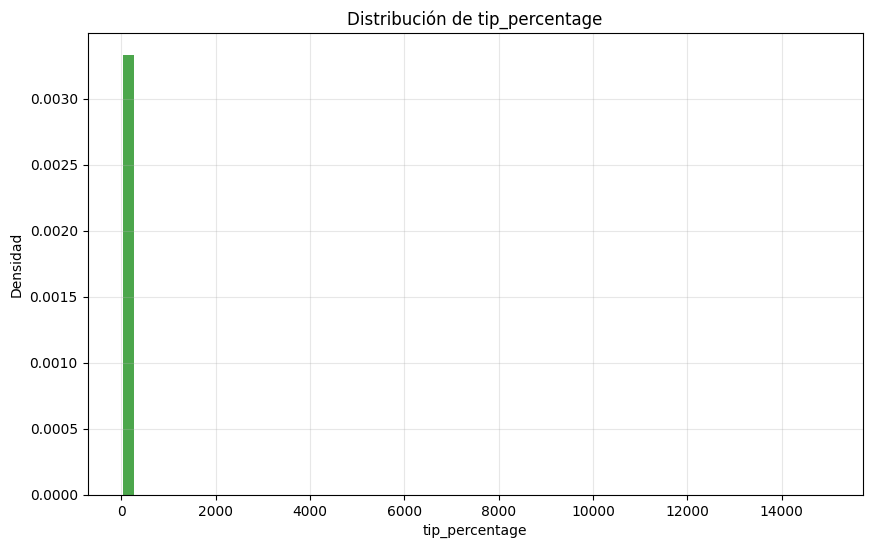

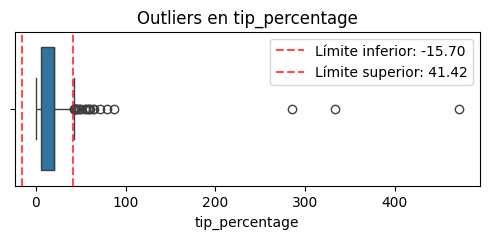

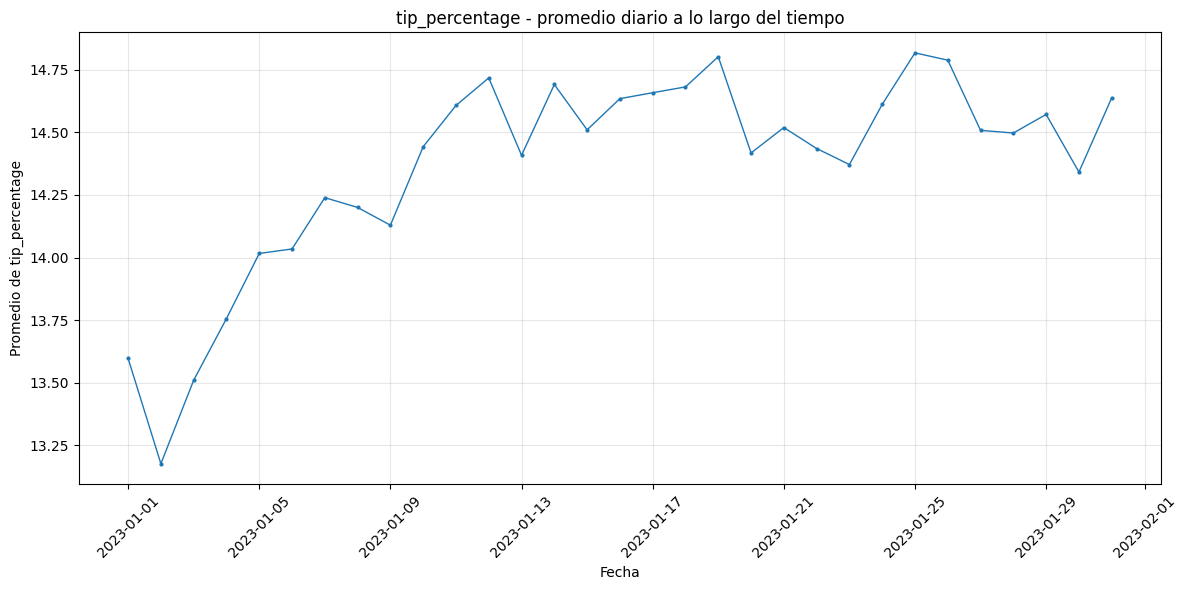

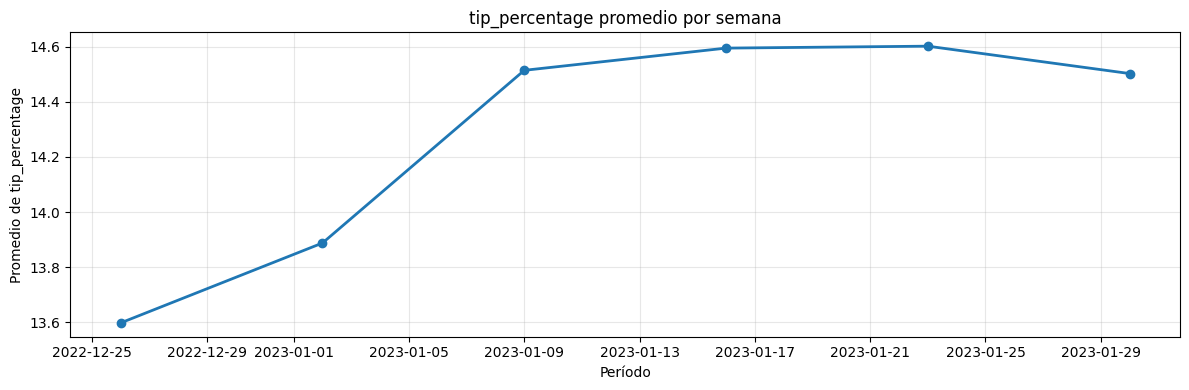

In [49]:
info = analyze_numeric_variable_spark(ds_features, col_name, col_fecha)

*5.1.6) Importe base de la tarifa por milla*

fare_per_mile, puede ser útil para detectar variaciones de tarifa o rutas poco eficientes.

Sin valores a cero, negativos ni nulos. Distribución muy sesgada, con casi el 5% de valores extremos y sin relación temporal. Algunos outliers muy elevados.

In [50]:
ds_features = ds_features.withColumn(
    "fare_per_mile",
    when(col("trip_distance_imputed") > 0,
         col("fare_amount_imputed") / col("trip_distance_imputed"))
    .otherwise(None)
)

ds_features.select(
    "fare_amount_imputed",
    "trip_distance_imputed",
    "fare_per_mile"
    ).show(5, truncate=False)

+-------------------+---------------------+------------------+
|fare_amount_imputed|trip_distance_imputed|fare_per_mile     |
+-------------------+---------------------+------------------+
|9.3                |0.97                 |9.587628865979383 |
|7.9                |1.1                  |7.181818181818182 |
|14.9               |2.51                 |5.936254980079682 |
|12.1               |1.9                  |6.368421052631579 |
|11.4               |1.43                 |7.9720279720279725|
+-------------------+---------------------+------------------+
only showing top 5 rows



In [51]:
col_name = 'fare_per_mile'

show_column_spark(ds_features, col_name)

Tipo de dato: double
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+------------------+-----+
|     fare_per_mile|count|
+------------------+-----+
|              10.0|16487|
|               8.0|16131|
|               9.0|12183|
| 9.285714285714286|10987|
|             8.125|10896|
| 9.666666666666666|10587|
| 6.666666666666667|10235|
|               7.9|10132|
| 8.777777777777779| 9224|
|7.8181818181818175| 8974|
| 7.181818181818182| 8848|
|               7.2| 8719|
| 8.285714285714286| 8688|
| 7.166666666666667| 8630|
| 7.142857142857143| 8022|
|              10.2| 7989|
| 7.153846153846154| 7974|
| 8.333333333333334| 7970|
|               8.6| 7966|
|10.833333333333334| 7965|
+------------------+-----+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 113,813
Valores a cero: 0 (0.00%)
Valores negativos: 0 (0.00%)
--------------------------------------------------
Estadísticas descriptivas:
+-------+--


Estadísticas de fare_per_mile:
Media: 11.13
Desviación estándar: 128.20
Skewness: 68.431 (muy sesgada)
Outliers: 130,783 (4.3%)


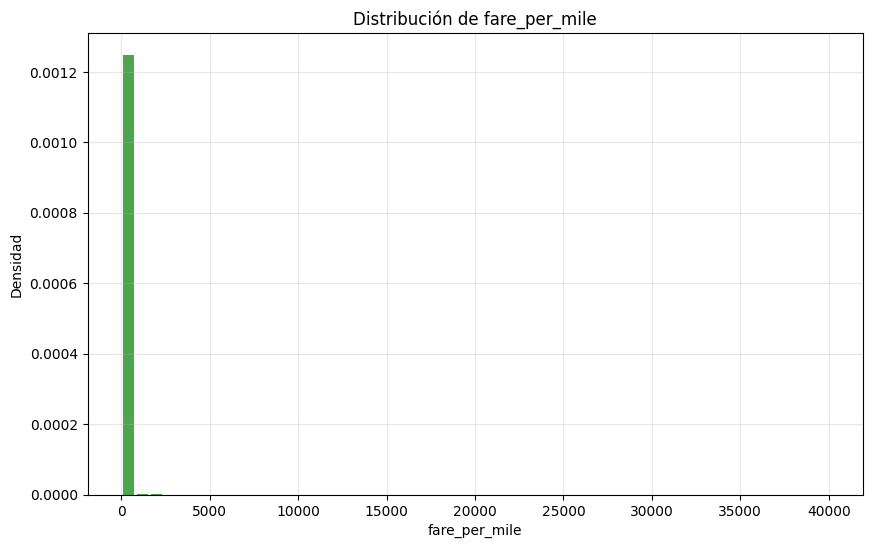

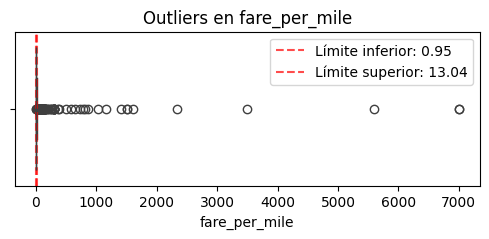

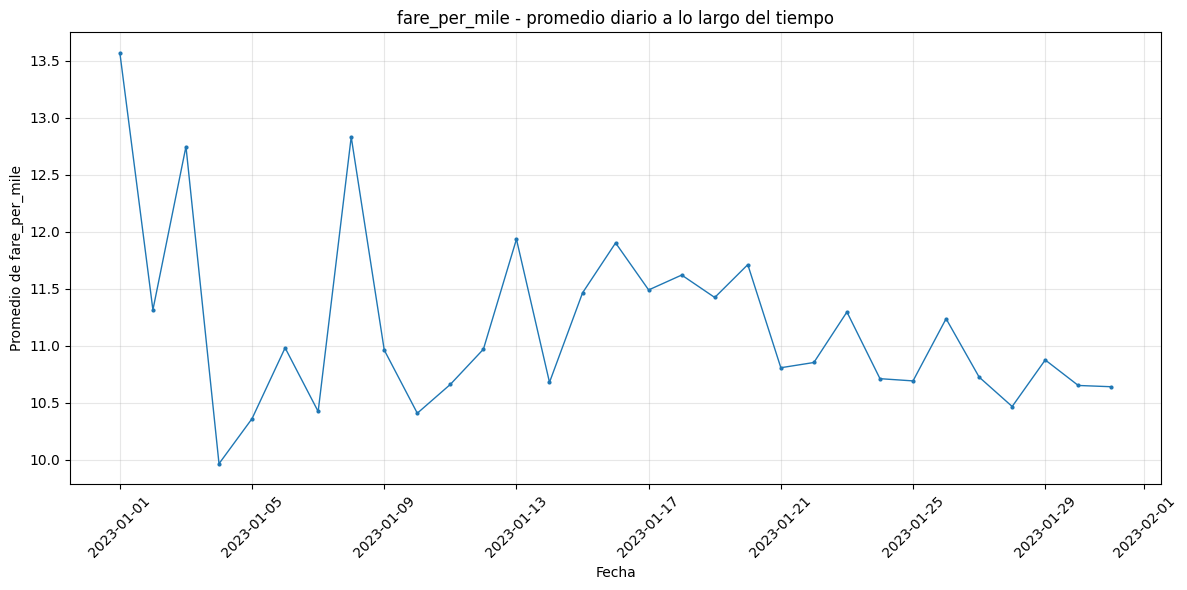

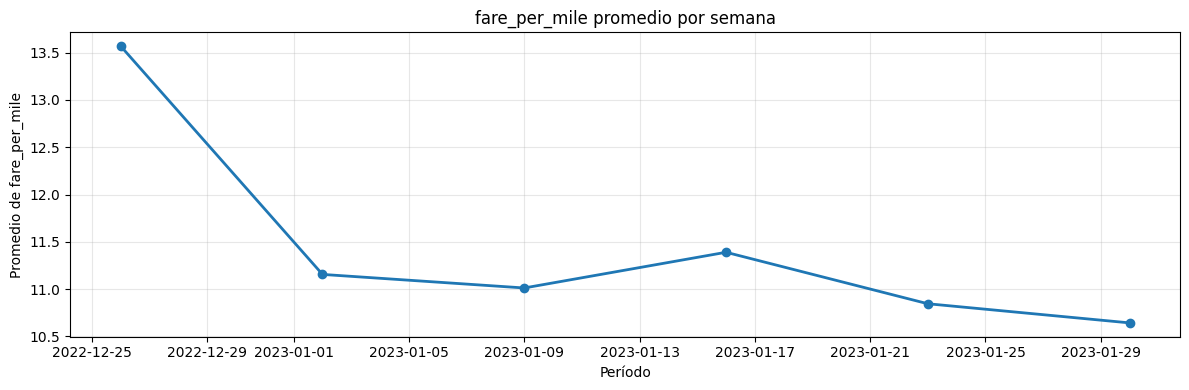

In [52]:
info = analyze_numeric_variable_spark(ds_features, col_name, col_fecha)

*5.1.7) Porcentaje de cargos adicionales*

proportion_extra_charges, permite estudiar por separado los cargos adicionales frente a la tarifa base.

Sin valores negativos, a cero ni nulos. Distribución muy sesgada, con menos del 5% de valores extremos y con una relación temporal muy débil. Algunos outliers muy elevados.

In [53]:
ds_features = ds_features.withColumn(
    "extra_charges",
    col("extra_imputed") + col("mta_tax_imputed") + col("tolls_amount_imputed") +
    col("improvement_surcharge_imputed") + col("congestion_surcharge_imputed_v2") +
    col("airport_fee_imputed_v2")
).withColumn(
    "proportion_extra_charges",
    when(col("total_amount_imputed") > 0, col("extra_charges") / col("total_amount_imputed")).otherwise(0)
)

ds_features.select(
    "extra_charges",
    "proportion_extra_charges"
    ).show(5, truncate=False)

+-------------+------------------------+
|extra_charges|proportion_extra_charges|
+-------------+------------------------+
|5.0          |0.34965034965034963     |
|5.0          |0.2958579881656805      |
|5.0          |0.14326647564469916     |
|10.0         |0.4796163069544364      |
|5.0          |0.2540650406504065      |
+-------------+------------------------+
only showing top 5 rows



In [54]:
col_name = 'proportion_extra_charges'

show_column_spark(ds_features, col_name)

Tipo de dato: double
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+------------------------+-----+
|proportion_extra_charges|count|
+------------------------+-----+
|     0.23809523809523808|35717|
|     0.31746031746031744|31815|
|     0.19047619047619047|26358|
|      0.2645502645502646|25160|
|      0.2506265664160401|25036|
|     0.21645021645021645|23703|
|      0.2801120448179272|23649|
|     0.22675736961451246|23605|
|      0.2976190476190476|23286|
|     0.20703933747412007|22701|
|      0.1984126984126984|19853|
|     0.18315018315018314|17842|
|     0.35714285714285715|17405|
|      0.2857142857142857|17225|
|      0.2777777777777778|15984|
|      0.1763668430335097|15060|
|      0.3401360544217687|14197|
|     0.17006802721088435|13918|
|     0.38690476190476186|13817|
|      0.5158730158730159|13789|
+------------------------+-----+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 62,771
V


Estadísticas de proportion_extra_charges:
Media: 0.27
Desviación estándar: 0.14
Skewness: 56.703 (muy sesgada)
Outliers: 65,929 (2.1%)


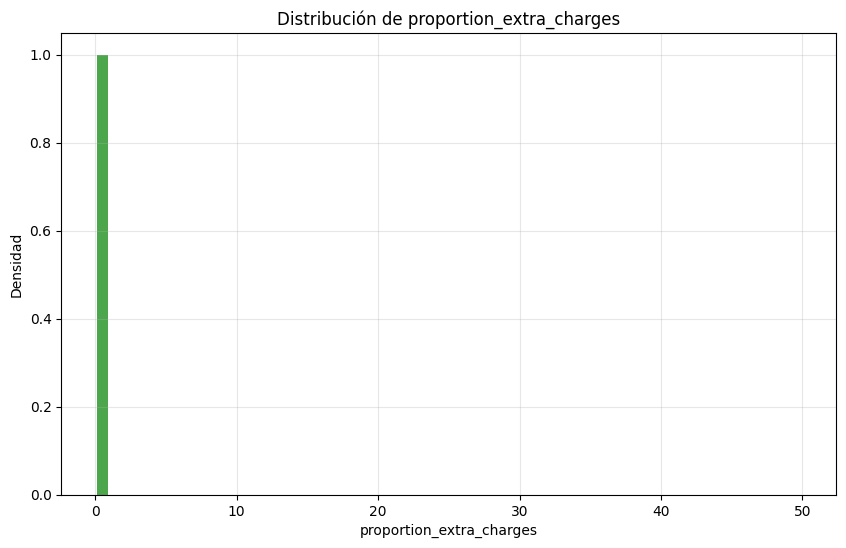

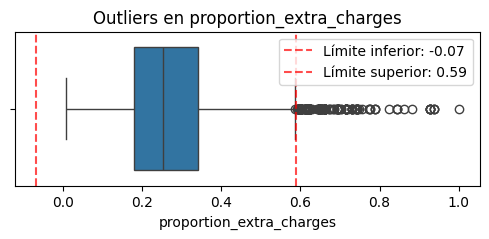

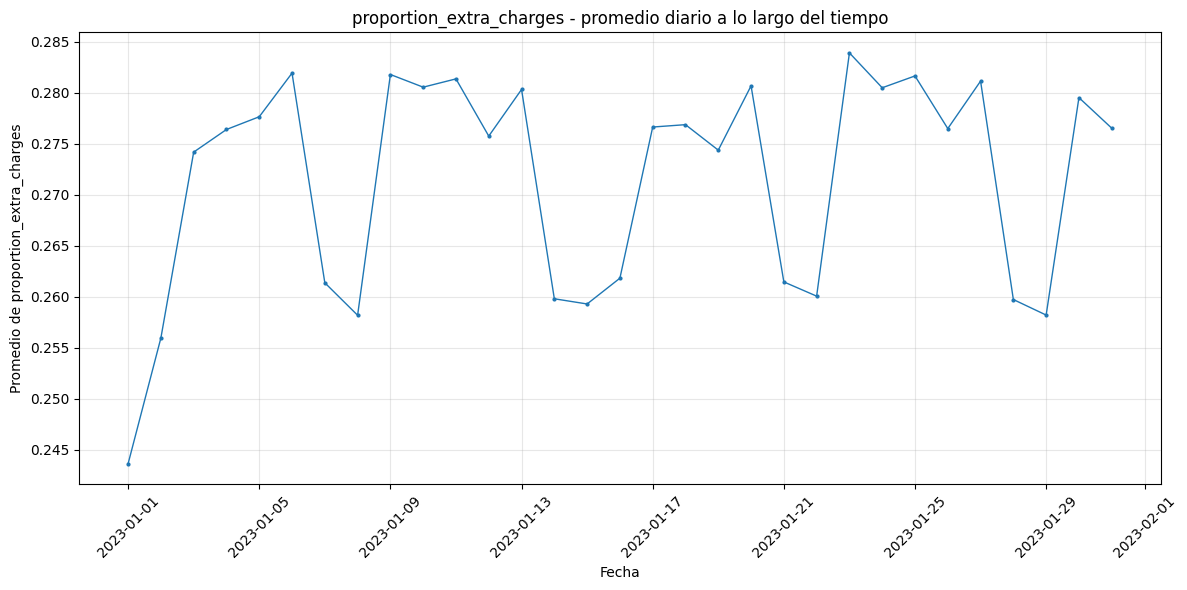

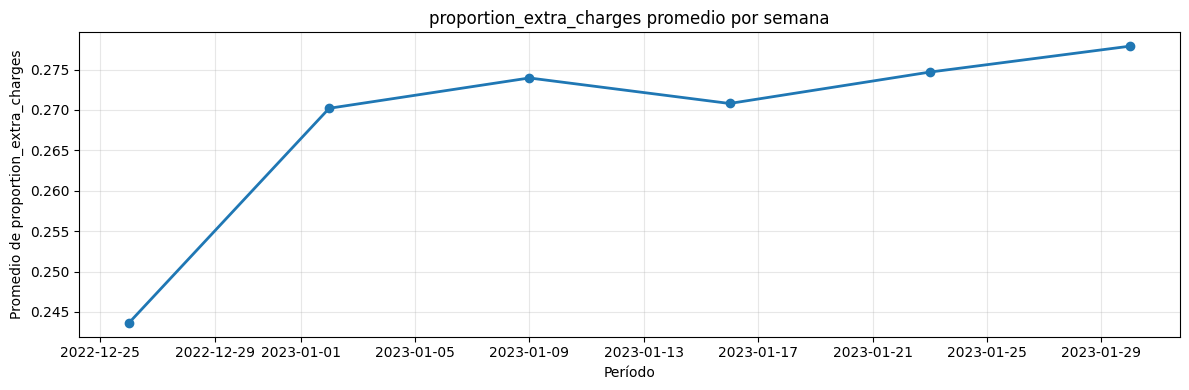

In [55]:
info = analyze_numeric_variable_spark(ds_features, col_name, col_fecha)

**5.2) Valores a cero y negativos de las nuevas variables**

Sólo trip_duration_minutes presenta valores a cero y negativos no válidos.

Vamos a ver si existe relación temporal en su mediana.

In [56]:
col_name = "trip_duration_minutes"

columnas = [col_name]

analyze_median_hourly_variation(ds_features, columnas)

Variación de la mediana de 'trip_duration_minutes':
+-----------------+-----------+------------------+-----------------+------------------------------+
|      mediana_min|mediana_max|  mediana_promedio|  rango_variacion|factor_variacion_tanto_por_uno|
+-----------------+-----------+------------------+-----------------+------------------------------+
|9.383333333333333|       12.5|11.229861111111111|3.116666666666667|           0.27753385690433496|
+-----------------+-----------+------------------+-----------------+------------------------------+



Tenemos una variación temporal cercana al 30%. Vamos por tanto a imputar estos valores a cero y negativos con la mediana teniendo en cuenta el grupo de zona de origen, zona de destino y hora de inicio del viaje.

In [57]:
# zona de origen, zona de destino y hora de inicio del viaje
claves_agrupacion = ["PULocationID", "DOLocationID", "pickup_hour"]

valores_a_imputar = "ambos"

ds_features_imputed = impute_columns_with_median(ds_features, columnas, claves_agrupacion, valores_a_imputar)


Imputación de trip_duration_minutes
Registros con trip_duration_minutes a imputar (ambos): 1121
Imputaciones realizadas: 1121
Imputaciones usando mediana global: 72
Tasa de éxito: 100.00%


In [58]:
# comprobación
columnas = [col_name, f"{col_name}_imputed"]

counting_columns_values(ds_features_imputed, columnas, contar_zeros=True, contar_negativos=True)

Variable 'trip_duration_minutes':
   Valores a cero: 1,118 (0.04%)
   Valores negativos: 3 (0.00%)
Variable 'trip_duration_minutes_imputed':
   Valores a cero: 0 (0.00%)
   Valores negativos: 0 (0.00%)


In [59]:
# limpia la memoria
if 'ds_features' in locals():
    ds_features.unpersist()

**5.3) Valores nulos de las nuevas variables**

average_speed_mph es la única variable que presenta valores nulos.

Vamos a estudiar la variación de la mediana con la hora.

In [60]:
columnas_a_imputar = [
    "average_speed_mph"
]

analyze_median_hourly_variation(ds_features_imputed, columnas_a_imputar)

Variación de la mediana de 'average_speed_mph':
+-----------------+------------------+-----------------+-----------------+------------------------------+
|      mediana_min|       mediana_max| mediana_promedio|  rango_variacion|factor_variacion_tanto_por_uno|
+-----------------+------------------+-----------------+-----------------+------------------------------+
|8.979591836734695|17.687344913151364|11.61299083168817|8.707753076416669|            0.7498286361043162|
+-----------------+------------------+-----------------+-----------------+------------------------------+



Casi un 75% de variación con la hora.

In [61]:
# zona de origen, zona de destino y hora de inicio del viaje
claves_agrupacion = ["PULocationID", "DOLocationID", "pickup_hour"]

valores_a_imputar = "nulos"

ds_features_imputed = impute_columns_with_median(
    ds_features_imputed, columnas_a_imputar, claves_agrupacion, valores_a_imputar
)


Imputación de average_speed_mph
Registros con average_speed_mph a imputar (nulos): 1121
Imputaciones realizadas: 1121
Imputaciones usando mediana global: 72
Tasa de éxito: 100.00%


In [62]:
# comprobación
col_name = "average_speed_mph"

columnas = [col_name, f"{col_name}_imputed"]

counting_columns_values(ds_features_imputed, columnas, contar_nulos=True)

Variable 'average_speed_mph':
   Valores nulos: 1,121 (0.04%)
Variable 'average_speed_mph_imputed':
   Valores nulos: 0 (0.00%)


**5.4) Valores extremos de las nuevas variables**

Tenemos valores extremos en las variables:

- trip_duration_minutes
- average_speed_mph
- tip_percentage
- fare_per_mile
- proportion_extra_charges

En todos los casos hay valores muy por encima del resto. Vamos a estudiar cada una de estas variables.

*5.4.1) trip_duration_minutes*

Casi un 6% de outliers, con duración de trayecto de hasta 10.000 minutos (casi 7 días), lógicamente hay valores erróneos en esta variable.

Columna: trip_duration_minutes_imputed
Q1: 7.08, Q3: 18.07, IQR: 10.98
Límite superior (IQR): 34.54

Número de outliers: 177,770 (5.80%)

Percentiles de outliers:
P95: 35.38
P99: 10029.18
P99.5: 10029.18
P99.9: 10029.18

Top valores más frecuentes entre outliers:
+-----------------------------+-----+
|trip_duration_minutes_imputed|count|
+-----------------------------+-----+
|35.0                         |306  |
|36.0                         |286  |
|37.0                         |249  |
|34.71666666666667            |247  |
|35.21666666666667            |243  |
|34.81666666666667            |240  |
|34.8                         |238  |
|35.333333333333336           |237  |
|35.166666666666664           |236  |
|34.88333333333333            |236  |
+-----------------------------+-----+


Generando histograma (recortado al P99)...
Registros para histograma: 3,066,715
Dataset grande, procesando en tramos...


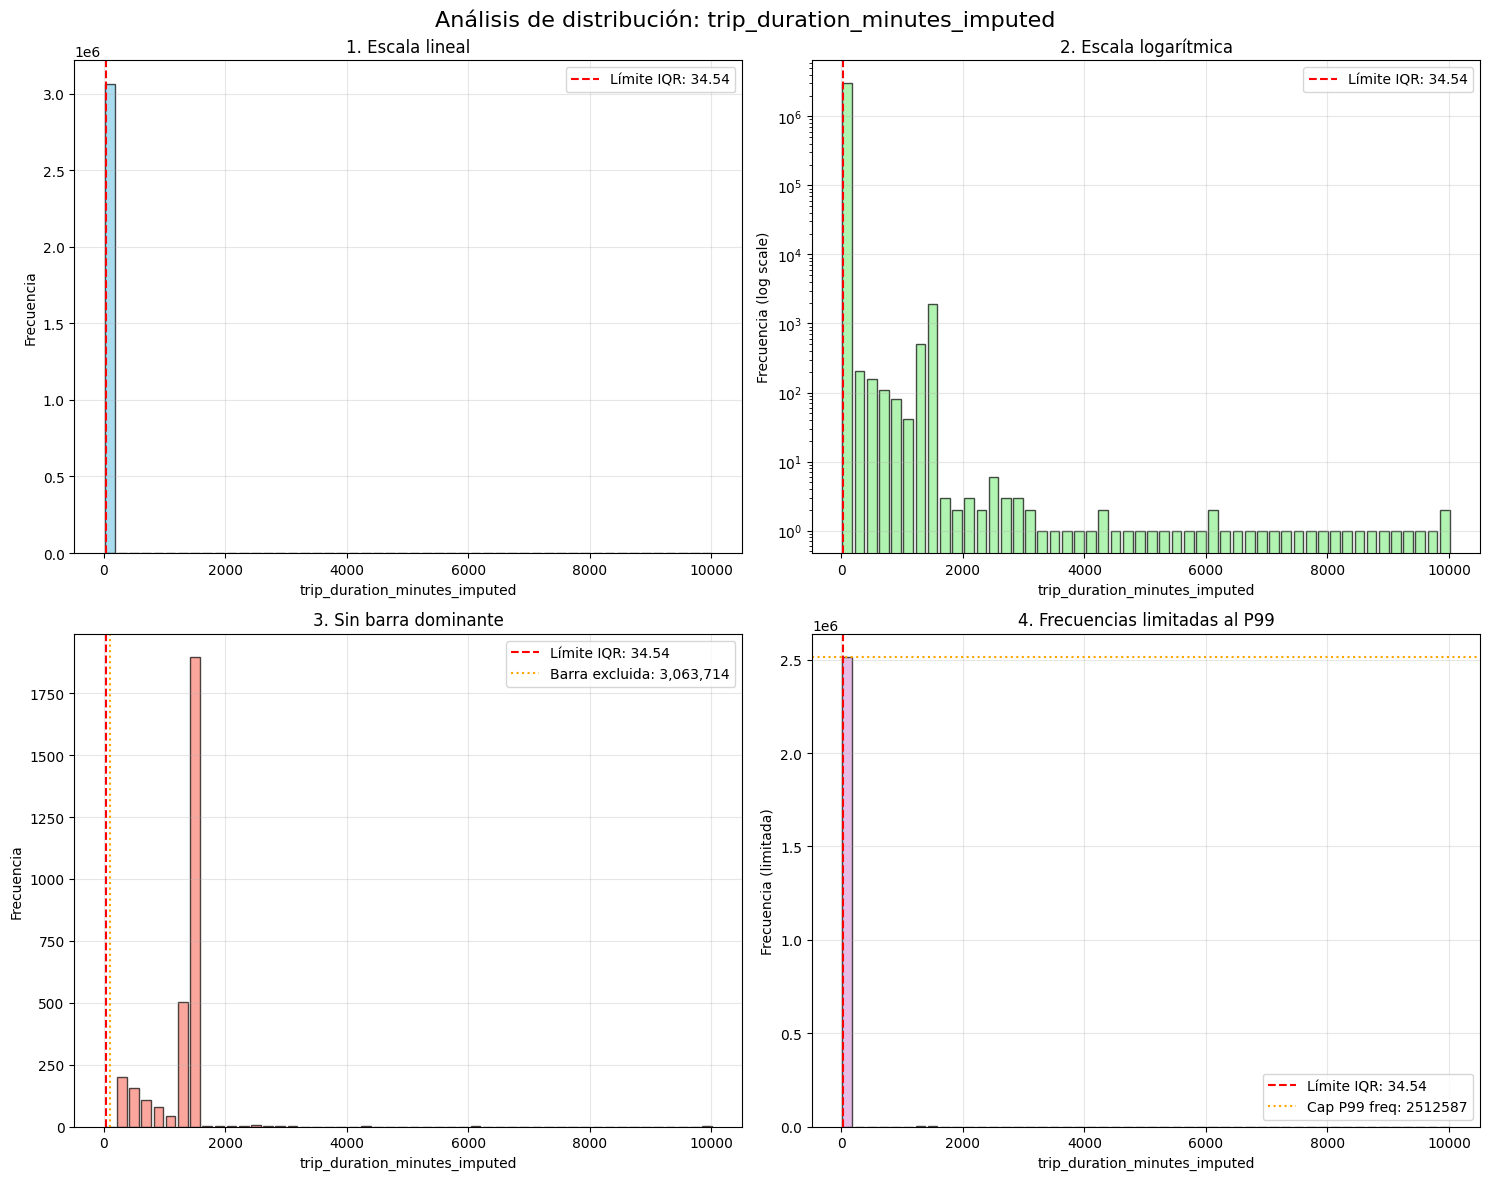


📉 Análisis de caída en histograma:
• Índice del bin con mayor caída: 15
• Frecuencia antes: 1, después: 0
• Caída relativa: -1.00
• Intervalo de caída: 3008.77 - 3209.35
• Centro del bin: 3109.06

📊 Análisis de la distribución:
• Barra más alta: 3,063,714 registros (99.9%) en valor ~100.31
• Total de registros: 3,066,715
• Ratio máx/mín frecuencia: 3063714.0:1
• Bins con datos: 19/50
• Frecuencia capada al P99: 2512587

Estadísticas del histograma:
Registros procesados: 3,066,715
Valor mínimo: 0.02
Valor máximo: 10029.18
Media: 15.67


In [63]:
col_name = "trip_duration_minutes_imputed"

outliers_trip_duration = show_outliers_iqr(ds_features_imputed, col_name)

- Outliers extremos: a partir de 3.109,06 minutos (caída global del dataset)

- Outliers moderados: entre 35,25 y esos 3.109,06 minutos

- Percentil 95: 37.17

- Percentil 99: 10029.18

Vamos a estudiar los percentiles entre 95 y 99, donde se produce el salto principal.

In [64]:
pmin = 0.95
pmax = 0.99

granular_percentile_analysis(ds_features_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE trip_duration_minutes_imputed

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 52.17 → 10029.18
   Multiplicador: 192.3x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:        52.17
   P 98.3%:        52.17
   P 98.4%:        52.17
   P 98.5%:        52.17
   P 98.6%:        52.17
   P 98.7%:        52.17
   P 98.8%:        52.17
   P 98.9%:        52.17
   P 99.0%:     10029.18 ← SALTO MÁXIMO
   P 99.1%:     10029.18
   P 99.2%:     10029.18
   P 99.3%:     10029.18
   P 99.4%:     10029.18
   P 99.5%:     10029.18
   P 99.6%:     10029.18
   P 99.7%:     10029.18


Dado que trip_duration_minutes no es una variable original del dataset, sino una nueva variable que ha sido añadida después de limpiar los datos originales, no considero que sea conveniente eliminar registros con outliers en esta variable, ni siquiera los extremos.

Por tanto, vamos a imputar los outliers superiores a 55,20 minutos (antes del mayor salto global) por la mediana agrupada por zona y en su caso hora.

*5.4.2) average_speed_mph*

Columna: average_speed_mph_imputed
Q1: 7.89, Q3: 14.14, IQR: 6.25
Límite superior (IQR): 23.52

Número de outliers: 267,144 (8.71%)

Percentiles de outliers:
P95: 28.24
P99: 2589281.50
P99.5: 2589281.50
P99.9: 2589281.50

Top valores más frecuentes entre outliers:
+-------------------------+-----+
|average_speed_mph_imputed|count|
+-------------------------+-----+
|24.0                     |412  |
|36.0                     |313  |
|540.0                    |238  |
|270.0                    |202  |
|240.0                    |193  |
|25.714285714285715       |187  |
|1080.0                   |176  |
|359.99999999999994       |151  |
|30.0                     |148  |
|2160.0                   |145  |
+-------------------------+-----+


Generando histograma (recortado al P99)...
Registros para histograma: 3,066,715
Dataset grande, procesando en tramos...


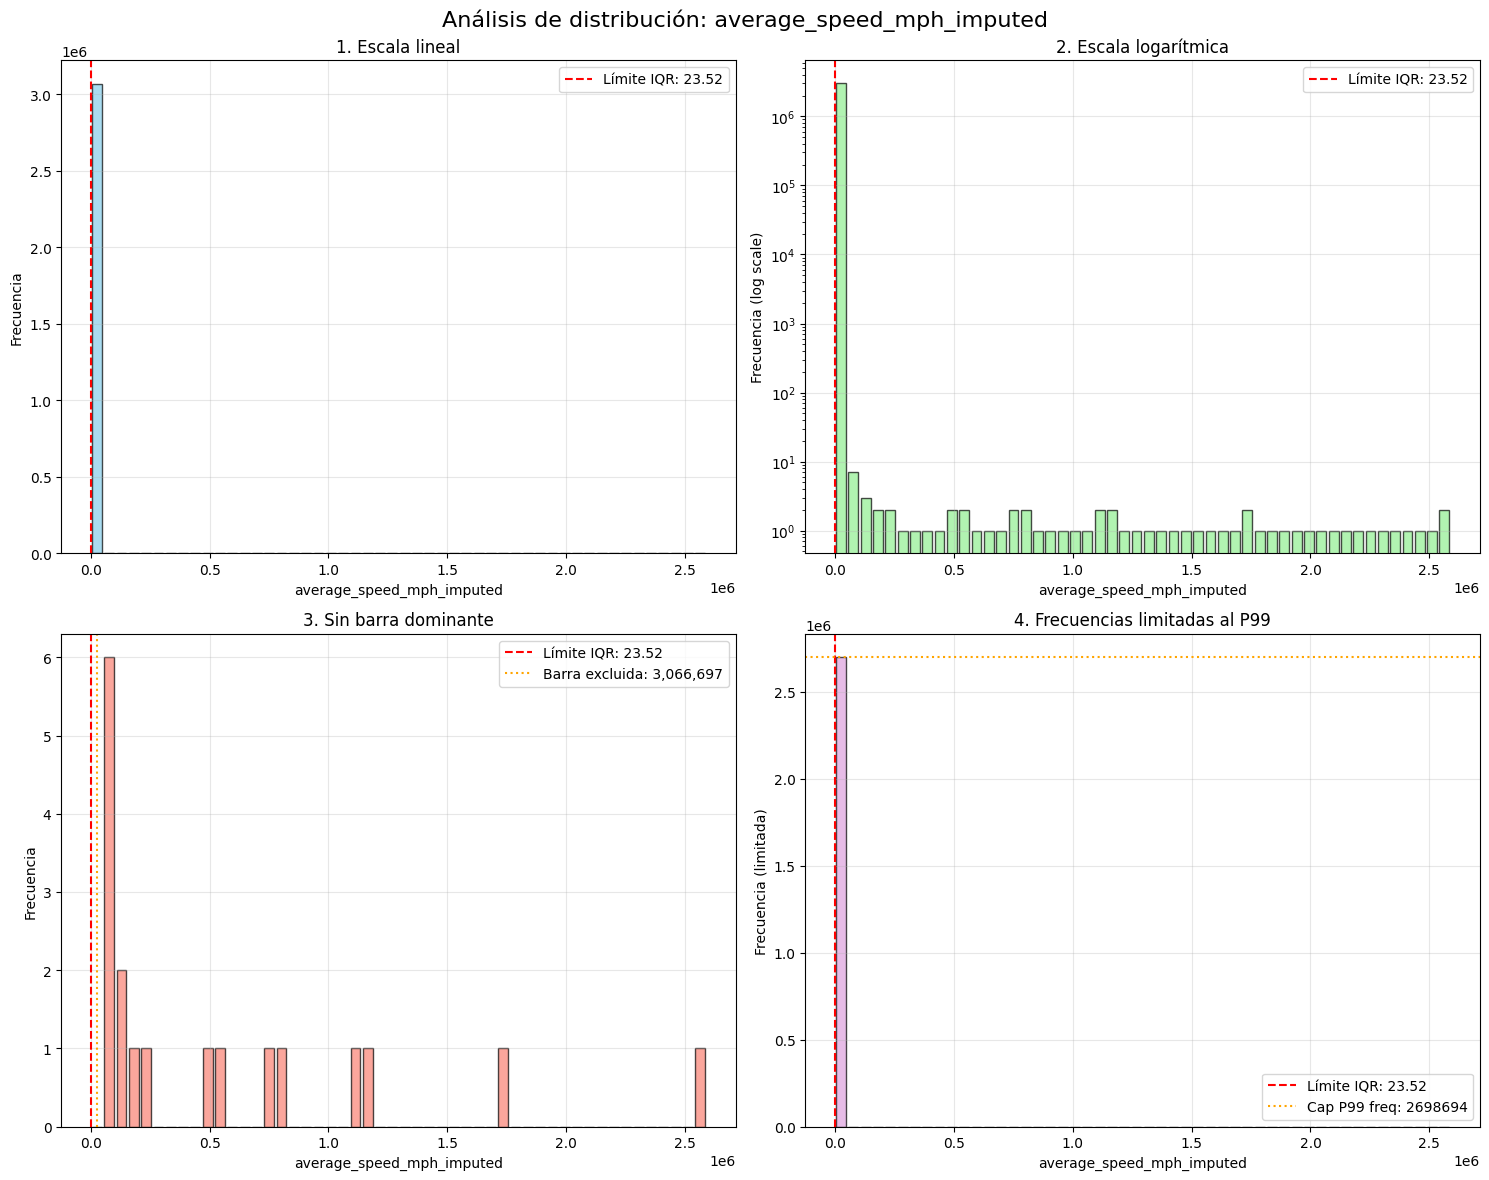


📉 Análisis de caída en histograma:
• Índice del bin con mayor caída: 4
• Frecuencia antes: 1, después: 0
• Caída relativa: -1.00
• Intervalo de caída: 207142.52 - 258928.15
• Centro del bin: 233035.34

📊 Análisis de la distribución:
• Barra más alta: 3,066,697 registros (100.0%) en valor ~25892.82
• Total de registros: 3,066,715
• Ratio máx/mín frecuencia: 3066697.0:1
• Bins con datos: 13/50
• Frecuencia capada al P99: 2698694

Estadísticas del histograma:
Registros procesados: 3,066,715
Valor mínimo: 0.00
Valor máximo: 2589281.50
Media: 20.66


In [65]:
col_name = "average_speed_mph_imputed"

outliers_trip_duration = show_outliers_iqr(ds_features_imputed, col_name)

- Outliers extremos: a partir de 233.035,34 mph

- Outliers moderados: a partir de 23,60 mph

- Percentil 95: 27,33 mph

Vamos a estudiar los percentiles entre 95 y 99.

In [66]:
pmin = 0.95
pmax = 0.99

granular_percentile_analysis(ds_features_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE average_speed_mph_imputed

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 39.14 → 2589281.50
   Multiplicador: 66153.0x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:        35.54
   P 98.3%:        35.54
   P 98.4%:        35.54
   P 98.5%:        35.54
   P 98.6%:        35.54
   P 98.7%:        35.54
   P 98.8%:        39.14
   P 98.9%:        39.14
   P 99.0%:   2589281.50 ← SALTO MÁXIMO
   P 99.1%:   2589281.50
   P 99.2%:   2589281.50
   P 99.3%:   2589281.50
   P 99.4%:   2589281.50
   P 99.5%:   2589281.50
   P 99.6%:   2589281.50
   P 99.7%:   2589281.50


Como con trip_duration_minutes, vamos a imputar los outliers de average_speed_mph a partir de 41,30 mph.

*5.4.3) tip_percentage*

Columna: tip_percentage
Q1: 5.04, Q3: 20.00, IQR: 14.96
Límite superior (IQR): 42.44

Número de outliers: 8,869 (0.29%)

Percentiles de outliers:
P95: 25.03
P99: 15000.00
P99.5: 15000.00
P99.9: 15000.00

Top valores más frecuentes entre outliers:
+------------------+-----+
|tip_percentage    |count|
+------------------+-----+
|47.61904761904761 |365  |
|44.642857142857146|276  |
|51.02040816326531 |226  |
|54.94505494505495 |156  |
|43.956043956043956|155  |
|43.47826086956522 |150  |
|100.0             |149  |
|42.857142857142854|138  |
|59.523809523809526|119  |
|71.42857142857143 |111  |
+------------------+-----+


Generando histograma (recortado al P99)...
Registros para histograma: 3,066,715
Dataset grande, procesando en tramos...


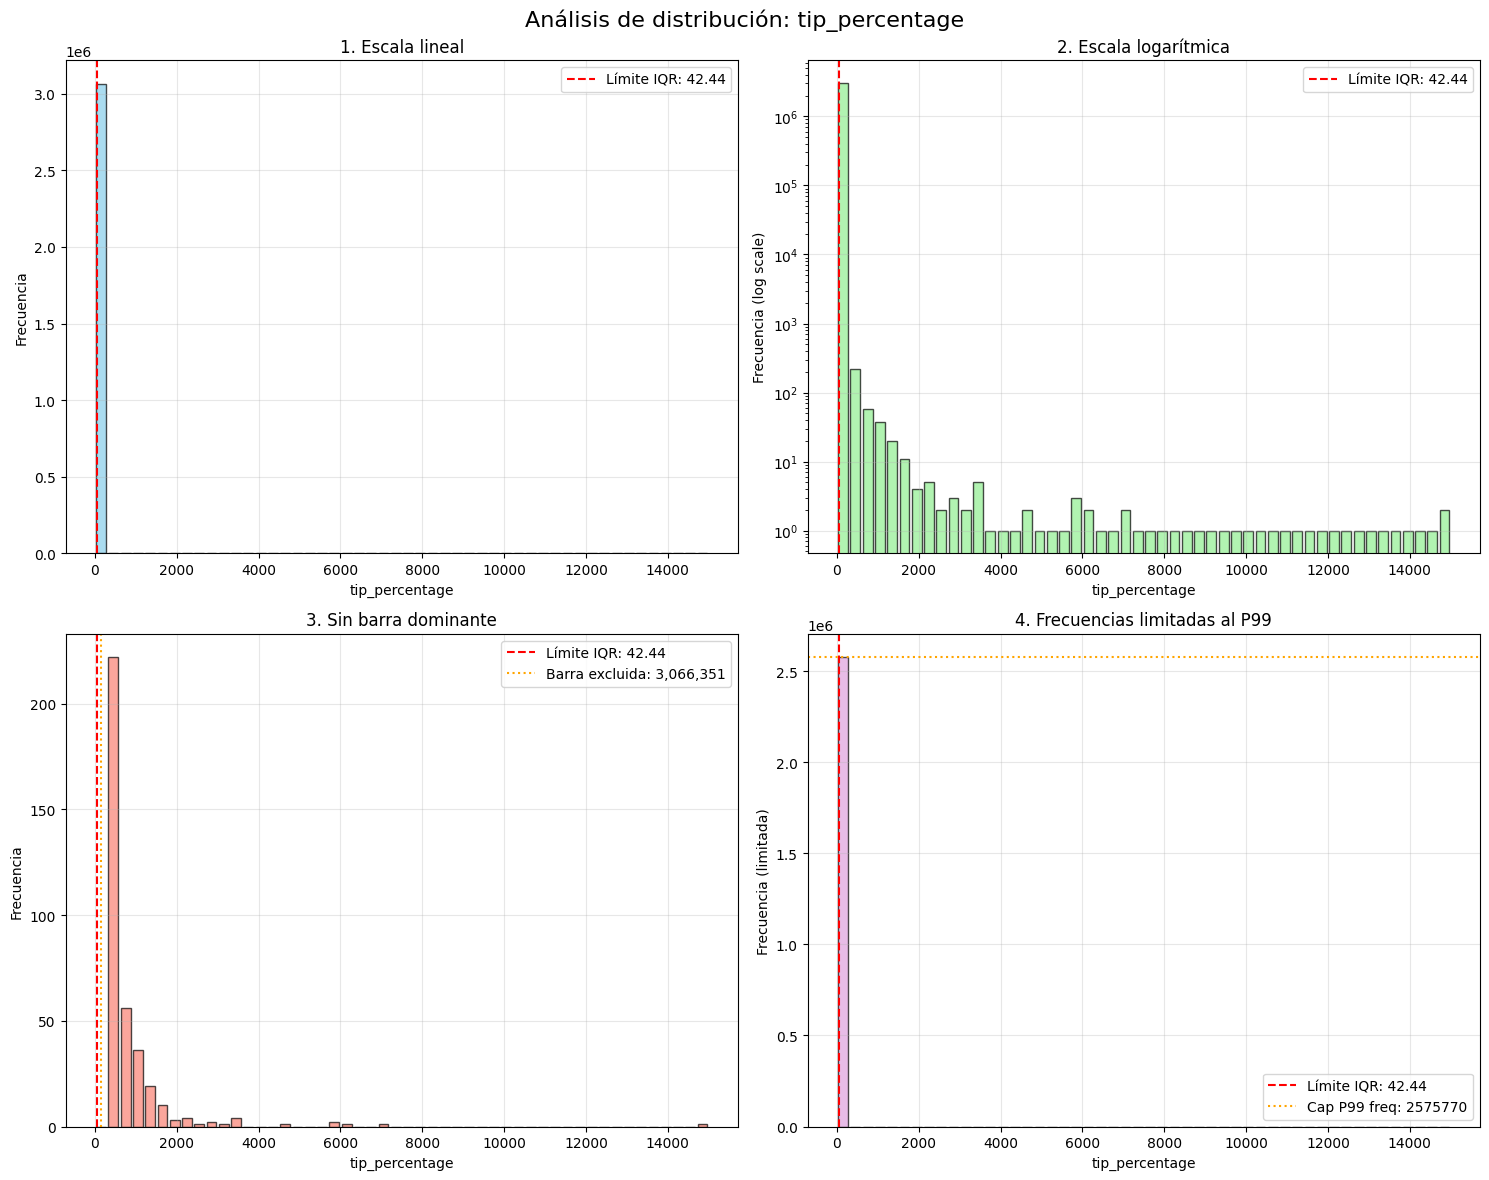


📉 Análisis de caída en histograma:
• Índice del bin con mayor caída: 11
• Frecuencia antes: 4, después: 0
• Caída relativa: -1.00
• Intervalo de caída: 3300.00 - 3600.00
• Centro del bin: 3450.00

📊 Análisis de la distribución:
• Barra más alta: 3,066,351 registros (100.0%) en valor ~150.00
• Total de registros: 3,066,715
• Ratio máx/mín frecuencia: 3066351.0:1
• Bins con datos: 17/50
• Frecuencia capada al P99: 2575770

Estadísticas del histograma:
Registros procesados: 3,066,715
Valor mínimo: 0.00
Valor máximo: 15000.00
Media: 14.40


In [67]:
col_name = "tip_percentage"

outliers_trip_duration = show_outliers_iqr(ds_features_imputed, col_name)

Como en las variables anteriores, vamos a estudiar el salto entre los percentiles 95 y 99.

In [68]:
pmin = 0.95
pmax = 0.99

granular_percentile_analysis(ds_features_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE tip_percentage

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 30.00 → 15000.00
   Multiplicador: 500.0x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:        30.00
   P 98.3%:        30.00
   P 98.4%:        30.00
   P 98.5%:        30.00
   P 98.6%:        30.00
   P 98.7%:        30.00
   P 98.8%:        30.00
   P 98.9%:        30.00
   P 99.0%:     15000.00 ← SALTO MÁXIMO
   P 99.1%:     15000.00
   P 99.2%:     15000.00
   P 99.3%:     15000.00
   P 99.4%:     15000.00
   P 99.5%:     15000.00
   P 99.6%:     15000.00
   P 99.7%:     15000.00


Imputaremos los valores superiores al 30,00% de propina.

*5.4.4) fare_per_mile*

Columna: fare_per_mile
Q1: 5.50, Q3: 8.45, IQR: 2.95
Límite superior (IQR): 12.89

Número de outliers: 138,421 (4.51%)

Percentiles de outliers:
P95: 12.33
P99: 40000.00
P99.5: 40000.00
P99.9: 40000.00

Top valores más frecuentes entre outliers:
+------------------+-----+
|fare_per_mile     |count|
+------------------+-----+
|13.0              |4032 |
|14.666666666666668|3645 |
|14.499999999999998|3165 |
|17.0              |2270 |
|13.166666666666668|1976 |
|14.4              |1651 |
|18.5              |1326 |
|16.25             |1303 |
|300.0             |1276 |
|22.0              |1204 |
+------------------+-----+


Generando histograma (recortado al P99)...
Registros para histograma: 3,066,715
Dataset grande, procesando en tramos...


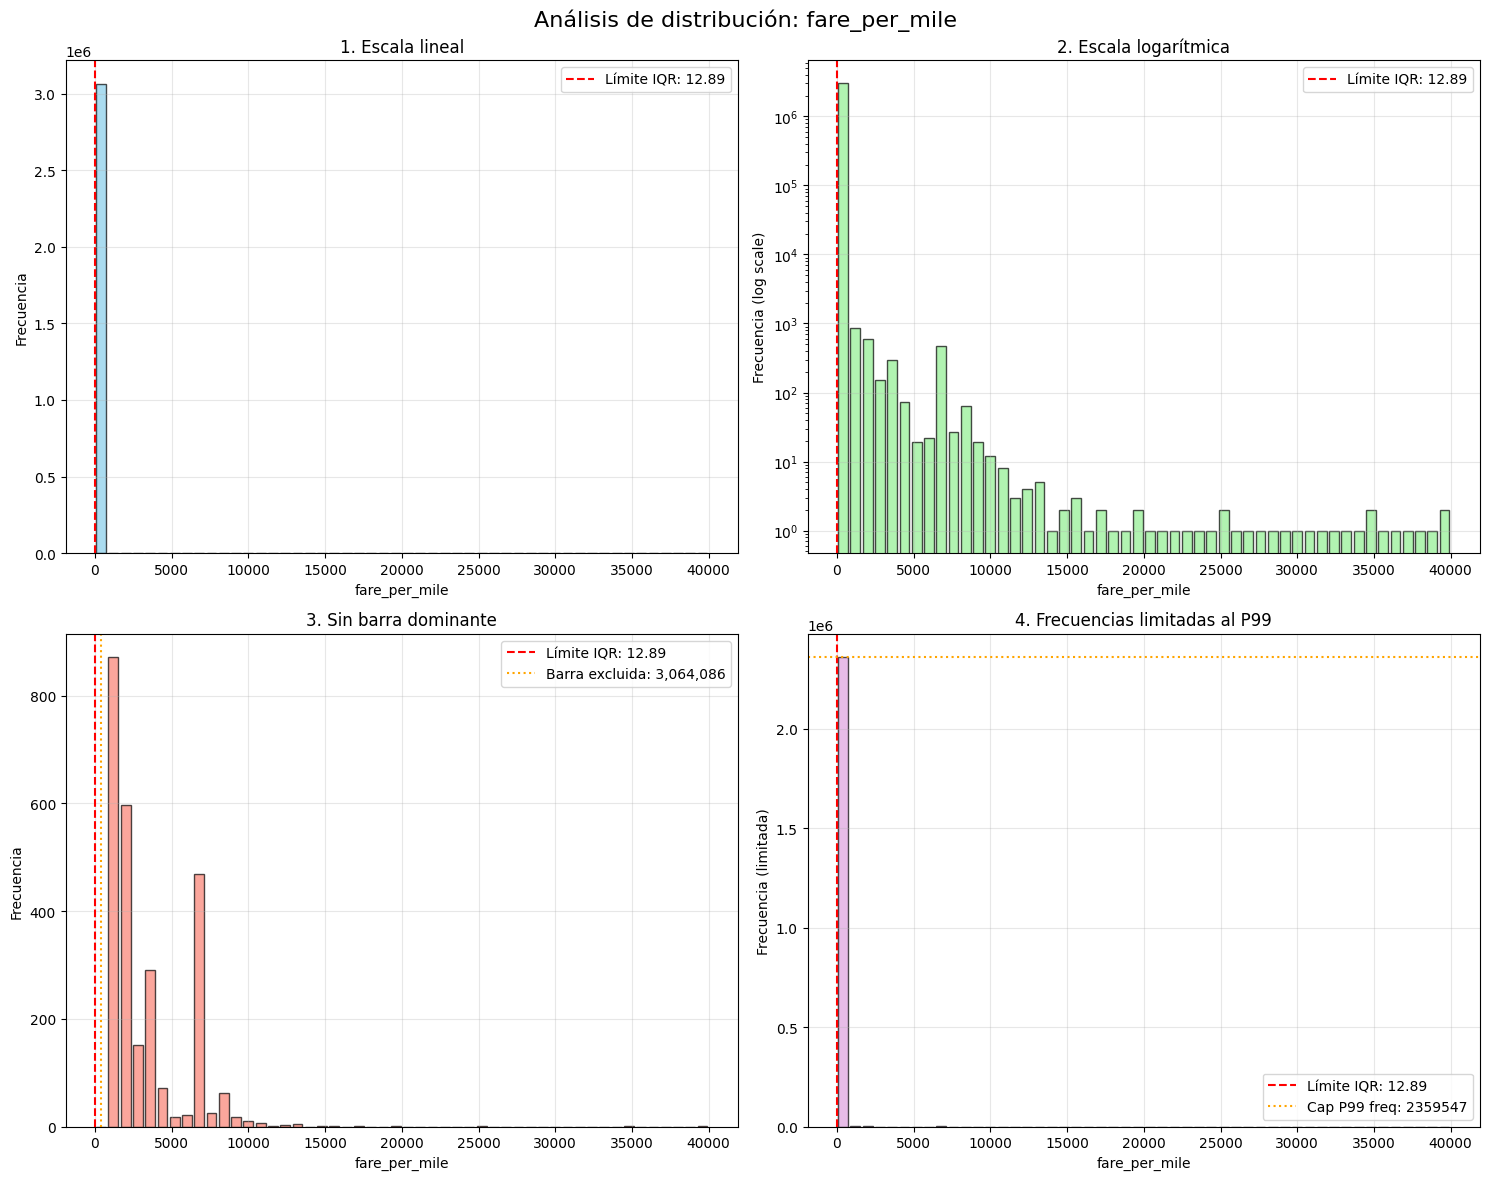


📉 Análisis de caída en histograma:
• Índice del bin con mayor caída: 16
• Frecuencia antes: 4, después: 0
• Caída relativa: -1.00
• Intervalo de caída: 12800.00 - 13600.00
• Centro del bin: 13200.00

📊 Análisis de la distribución:
• Barra más alta: 3,064,086 registros (99.9%) en valor ~400.00
• Total de registros: 3,066,715
• Ratio máx/mín frecuencia: 3064086.0:1
• Bins con datos: 24/50
• Frecuencia capada al P99: 2359547

Estadísticas del histograma:
Registros procesados: 3,066,715
Valor mínimo: 0.00
Valor máximo: 40000.00
Media: 11.13


In [69]:
col_name = "fare_per_mile"

outliers_trip_duration = show_outliers_iqr(ds_features_imputed, col_name)

In [70]:
pmin = 0.95
pmax = 0.99

granular_percentile_analysis(ds_features_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE fare_per_mile

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 21.29 → 40000.00
   Multiplicador: 1878.8x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:        15.65
   P 98.3%:        15.65
   P 98.4%:        15.65
   P 98.5%:        15.65
   P 98.6%:        15.65
   P 98.7%:        21.29
   P 98.8%:        21.29
   P 98.9%:        21.29
   P 99.0%:     40000.00 ← SALTO MÁXIMO
   P 99.1%:     40000.00
   P 99.2%:     40000.00
   P 99.3%:     40000.00
   P 99.4%:     40000.00
   P 99.5%:     40000.00
   P 99.6%:     40000.00
   P 99.7%:     40000.00


Imputaremos los valores de fare_per_mile superiores a 20,00 dólares.

*5.4.5) proportion_extra_charges*

Columna: proportion_extra_charges
Q1: 0.18, Q3: 0.34, IQR: 0.16
Límite superior (IQR): 0.59

Número de outliers: 66,301 (2.16%)

Percentiles de outliers:
P95: 0.52
P99: 50.00
P99.5: 50.00
P99.9: 50.00

Top valores más frecuentes entre outliers:
+------------------------+-----+
|proportion_extra_charges|count|
+------------------------+-----+
|0.6190476190476191      |5049 |
|0.6632653061224489      |4193 |
|0.5963302752293578      |3956 |
|0.7142857142857143      |3465 |
|0.625                   |3052 |
|0.6147540983606558      |1971 |
|0.6101694915254238      |1935 |
|0.6521739130434783      |1921 |
|0.6198347107438017      |1761 |
|0.7738095238095237      |1748 |
+------------------------+-----+


Generando histograma (recortado al P99)...
Registros para histograma: 3,066,715
Dataset grande, procesando en tramos...


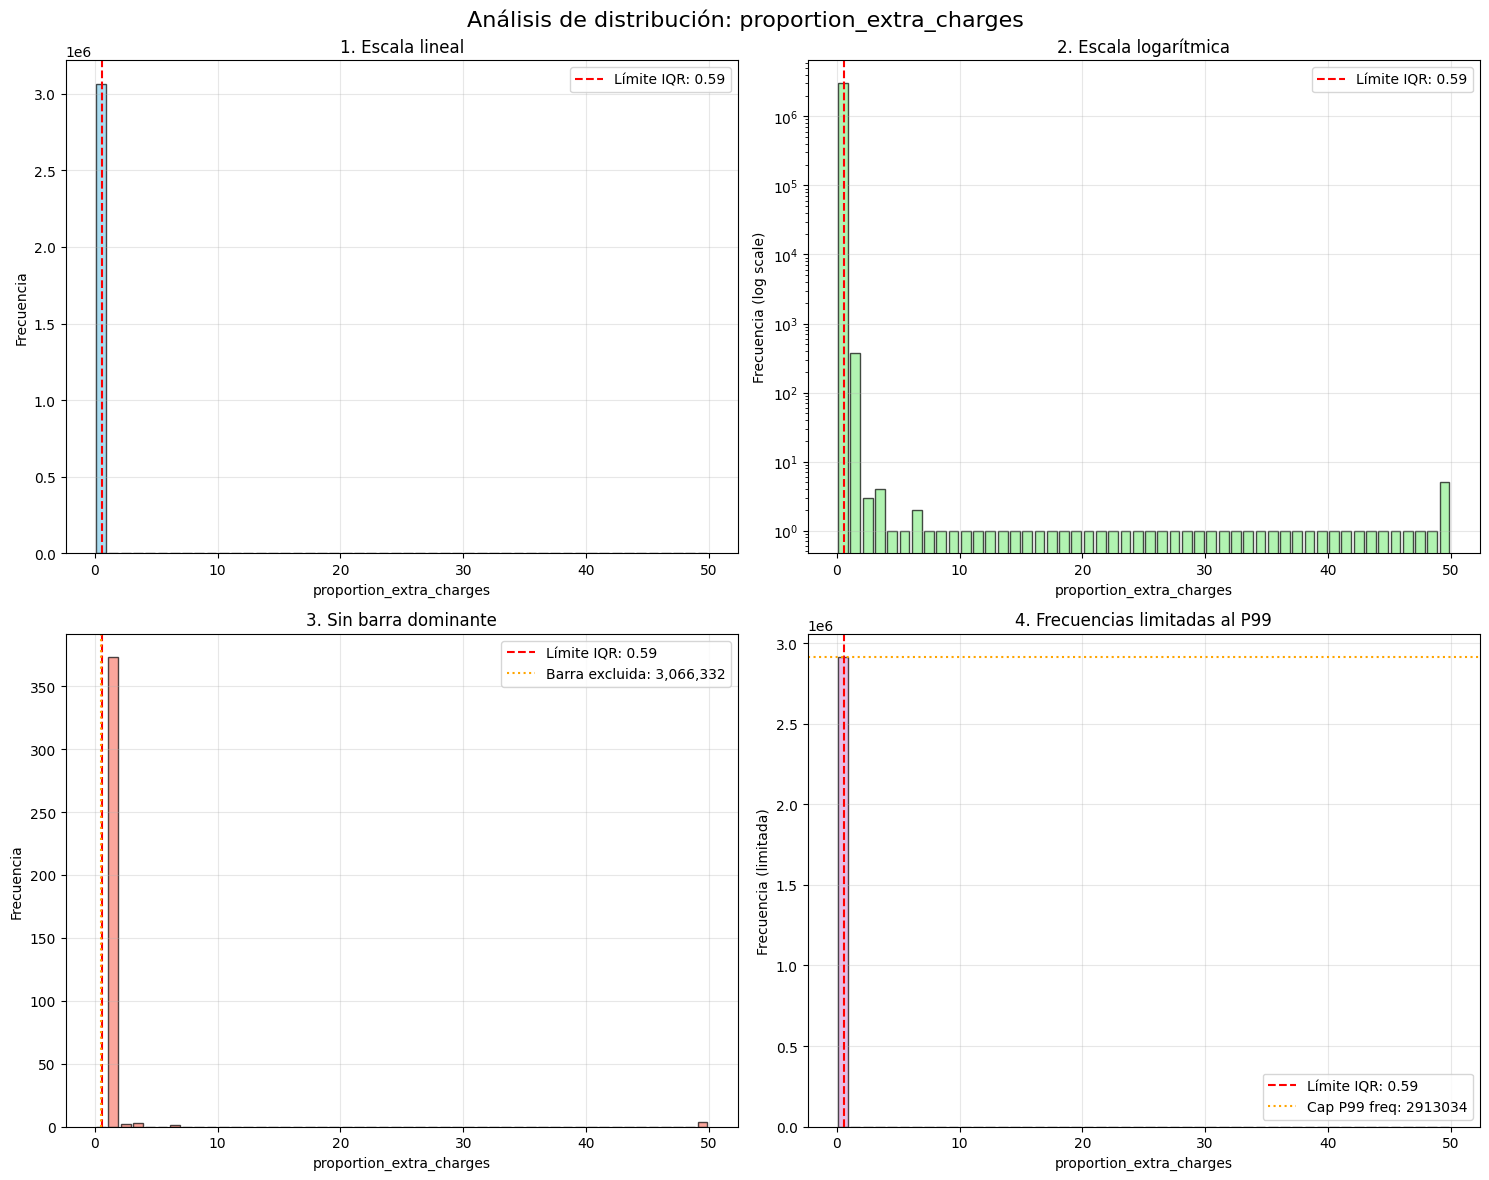


📉 Análisis de caída en histograma:
• Índice del bin con mayor caída: 3
• Frecuencia antes: 3, después: 0
• Caída relativa: -1.00
• Intervalo de caída: 3.00 - 4.00
• Centro del bin: 3.50

📊 Análisis de la distribución:
• Barra más alta: 3,066,332 registros (100.0%) en valor ~0.50
• Total de registros: 3,066,715
• Ratio máx/mín frecuencia: 3066332.0:1
• Bins con datos: 6/50
• Frecuencia capada al P99: 2913034

Estadísticas del histograma:
Registros procesados: 3,066,715
Valor mínimo: 0.00
Valor máximo: 50.00
Media: 0.27


In [71]:
col_name = "proportion_extra_charges"

outliers_trip_duration = show_outliers_iqr(ds_features_imputed, col_name)

In [72]:
pmin = 0.95
pmax = 0.99

granular_percentile_analysis(ds_features_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE proportion_extra_charges

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 0.61 → 50.00
   Multiplicador: 82.0x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:         0.61
   P 98.3%:         0.61
   P 98.4%:         0.61
   P 98.5%:         0.61
   P 98.6%:         0.61
   P 98.7%:         0.61
   P 98.8%:         0.61
   P 98.9%:         0.61
   P 99.0%:        50.00 ← SALTO MÁXIMO
   P 99.1%:        50.00
   P 99.2%:        50.00
   P 99.3%:        50.00
   P 99.4%:        50.00
   P 99.5%:        50.00
   P 99.6%:        50.00
   P 99.7%:        50.00


Para proportion_extra_charges, imputaremos los valores superiores al 65,00%.

*5.4.6) Imputación de outliers*

In [73]:
columnas_a_imputar = [
    "trip_duration_minutes_imputed",
    "average_speed_mph_imputed",
    "tip_percentage",
    "fare_per_mile",
    "proportion_extra_charges"
]

umbrales_a_imputar = [
    55.20,
    41.30,
    30.00,
    20.00,
    0.65
]

Primero vamos a analizar la relación de estas variables con la hora.

In [74]:
analyze_median_hourly_variation(ds_features_imputed, columnas_a_imputar)

Variación de la mediana de 'trip_duration_minutes_imputed':
+-----------------+-----------+------------------+-----------------+------------------------------+
|      mediana_min|mediana_max|  mediana_promedio|  rango_variacion|factor_variacion_tanto_por_uno|
+-----------------+-----------+------------------+-----------------+------------------------------+
|9.383333333333333|       12.5|11.232638888888888|3.116666666666667|           0.27746522411128294|
+-----------------+-----------+------------------+-----------------+------------------------------+

Variación de la mediana de 'average_speed_mph_imputed':
+-----------------+------------------+------------------+-----------------+------------------------------+
|      mediana_min|       mediana_max|  mediana_promedio|  rango_variacion|factor_variacion_tanto_por_uno|
+-----------------+------------------+------------------+-----------------+------------------------------+
|8.979591836734695|17.687344913151364|11.612776015823513|8.707

Todas las variables presentan variación con la hora.

In [75]:
ds_features_outliers_imputed = impute_columns_with_median_by_threshold(
    ds=ds_features_imputed,
    columnas=columnas_a_imputar,
    umbrales=umbrales_a_imputar,
    claves_agrupacion=['PULocationID', 'DOLocationID', 'pickup_hour'],
    tipo_umbral="superior"
)


Imputación de trip_duration_minutes_imputed (umbral superior: 55.2)
Registros con trip_duration_minutes_imputed que exceden el umbral: 36359
Mediana global calculada: 11.4
Imputaciones realizadas: 36359
Imputaciones usando mediana global: 3793
Tasa de éxito: 100.00%

Imputación de average_speed_mph_imputed (umbral superior: 41.3)
Registros con average_speed_mph_imputed que exceden el umbral: 36708
Mediana global calculada: 10.272373540856032
Imputaciones realizadas: 36708
Imputaciones usando mediana global: 2715
Tasa de éxito: 100.00%

Imputación de tip_percentage (umbral superior: 30.0)
Registros con tip_percentage que exceden el umbral: 40281
Mediana global calculada: 19.817073170731707
Imputaciones realizadas: 40281
Imputaciones usando mediana global: 832
Tasa de éxito: 100.00%

Imputación de fare_per_mile (umbral superior: 20.0)
Registros con fare_per_mile que exceden el umbral: 40091
Mediana global calculada: 6.8076923076923075
Imputaciones realizadas: 40091
Imputaciones usando m

*5.4.7) Comprobación de resultados*

In [76]:
ds_features_outliers_imputed.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'ingestion_timestamp',
 'source_file',
 'passenger_count_imputed',
 'pickup_hour',
 'trip_distance_imputed',
 'extra_imputed',
 'tip_amount_imputed',
 'tolls_amount_imputed',
 'improvement_surcharge_imputed',
 'congestion_surcharge_imputed',
 'airport_fee_imputed',
 'mta_tax_imputed',
 'fare_amount_imputed',
 'total_reconstructed',
 'total_amount_imputed',
 'RatecodeID_imputed',
 'store_and_fwd_flag_imputed',
 'congestion_surcharge_imputed_v2',
 'airport_fee_imputed_v2',
 'trip_duration_minutes',
 'is_weekend',
 'average_speed_mph',
 'tip_percentage',
 'fare_per_mile',
 'extra_charges',
 'proportion_extra_charges',
 'trip_duration_minutes_imputed

In [77]:
pmin = 0.95
pmax = 0.99

In [78]:
col_name = "trip_duration_minutes_imputed_v2"

granular_percentile_analysis(ds_features_outliers_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE trip_duration_minutes_imputed_v2

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 46.70 → 55.20
   Multiplicador: 1.2x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:        41.87
   P 98.3%:        46.70
   P 98.4%:        46.70
   P 98.5%:        46.70
   P 98.6%:        46.70
   P 98.7%:        46.70
   P 98.8%:        46.70
   P 98.9%:        46.70
   P 99.0%:        55.20 ← SALTO MÁXIMO
   P 99.1%:        55.20
   P 99.2%:        55.20
   P 99.3%:        55.20
   P 99.4%:        55.20
   P 99.5%:        55.20
   P 99.6%:        55.20
   P 99.7%:        55.20


In [79]:
col_name = "average_speed_mph_imputed_v2"

granular_percentile_analysis(ds_features_outliers_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE average_speed_mph_imputed_v2

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 36.25 → 41.30
   Multiplicador: 1.1x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:        32.51
   P 98.3%:        32.51
   P 98.4%:        32.51
   P 98.5%:        32.51
   P 98.6%:        32.51
   P 98.7%:        36.25
   P 98.8%:        36.25
   P 98.9%:        36.25
   P 99.0%:        41.30 ← SALTO MÁXIMO
   P 99.1%:        41.30
   P 99.2%:        41.30
   P 99.3%:        41.30
   P 99.4%:        41.30
   P 99.5%:        41.30
   P 99.6%:        41.30
   P 99.7%:        41.30


In [80]:
col_name = "tip_percentage_imputed"

granular_percentile_analysis(ds_features_outliers_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE tip_percentage_imputed

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.3% y P98.4%
   De 25.17 → 29.92
   Multiplicador: 1.2x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 97.6%:        25.17
   P 97.7%:        25.17
   P 97.8%:        25.17
   P 97.9%:        25.17
   P 98.0%:        25.17
   P 98.1%:        25.17
   P 98.2%:        25.17
   P 98.3%:        25.17
   P 98.4%:        29.92 ← SALTO MÁXIMO
   P 98.5%:        29.92
   P 98.6%:        29.92
   P 98.7%:        29.92
   P 98.8%:        29.92
   P 98.9%:        29.92
   P 99.0%:        30.00
   P 99.1%:        30.00


In [81]:
col_name = "fare_per_mile_imputed"

granular_percentile_analysis(ds_features_outliers_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE fare_per_mile_imputed

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 14.19 → 20.00
   Multiplicador: 1.4x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:        13.45
   P 98.3%:        13.45
   P 98.4%:        13.45
   P 98.5%:        13.45
   P 98.6%:        14.19
   P 98.7%:        14.19
   P 98.8%:        14.19
   P 98.9%:        14.19
   P 99.0%:        20.00 ← SALTO MÁXIMO
   P 99.1%:        20.00
   P 99.2%:        20.00
   P 99.3%:        20.00
   P 99.4%:        20.00
   P 99.5%:        20.00
   P 99.6%:        20.00
   P 99.7%:        20.00


In [82]:
col_name = "proportion_extra_charges_imputed"

granular_percentile_analysis(ds_features_outliers_imputed, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE proportion_extra_charges_imputed

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 0.57 → 0.65
   Multiplicador: 1.1x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:         0.55
   P 98.3%:         0.55
   P 98.4%:         0.55
   P 98.5%:         0.55
   P 98.6%:         0.55
   P 98.7%:         0.57
   P 98.8%:         0.57
   P 98.9%:         0.57
   P 99.0%:         0.65 ← SALTO MÁXIMO
   P 99.1%:         0.65
   P 99.2%:         0.65
   P 99.3%:         0.65
   P 99.4%:         0.65
   P 99.5%:         0.65
   P 99.6%:         0.65
   P 99.7%:         0.65


In [83]:
# limpia la memoria
if 'ds_features_imputed' in locals():
    ds_features_imputed.unpersist()

# **6) Codificación y escalado de datos**

In [84]:
ds_features_outliers_imputed.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'ingestion_timestamp',
 'source_file',
 'passenger_count_imputed',
 'pickup_hour',
 'trip_distance_imputed',
 'extra_imputed',
 'tip_amount_imputed',
 'tolls_amount_imputed',
 'improvement_surcharge_imputed',
 'congestion_surcharge_imputed',
 'airport_fee_imputed',
 'mta_tax_imputed',
 'fare_amount_imputed',
 'total_reconstructed',
 'total_amount_imputed',
 'RatecodeID_imputed',
 'store_and_fwd_flag_imputed',
 'congestion_surcharge_imputed_v2',
 'airport_fee_imputed_v2',
 'trip_duration_minutes',
 'is_weekend',
 'average_speed_mph',
 'tip_percentage',
 'fare_per_mile',
 'extra_charges',
 'proportion_extra_charges',
 'trip_duration_minutes_imputed

- Variables categóricas: PULocationID, DOLocationID, passenger_count_imputed, RatecodeID_imputed

- Variables numéricas: trip_distance_imputed, extra_imputed, tip_amount_imputed, tolls_amount_imputed, improvement_surcharge_imputed, mta_tax_imputed, fare_amount_imputed, total_amount_imputed, congestion_surcharge_imputed_v2, airport_fee_imputed_v2, trip_duration_minutes_imputed_v2, average_speed_mph_imputed_v2, tip_percentage_imputed, fare_per_mile_imputed, proportion_extra_charges_imputed

- Variables de fecha: tpep_pickup_datetime, tpep_dropoff_datetime

- Variables binarias: VendorID, store_and_fwd_flag_imputed, is_weekend

- Otras variables: payment_type, pickup_hour

**6.1) Codificación de variables categóricas**

En PySpark usamos StringIndexer para codificar las variables categóricas:

- PULocationID
- DOLocationID
- passenger_count_imputed
- RatecodeID_imputed

In [85]:
# inicializa diccionario para almacenar los modelos entrenados
models = {}

# inicializa el dataframe codificado
ds_encoded = ds_features_outliers_imputed

In [86]:
categorical_vars = [
    "PULocationID", "DOLocationID", "passenger_count_imputed", "RatecodeID_imputed"
]

In [87]:
for var in categorical_vars:

    print(f"\n=== Aplicando StringIndexer a: {var} ===\n")

    # utiliza el dataframe codificado como entrada
    ds_encoded, model, new_col_name = apply_codification_spark(ds_encoded, var, 'SI')
    models[f"{var}_SI"] = model


=== Aplicando StringIndexer a: PULocationID ===

Value counts de la columna transformada:
+--------------------+------+
|PULocationID_encoded| count|
+--------------------+------+
|                 0.0|160022|
|                 1.0|148074|
|                 2.0|138391|
|                 3.0|135415|
|                 4.0|109226|
|                 5.0|105332|
|                 6.0|100226|
|                 7.0| 98988|
|                 8.0| 89186|
|                 9.0| 88346|
|                10.0| 87143|
|                11.0| 85130|
|                12.0| 83523|
|                13.0| 81221|
|                14.0| 81006|
|                15.0| 77956|
|                16.0| 75120|
|                17.0| 68195|
|                18.0| 67337|
|                19.0| 67150|
+--------------------+------+
only showing top 20 rows

✓ Variable PULocationID codificada como PULocationID_encoded

=== Aplicando StringIndexer a: DOLocationID ===

Value counts de la columna transformada:
+----------

In [88]:
# limpia la memoria
if 'ds_features_outliers_imputed' in locals():
    ds_features_outliers_imputed.unpersist()

**6.2) Escalado de variables numéricas**

Inicialmente usamos VectorAssembler para que las variables numéricas estén en formato vector. Luego emplearíamos MinMax Scaler, ya que ninguna variable tiene distribución gaussiana; pero como todas las variables numéricas tienen valores extremos, y Standard Scaler es más robusto ante valores extremos, aplicaremos Standard Scaler en todas ellas.

- trip_distance_imputed
- extra_imputed
- tip_amount_imputed
- tolls_amount_imputed
- improvement_surcharge_imputed
- mta_tax_imputed
- fare_amount_imputed
- total_amount_imputed
- congestion_surcharge_imputed_v2
- airport_fee_imputed_v2
- trip_duration_minutes_imputed_v2
- average_speed_mph_imputed_v2
- tip_percentage_imputed
- fare_per_mile_imputed
- proportion_extra_charges_imputed

In [89]:
numeric_vars_standard = [
    "trip_distance_imputed", "extra_imputed", "tip_amount_imputed", "tolls_amount_imputed",
    "improvement_surcharge_imputed", "mta_tax_imputed", "fare_amount_imputed",
    "total_amount_imputed", "congestion_surcharge_imputed_v2", "airport_fee_imputed_v2",
    "trip_duration_minutes_imputed_v2", "average_speed_mph_imputed_v2", "tip_percentage_imputed",
    "fare_per_mile_imputed", "proportion_extra_charges_imputed"
]

In [90]:
for var in numeric_vars_standard:

    print(f"\n=== Aplicando StandardScaler a: {var} ===\n")

    # utiliza el dataframe codificado como entrada
    ds_encoded, model, new_col_name = apply_codification_spark(ds_encoded, var, 'SS')
    models[f"{var}_SS"] = model


=== Aplicando StandardScaler a: trip_distance_imputed ===

StandardScaler model -- mean (if present): [3.8799381259751895]
StandardScaler model -- std: [249.59636057623297]
Value counts de la columna transformada:
+---------------------+-----+
|trip_distance_encoded|count|
+---------------------+-----+
| -0.01153838188716...|44687|
| -0.01193902875464...|43992|
| -0.01113773501968...|42888|
| -0.01233967562213...|42349|
| -0.01073708815219...|42007|
| -0.01033644128471...|40470|
| -0.01274032248961...|38941|
| -0.00993579441723372|37626|
| -0.00953514754975...|35812|
| -0.01314096935709...|34516|
| -0.00833320694730...|34480|
| -0.00913450068226792|33926|
| -0.00873385381478...|31488|
| -0.00793256007981922|27292|
| -0.01354161622457...|25941|
| -0.00753191321233...|25066|
| -0.00713126634485...|23073|
| -0.00673061947737...|21201|
| -0.00632997260988...|19680|
| -0.00592932574240...|17962|
+---------------------+-----+
only showing top 20 rows

✓ Variable trip_distance_imputed escala

**6.3) Codificación de variables de fecha**

Codificamos las variables de fecha usando componentes temporales:

- tpep_pickup_datetime
- tpep_dropoff_datetime

In [91]:
date_vars = [
    "tpep_pickup_datetime", "tpep_dropoff_datetime"
]

In [92]:
for var in date_vars:

    print(f"\n=== Aplicando transformación de fechas a: {var} ===\n")

    # utiliza el dataframe codificado como entrada
    ds_encoded, model, _ = apply_codification_spark(ds_encoded, var, 'DT')
    models[f"{var}_DT"] = model


=== Aplicando transformación de fechas a: tpep_pickup_datetime ===

Columnas generadas:

tpep_pickup_datetime_day
tpep_pickup_datetime_dayofweek
tpep_pickup_datetime_dayofweek_cos
tpep_pickup_datetime_dayofweek_sin
tpep_pickup_datetime_month
tpep_pickup_datetime_month_cos
tpep_pickup_datetime_month_sin
tpep_pickup_datetime_week
tpep_pickup_datetime_year

✓ Variable tpep_pickup_datetime transformada con múltiples componentes temporales

=== Aplicando transformación de fechas a: tpep_dropoff_datetime ===

Columnas generadas:

tpep_dropoff_datetime_day
tpep_dropoff_datetime_dayofweek
tpep_dropoff_datetime_dayofweek_cos
tpep_dropoff_datetime_dayofweek_sin
tpep_dropoff_datetime_month
tpep_dropoff_datetime_month_cos
tpep_dropoff_datetime_month_sin
tpep_dropoff_datetime_week
tpep_dropoff_datetime_year

✓ Variable tpep_dropoff_datetime transformada con múltiples componentes temporales


In [93]:
print(f"Ejemplos de transformaciones para {date_vars[0]}:")

date_cols = [col_name for col_name in ds_encoded.columns if date_vars[0] in col_name and col_name != date_vars[0]]
# muestra hasta 8 columnas
ds_encoded.select([date_vars[0]] + date_cols[:8]).show()

Ejemplos de transformaciones para tpep_pickup_datetime:
+--------------------+-------------------------+--------------------------+------------------------+------------------------------+-------------------------+------------------------------+------------------------------+----------------------------------+
|tpep_pickup_datetime|tpep_pickup_datetime_year|tpep_pickup_datetime_month|tpep_pickup_datetime_day|tpep_pickup_datetime_dayofweek|tpep_pickup_datetime_week|tpep_pickup_datetime_month_sin|tpep_pickup_datetime_month_cos|tpep_pickup_datetime_dayofweek_sin|
+--------------------+-------------------------+--------------------------+------------------------+------------------------------+-------------------------+------------------------------+------------------------------+----------------------------------+
| 2023-01-01 00:32:10|                     2023|                         1|                       1|                             1|                       52|                      

Atención: en el caso concreto de este dataset, todos los datos corresponden a Enero de 2023; por tanto, las nuevas variables relacionadas con el año y con el mes tendrán un valor único. No van a ser variables que aporten información útil, y habrá que eliminarlas.

**6.4) Codificación de variables binarias**

Variables de dos únicos valores, codificamos a 0/1:

- VendorID
- store_and_fwd_flag_imputed

is_weekend: ya es variable binaria (0/1), no se modifica.

In [94]:
binary_vars = [
    "VendorID", "store_and_fwd_flag_imputed"
]

In [95]:
for var in binary_vars:

    print(f"\n=== Aplicando codificación binaria a: {var} ===\n")

    # utiliza el dataframe codificado como entrada
    ds_encoded, model, new_col_name = apply_codification_spark(
        ds_encoded, var, 'BN',
        true_values = [1, "Y"]
    )
    models[f"{var}_BN"] = model


=== Aplicando codificación binaria a: VendorID ===

Value counts de la columna transformada:
+----------------+-------+
|VendorID_encoded|  count|
+----------------+-------+
|               0|2239349|
|               1| 827366|
+----------------+-------+

✓ Variable VendorID codificada como VendorID_encoded

=== Aplicando codificación binaria a: store_and_fwd_flag_imputed ===

Value counts de la columna transformada:
+--------------------------+-------+
|store_and_fwd_flag_encoded|  count|
+--------------------------+-------+
|                         0|3046712|
|                         1|  20003|
+--------------------------+-------+

✓ Variable store_and_fwd_flag_imputed codificada como store_and_fwd_flag_encoded


**6.5) Codificación de otras variables**

**6.5.1) payment_type**

Variable numérica de 5 valores únicos, realmente son categorías. Al no existir ningún orden real, podríamos codificar utilizando One-Hot Encoding.

Sin embargo, One-Hot generaría 5 nuevas variables en un dataset que ya tiene muchas variables. Dado el objetivo de este estudio, analizar los datos sin intención de aplicar algoritmos de Machine Learning, vamos a dejar esta variable con sus valores numéricos originales (0 a 4).


**Nota**: mantengo este código para probar la función; utiliza un dataframe temporal que luego se elimina.

In [96]:
vars = [
    "payment_type"
]

In [97]:
models_temp = {}

ds_temp = ds_encoded

In [98]:
for var in vars:

    print(f"\n=== Aplicando codificación One-Hot a: {var} ===\n")

    # utiliza el dataframe codificado como entrada
    ds_temp, model, columns_str = apply_codification_spark(
        ds_temp, var, 'OH'
    )
    models_temp[f"{var}_OH"] = model


=== Aplicando codificación One-Hot a: payment_type ===

Columnas generadas:

payment_type_oh_0
payment_type_oh_1
payment_type_oh_2
payment_type_oh_3
payment_type_oh_4

✓ Variable payment_type de 5 categorías ha generado 5 columnas


In [99]:
print(f"Ejemplos de transformaciones para {vars[0]}:")

columnas = [col_name for col_name in ds_temp.columns if vars[0] in col_name and col_name != vars[0]]
# muestra hasta 8 columnas
ds_temp.select([vars[0]] + columnas[:8]).show()

Ejemplos de transformaciones para payment_type:
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|payment_type|payment_type_oh_1|payment_type_oh_2|payment_type_oh_0|payment_type_oh_4|payment_type_oh_3|
+------------+-----------------+-----------------+-----------------+-----------------+-----------------+
|           2|                0|                1|                0|                0|                0|
|           1|                1|                0|                0|                0|                0|
|           1|                1|                0|                0|                0|                0|
|           1|                1|                0|                0|                0|                0|
|           1|                1|                0|                0|                0|                0|
|           1|                1|                0|                0|                0|                0|
|      

In [100]:
# limpia la memoria
if 'ds_temp' in locals():
    ds_temp.unpersist()

**6.5.2) pickup_hour**

Horas del día (0 a 23), vamos a usar codificación cíclica para reflejar su periodicidad (23 y 0 están "cerca").

En este caso sólo se van a generar 2 nuevas variables.

In [101]:
vars = [
    "pickup_hour"
]

In [102]:
for var in vars:

    print(f"\n=== Aplicando codificación cíclica a: {var} ===\n")

    # utiliza el dataframe codificado como entrada
    ds_encoded, model, columns_str = apply_codification_spark(
        ds_encoded, var, 'HR'
    )
    models[f"{var}_HR"] = model


=== Aplicando codificación cíclica a: pickup_hour ===

Columnas generadas:

pickup_hour_hour_cos
pickup_hour_hour_sin

✓ Variable pickup_hour codificada


In [103]:
print(f"Ejemplos de transformaciones para {vars[0]}:")

columnas = [col_name for col_name in ds_encoded.columns if vars[0] in col_name and col_name != vars[0]]
# muestra hasta 8 columnas
ds_encoded.select([vars[0]] + columnas[:8]).show()

Ejemplos de transformaciones para pickup_hour:
+-----------+--------------------+--------------------+
|pickup_hour|pickup_hour_hour_sin|pickup_hour_hour_cos|
+-----------+--------------------+--------------------+
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|          0|                 0.0|                 1.0|
|

**6.6) Modelos entrenados**

In [104]:
print("=== MODELOS ENTRENADOS ===\n")
print("Modelos guardados para futuros datos:\n")

for model_name in models.keys():
    print(f"- {model_name}: {type(models[model_name])}")

print("\nTotal de modelos:", len(models))

=== MODELOS ENTRENADOS ===

Modelos guardados para futuros datos:

- PULocationID_SI: <class 'pyspark.ml.feature.StringIndexerModel'>
- DOLocationID_SI: <class 'pyspark.ml.feature.StringIndexerModel'>
- passenger_count_imputed_SI: <class 'pyspark.ml.feature.StringIndexerModel'>
- RatecodeID_imputed_SI: <class 'pyspark.ml.feature.StringIndexerModel'>
- trip_distance_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- extra_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- tip_amount_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- tolls_amount_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- improvement_surcharge_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- mta_tax_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- fare_amount_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- total_amount_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- congestion_surcharge_imputed_v2_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- a

**6.7) Eliminación de variables de fecha no útiles**

Como hemos visto, las nuevas variables relacionadas con el año y con el mes no van a resultar de utilidad en este dataset, debido a que todos los datos corresponden a Enero de 2023. Por tanto, vamos a eliminarlas.

In [105]:
cols_a_borrar = [
    "tpep_pickup_datetime_month",
    "tpep_pickup_datetime_month_cos",
    "tpep_pickup_datetime_month_sin",
    "tpep_pickup_datetime_year",
    "tpep_dropoff_datetime_month",
    "tpep_dropoff_datetime_month_cos",
    "tpep_dropoff_datetime_month_sin",
    "tpep_dropoff_datetime_year"
]

In [106]:
ds_encoded_clean = ds_encoded.drop(*cols_a_borrar)

In [107]:
ds_encoded_clean.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'ingestion_timestamp',
 'source_file',
 'passenger_count_imputed',
 'pickup_hour',
 'trip_distance_imputed',
 'extra_imputed',
 'tip_amount_imputed',
 'tolls_amount_imputed',
 'improvement_surcharge_imputed',
 'congestion_surcharge_imputed',
 'airport_fee_imputed',
 'mta_tax_imputed',
 'fare_amount_imputed',
 'total_reconstructed',
 'total_amount_imputed',
 'RatecodeID_imputed',
 'store_and_fwd_flag_imputed',
 'congestion_surcharge_imputed_v2',
 'airport_fee_imputed_v2',
 'trip_duration_minutes',
 'is_weekend',
 'average_speed_mph',
 'tip_percentage',
 'fare_per_mile',
 'extra_charges',
 'proportion_extra_charges',
 'trip_duration_minutes_imputed

In [108]:
print("Número de variables:", len(ds_encoded_clean.columns))

Número de variables: 85


In [109]:
# limpia la memoria
if 'ds_encoded' in locals():
    ds_encoded.unpersist()

# **7) Preparación de datos para correlaciones lineales**



**7.1) Creación de nuevas variables**

En el proceso de estudio de la correlación se han detectado tres nuevas variables que pueden aportar información al dataset.

Para crear estas nuevas variables son necesarias las variables numéricas. Dado que estas variables numéricas serán eliminadas próximamente, ya que el estudio de la correlación utilizará sólo las variables codificadas, vamos a crear ahora esas variables nuevas antes de que las numéricas sean eliminadas.

*7.1.1) Peaje*

toll_indicator: variable binaria, indica si el viaje contiene o no peajes.

In [110]:
ds_encoded_features_v2 = ds_encoded_clean.withColumn(
    "toll_indicator",
    (col("tolls_amount_imputed") > 0)
)

ds_encoded_features_v2.select(
    "tolls_amount_imputed",
    "toll_indicator"
    ).show(5, truncate=False)

+--------------------+--------------+
|tolls_amount_imputed|toll_indicator|
+--------------------+--------------+
|0.0                 |false         |
|0.0                 |false         |
|0.0                 |false         |
|0.0                 |false         |
|0.0                 |false         |
+--------------------+--------------+
only showing top 5 rows



In [111]:
col_name = 'toll_indicator'

show_column_spark(ds_encoded_features_v2, col_name)

Tipo de dato: boolean
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+--------------+-------+
|toll_indicator|  count|
+--------------+-------+
|         false|2840546|
|          true| 226169|
+--------------+-------+

--------------------------------------------------
Valores únicos: 2
--------------------------------------------------
Valores nulos: 0 (0.00%)
--------------------------------------------------


In [112]:
# variable para análisis temporal
col_fecha = 'tpep_pickup_datetime'

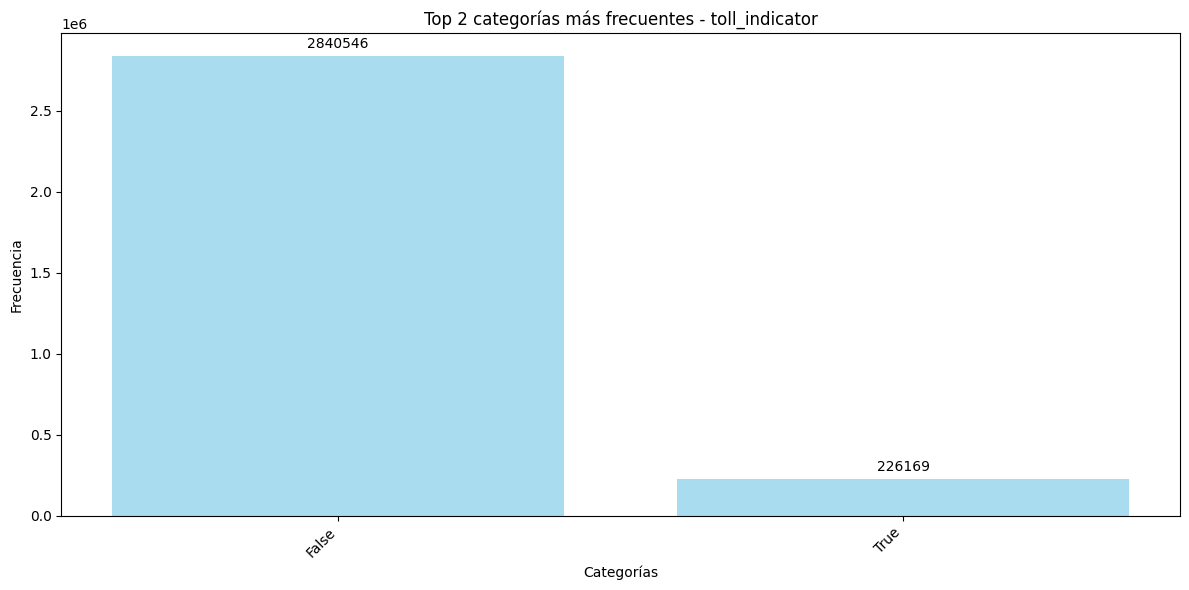

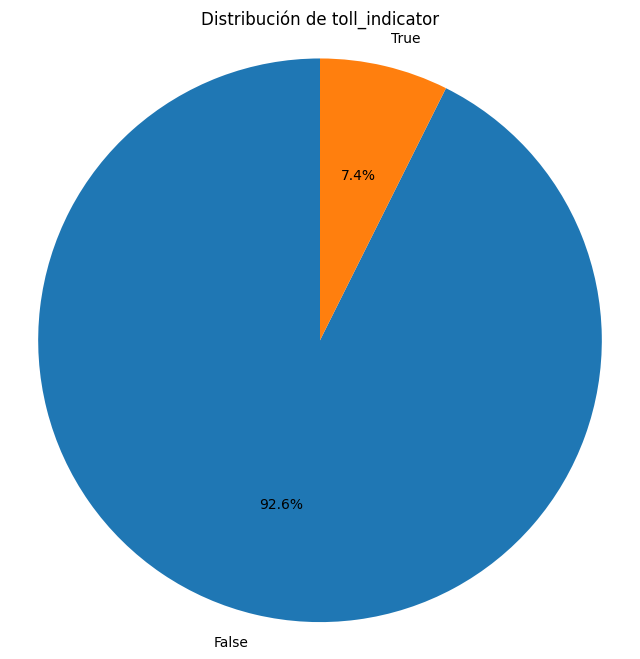

No hay datos para mostrar en el gráfico de evolución temporal.
No hay datos para mostrar en el gráfico de barras apiladas.
=============== Frecuencia de valores ===============
False: 2840546
True: 226169
RESUMEN ESTADÍSTICO - toll_indicator
Total de registros: 3,066,715
Categorías únicas: 2
Categoría más frecuente: 'False'  (2,840,546 veces,  92.6%)
Categoría menos frecuente: 'True'  (226,169 veces,  7.4%)
Concentración 2 valores más repetidos:  100.0% de los datos
Período analizado: 2023-01-01 00:00:00  a 2023-01-31 23:59:59
Períodos de semana: 6


<Figure size 1400x800 with 0 Axes>

In [113]:
info = analyze_categorical_variable_spark(ds_encoded_features_v2, col_name, col_fecha)

In [114]:
# limpia la memoria
if 'ds_encoded_clean' in locals():
    ds_encoded_clean.unpersist()

*7.1.2) Porcentaje de propina*

tip_score: porcentaje de propina sobre la tarifa base

In [115]:
ds_encoded_features_v2 = ds_encoded_features_v2.withColumn(
    "tip_score",
    (col("tip_amount_imputed") / col("fare_amount_imputed"))
)

ds_encoded_features_v2.select(
    "tip_amount_imputed",
    "fare_amount_imputed",
    "tip_score"
    ).show(5, truncate=False)

+------------------+-------------------+------------------+
|tip_amount_imputed|fare_amount_imputed|tip_score         |
+------------------+-------------------+------------------+
|0.0               |9.3                |0.0               |
|4.0               |7.9                |0.5063291139240506|
|15.0              |14.9               |1.006711409395973 |
|0.0               |12.1               |0.0               |
|3.28              |11.4               |0.287719298245614 |
+------------------+-------------------+------------------+
only showing top 5 rows



In [116]:
col_name = 'tip_score'

show_column_spark(ds_encoded_features_v2, col_name)

Tipo de dato: double
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+-------------------+------+
|          tip_score| count|
+-------------------+------+
|                0.0|694916|
|0.27999999999999997| 33995|
| 0.3230769230769231| 26978|
| 0.2930232558139535| 26362|
| 0.2860215053763441| 26291|
| 0.3012658227848101| 24877|
|0.27476635514018694| 24627|
|0.25925925925925924| 24322|
|0.27017543859649124| 23537|
| 0.3111111111111111| 23353|
|0.26611570247933886| 21944|
|0.26249999999999996| 20730|
|                0.3| 20129|
|0.25633802816901413| 17184|
|0.23014285714285712| 16004|
| 0.2536912751677852| 15662|
|0.33793103448275863| 14593|
|0.24705882352941178| 14333|
| 0.2512820512820513| 14259|
| 0.3538461538461538| 14234|
+-------------------+------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 52,129
Valores a cero: 694,916 (22.66%)
Valores negativos: 0 (0.00%)
-----------------------------------


Estadísticas de tip_score:
Media: 0.21
Desviación estándar: 8.48
Skewness: 1639.078 (muy sesgada)
Outliers: 12,101 (0.4%)


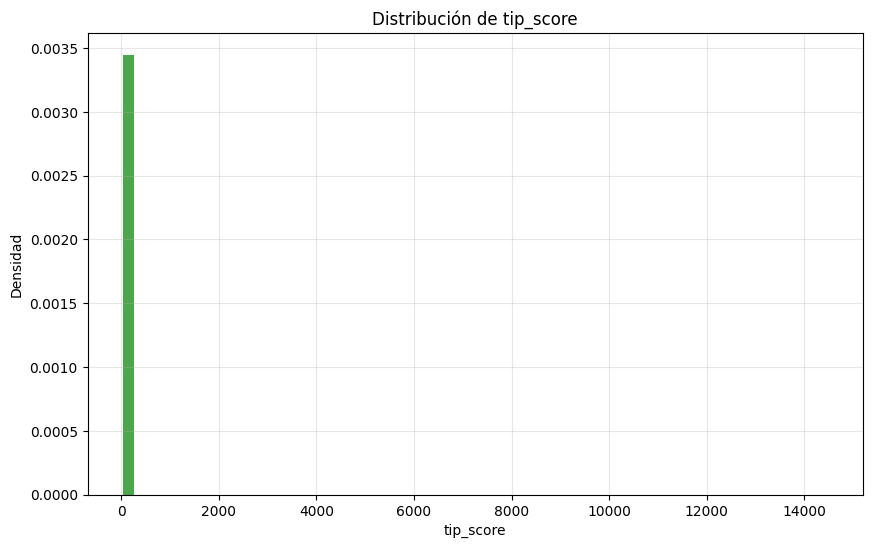

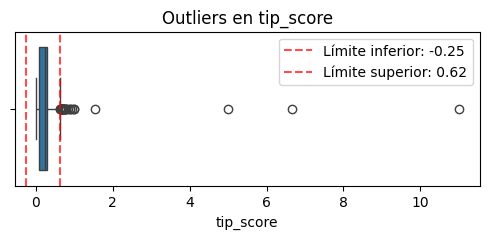

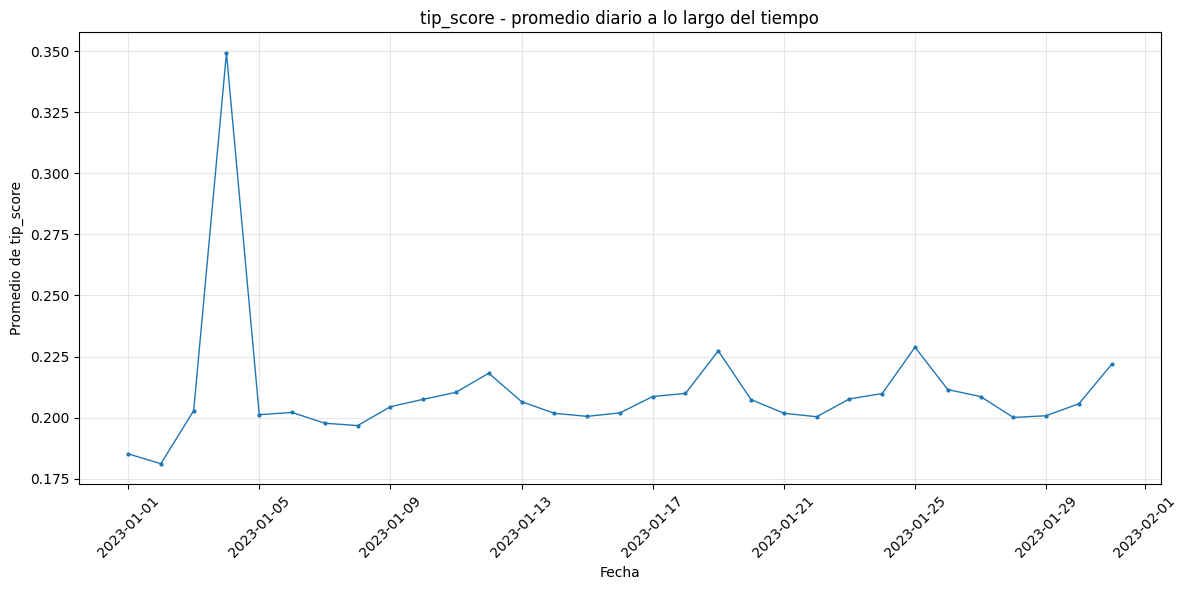

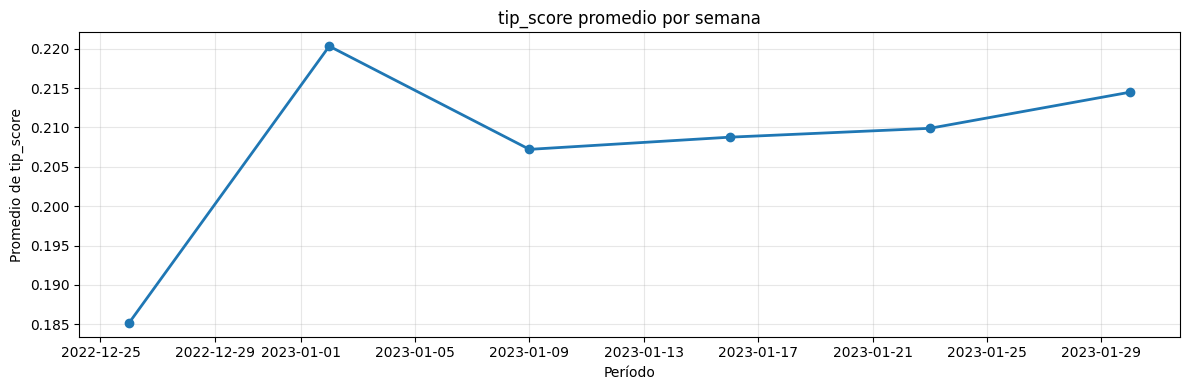

In [117]:
info = analyze_numeric_variable_spark(ds_encoded_features_v2, col_name, col_fecha)

*7.1.3) Proporción de cargos extra*

trip_extra_cost_ratio: indica la parte del precio debida a cargos extra (tasa de aeropuerto y congestión de tráfico).

In [118]:
ds_encoded_features_v2 = ds_encoded_features_v2.withColumn(
    "trip_extra_cost_ratio",
    (col("airport_fee_imputed_v2") + col("congestion_surcharge_imputed_v2")) / col("total_amount_imputed")
)

ds_encoded_features_v2.select(
    "airport_fee_imputed_v2",
    "congestion_surcharge_imputed_v2",
    "total_amount_imputed",
    "trip_extra_cost_ratio"
    ).show(5, truncate=False)

+----------------------+-------------------------------+--------------------+---------------------+
|airport_fee_imputed_v2|congestion_surcharge_imputed_v2|total_amount_imputed|trip_extra_cost_ratio|
+----------------------+-------------------------------+--------------------+---------------------+
|0.0                   |2.5                            |14.3                |0.17482517482517482  |
|0.0                   |2.5                            |16.9                |0.14792899408284024  |
|0.0                   |2.5                            |34.9                |0.07163323782234958  |
|1.25                  |0.0                            |20.85               |0.05995203836930455  |
|0.0                   |2.5                            |19.68               |0.12703252032520326  |
+----------------------+-------------------------------+--------------------+---------------------+
only showing top 5 rows



In [119]:
col_name = 'trip_extra_cost_ratio'

show_column_spark(ds_encoded_features_v2, col_name)

Tipo de dato: double
Total de registros: 3,066,715


--------------- Frecuencia de valores ---------------
+---------------------+------+
|trip_extra_cost_ratio| count|
+---------------------+------+
|                  0.0|109099|
|   0.1488095238095238| 48550|
|  0.19841269841269843| 45676|
|  0.11904761904761904| 37381|
|  0.16534391534391535| 26232|
|  0.15664160401002505| 26210|
|  0.13528138528138528| 24842|
|   0.1750700280112045| 24803|
|   0.1417233560090703| 24676|
|  0.17857142857142858| 24420|
|  0.12939958592132506| 24111|
|  0.18601190476190477| 23165|
|   0.1388888888888889| 22173|
|  0.12400793650793651| 20742|
|  0.14285714285714285| 19413|
|  0.15527950310559005| 19057|
|  0.18796992481203006| 18600|
|  0.11446886446886446| 18545|
|  0.09920634920634921| 18406|
|  0.16233766233766234| 18341|
+---------------------+------+
only showing top 20 rows

--------------------------------------------------
Valores únicos: 18,741
Valores a cero: 109,099 (3.56%)
Valores negativos


Estadísticas de trip_extra_cost_ratio:
Media: 0.12
Desviación estándar: 0.06
Skewness: 0.203 (ligeramente sesgada)
Outliers: 14,176 (0.5%)


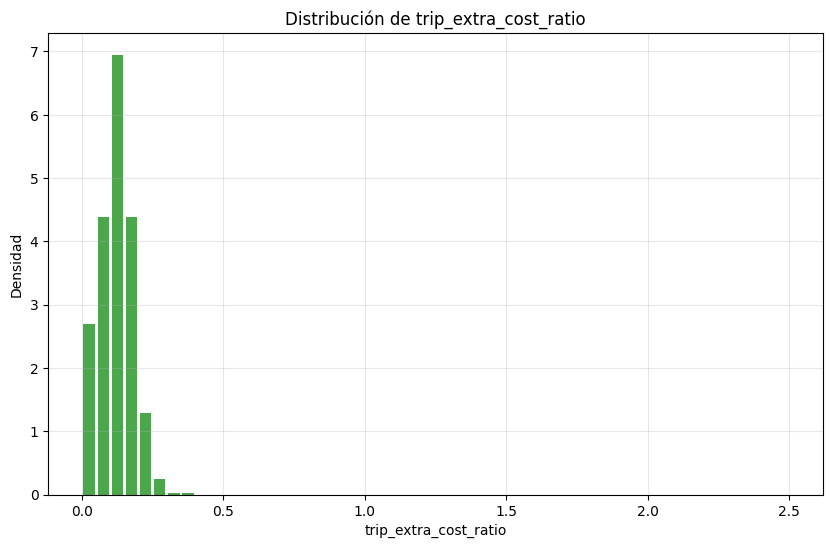

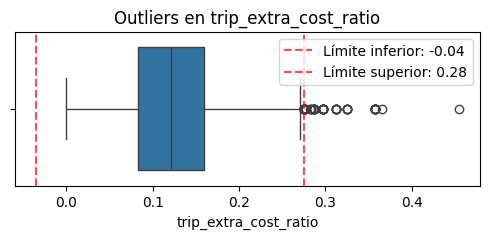

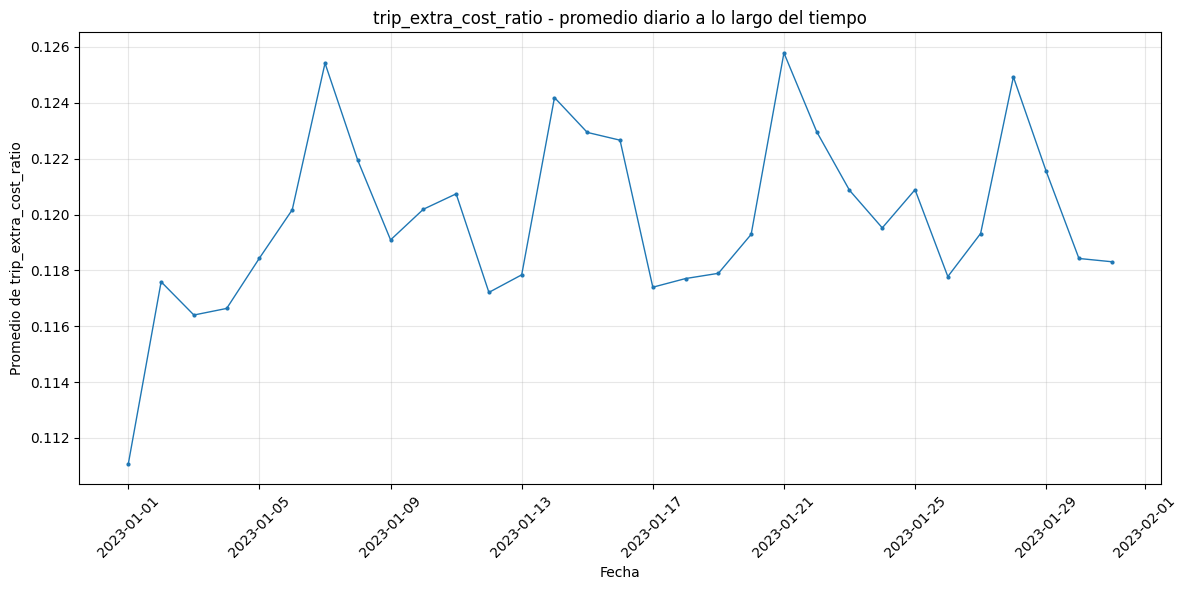

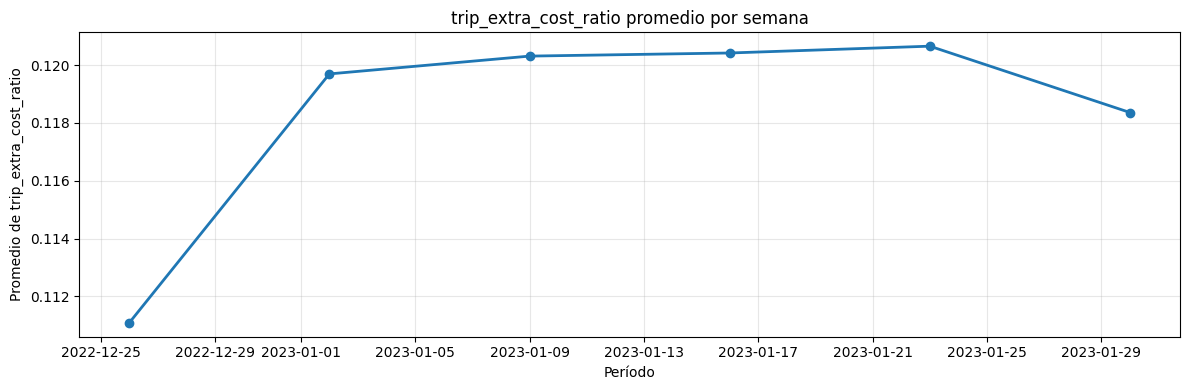

In [120]:
info = analyze_numeric_variable_spark(ds_encoded_features_v2, col_name, col_fecha)

*7.1.4) Outliers*

- tip_score

Columna: tip_score
Q1: 0.07, Q3: 0.29, IQR: 0.23
Límite superior (IQR): 0.64

Número de outliers: 10,959 (0.36%)

Percentiles de outliers:
P95: 0.40
P99: 14500.00
P99.5: 14500.00
P99.9: 14500.00

Top valores más frecuentes entre outliers:
+------------------+-----+
|tip_score         |count|
+------------------+-----+
|0.6944444444444444|449  |
|0.7692307692307693|434  |
|0.6362068965517241|413  |
|0.6818181818181818|389  |
|0.8620689655172414|335  |
|0.6823529411764706|309  |
|0.6896551724137931|305  |
|0.9803921568627452|226  |
|0.6409090909090909|200  |
|0.7843137254901962|195  |
+------------------+-----+


Generando histograma (recortado al P99)...
Registros para histograma: 3,066,715
Dataset grande, procesando en tramos...


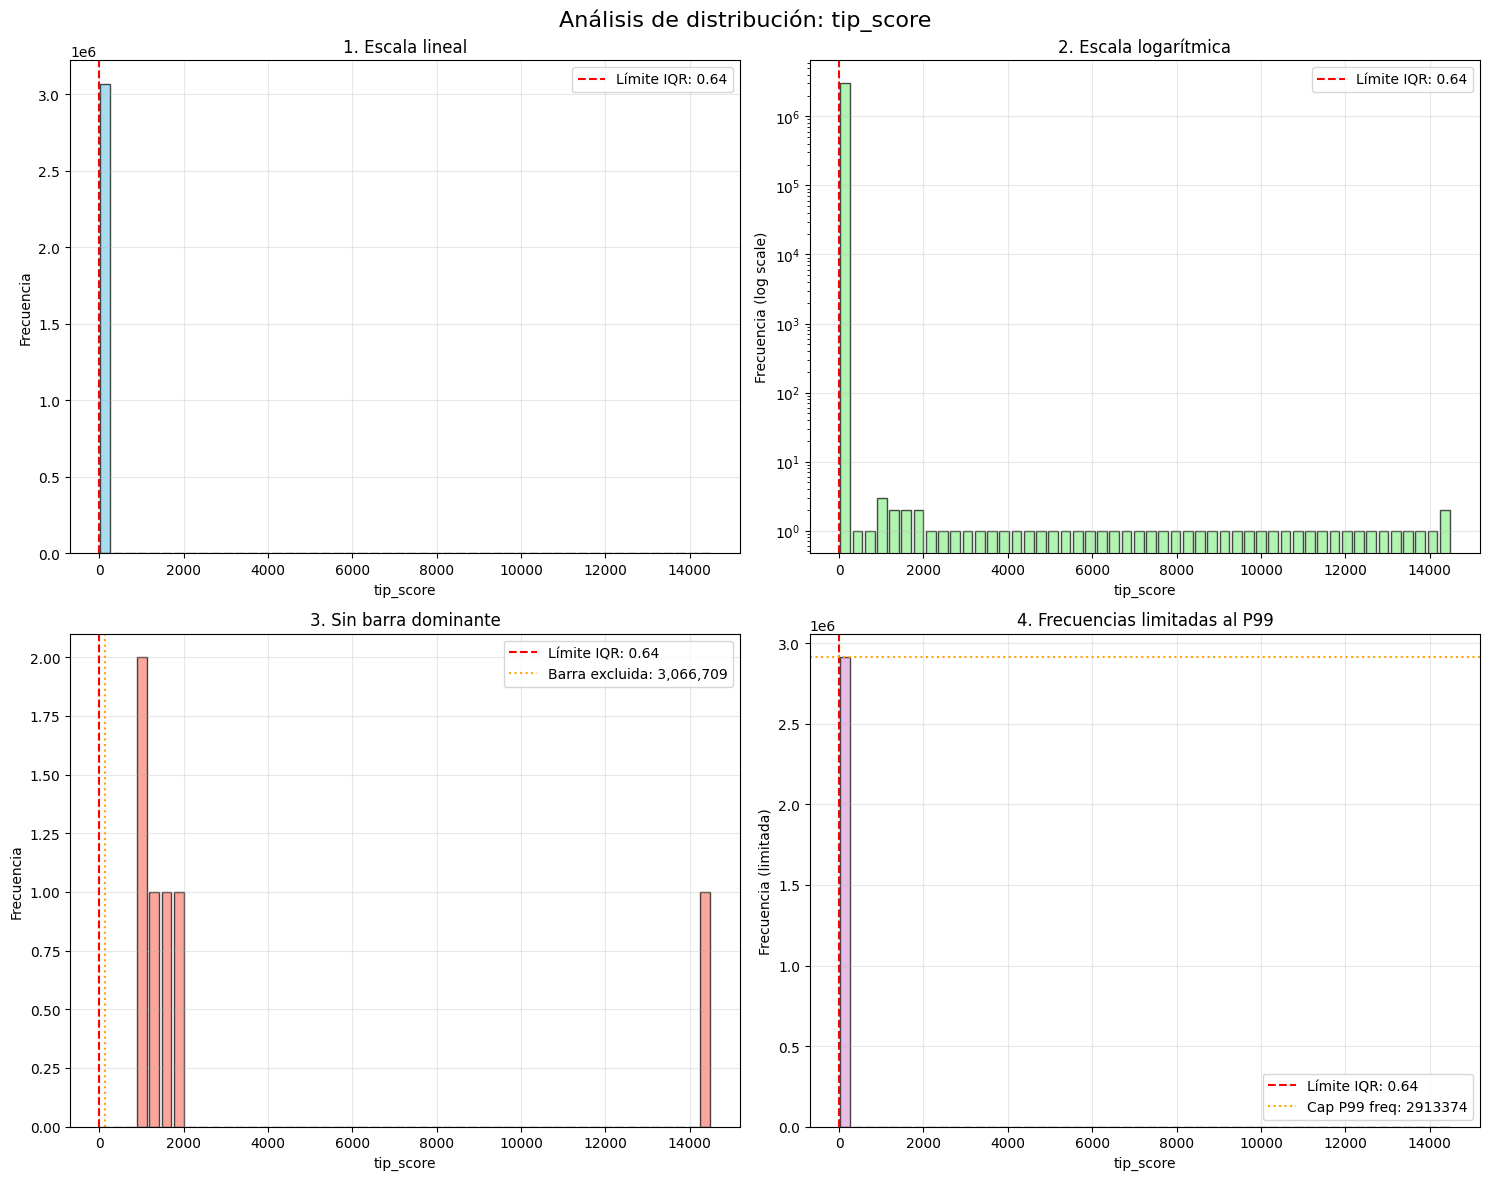


📉 Análisis de caída en histograma:
• Índice del bin con mayor caída: 0
• Frecuencia antes: 3066709, después: 0
• Caída relativa: -1.00
• Intervalo de caída: 0.00 - 290.00
• Centro del bin: 145.00

📊 Análisis de la distribución:
• Barra más alta: 3,066,709 registros (100.0%) en valor ~145.00
• Total de registros: 3,066,715
• Ratio máx/mín frecuencia: 3066709.0:1
• Bins con datos: 6/50
• Frecuencia capada al P99: 2913374

Estadísticas del histograma:
Registros procesados: 3,066,715
Valor mínimo: 0.00
Valor máximo: 14500.00
Media: 0.21


In [121]:
col_name = "tip_score"

outliers_trip_duration = show_outliers_iqr(ds_encoded_features_v2, col_name)

In [122]:
pmin = 0.95
pmax = 0.99

granular_percentile_analysis(ds_encoded_features_v2, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE tip_score

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 0.47 → 14500.00
   Multiplicador: 31071.4x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:         0.45
   P 98.3%:         0.45
   P 98.4%:         0.45
   P 98.5%:         0.45
   P 98.6%:         0.45
   P 98.7%:         0.47
   P 98.8%:         0.47
   P 98.9%:         0.47
   P 99.0%:     14500.00 ← SALTO MÁXIMO
   P 99.1%:     14500.00
   P 99.2%:     14500.00
   P 99.3%:     14500.00
   P 99.4%:     14500.00
   P 99.5%:     14500.00
   P 99.6%:     14500.00
   P 99.7%:     14500.00


- trip_extra_cost_ratio

Columna: trip_extra_cost_ratio
Q1: 0.08, Q3: 0.16, IQR: 0.08
Límite superior (IQR): 0.27

Número de outliers: 23,643 (0.77%)

Percentiles de outliers:
P95: 0.21
P99: 2.50
P99.5: 2.50
P99.9: 2.50

Top valores más frecuentes entre outliers:
+---------------------+-----+
|trip_extra_cost_ratio|count|
+---------------------+-----+
|0.27472527472527475  |9402 |
|0.2976190476190476   |5138 |
|0.35714285714285715  |2887 |
|0.3246753246753247   |2016 |
|0.3125               |1605 |
|0.2873563218390805   |1459 |
|0.2777777777777778   |147  |
|0.625                |100  |
|0.28216704288939054  |68   |
|0.28089887640449435  |46   |
+---------------------+-----+


Generando histograma (recortado al P99)...
Registros para histograma: 3,066,715
Dataset grande, procesando en tramos...


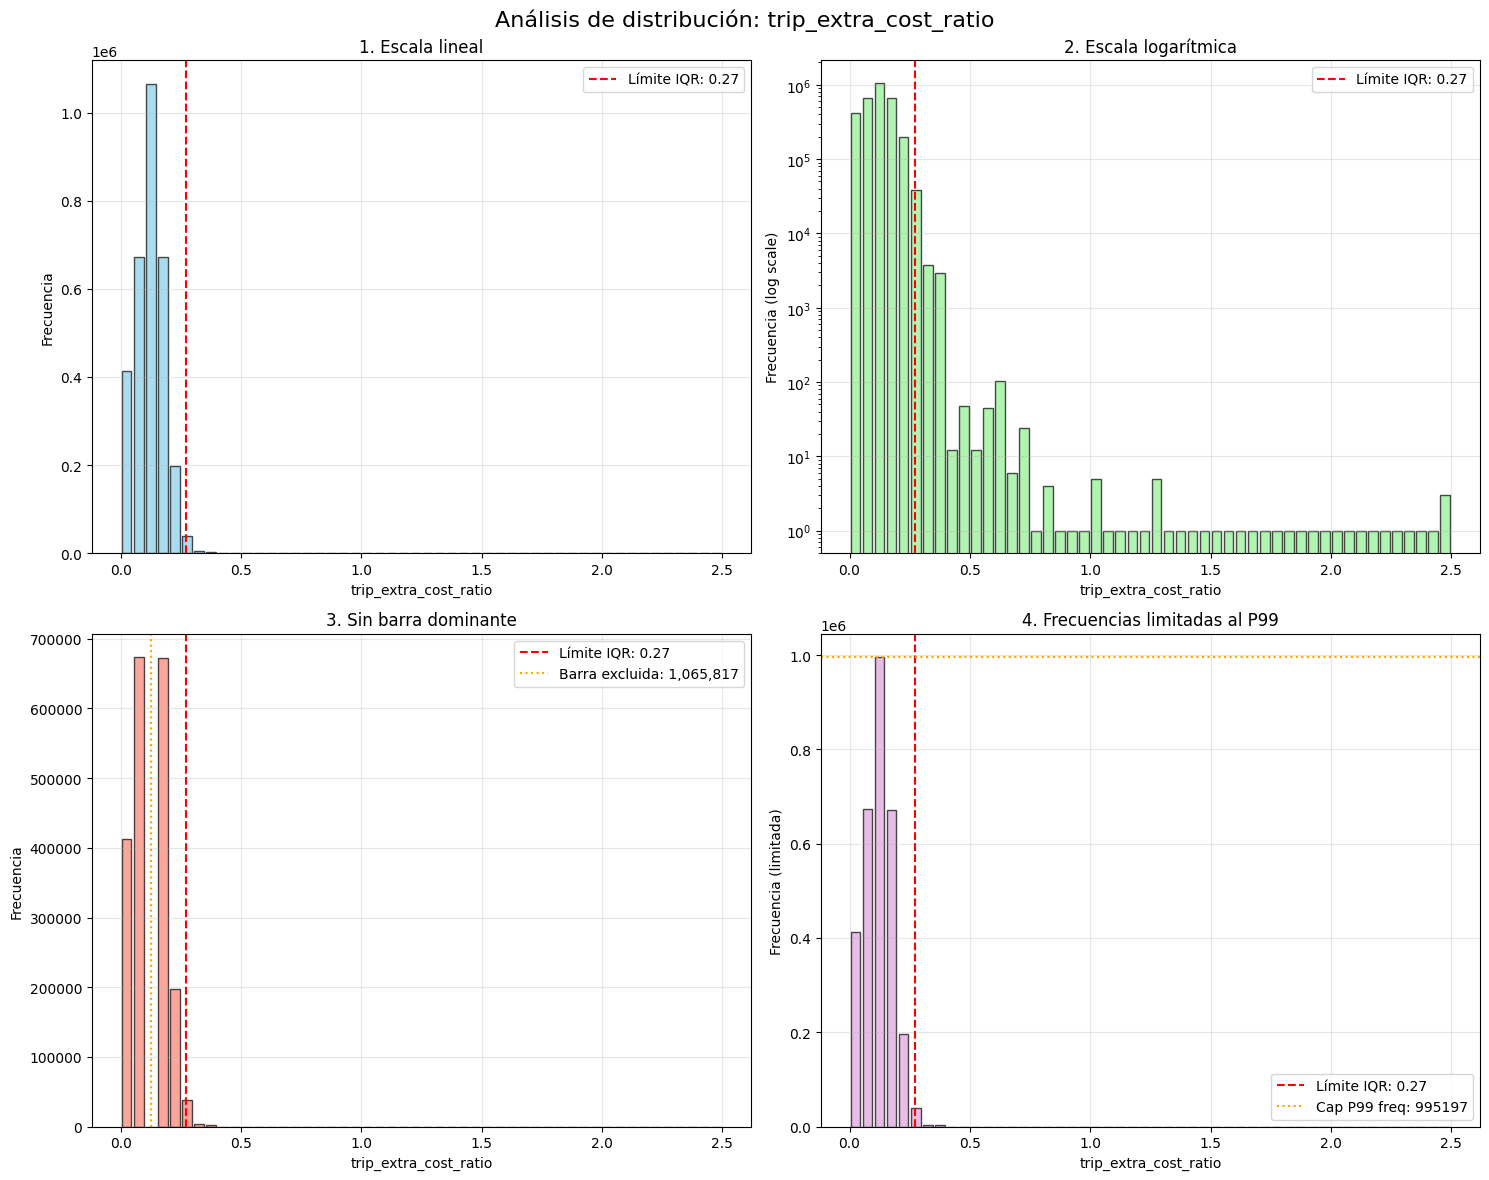


📉 Análisis de caída en histograma:
• Índice del bin con mayor caída: 14
• Frecuencia antes: 23, después: 0
• Caída relativa: -1.00
• Intervalo de caída: 0.70 - 0.75
• Centro del bin: 0.73

📊 Análisis de la distribución:
• Barra más alta: 1,065,817 registros (34.8%) en valor ~0.12
• Total de registros: 3,066,715
• Ratio máx/mín frecuencia: 532908.5:1
• Bins con datos: 19/50
• Frecuencia capada al P99: 995197

Estadísticas del histograma:
Registros procesados: 3,066,715
Valor mínimo: 0.00
Valor máximo: 2.50
Media: 0.12


In [123]:
col_name = "trip_extra_cost_ratio"

outliers_trip_duration = show_outliers_iqr(ds_encoded_features_v2, col_name)

In [124]:
pmin = 0.95
pmax = 0.99

granular_percentile_analysis(ds_encoded_features_v2, col_name, pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE trip_extra_cost_ratio

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 0.26 → 2.50
   Multiplicador: 9.8x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:         0.24
   P 98.3%:         0.24
   P 98.4%:         0.24
   P 98.5%:         0.26
   P 98.6%:         0.26
   P 98.7%:         0.26
   P 98.8%:         0.26
   P 98.9%:         0.26
   P 99.0%:         2.50 ← SALTO MÁXIMO
   P 99.1%:         2.50
   P 99.2%:         2.50
   P 99.3%:         2.50
   P 99.4%:         2.50
   P 99.5%:         2.50
   P 99.6%:         2.50
   P 99.7%:         2.50


- Imputación de outliers

In [125]:
columnas_a_imputar = [
    "tip_score",
    "trip_extra_cost_ratio"
]

umbrales_a_imputar = [
    0.47,
    0.25
]

Análisis temporal:

In [126]:
analyze_median_hourly_variation(ds_encoded_features_v2, columnas_a_imputar)

Variación de la mediana de 'tip_score':
+------------------+------------------+-------------------+-------------------+------------------------------+
|       mediana_min|       mediana_max|   mediana_promedio|    rango_variacion|factor_variacion_tanto_por_uno|
+------------------+------------------+-------------------+-------------------+------------------------------+
|0.1627906976744186|0.2531645569620253|0.23297239879106782|0.09037385928760669|           0.38791659336716083|
+------------------+------------------+-------------------+-------------------+------------------------------+

Variación de la mediana de 'trip_extra_cost_ratio':
+-------------------+-------------------+-------------------+--------------------+------------------------------+
|        mediana_min|        mediana_max|   mediana_promedio|     rango_variacion|factor_variacion_tanto_por_uno|
+-------------------+-------------------+-------------------+--------------------+------------------------------+
|0.1012145

Imputaciones:

In [127]:
ds_encoded_features_outliers_v2 = impute_columns_with_median_by_threshold(
    ds=ds_encoded_features_v2,
    columnas=columnas_a_imputar,
    umbrales=umbrales_a_imputar,
    claves_agrupacion=['PULocationID', 'DOLocationID', 'pickup_hour'],
    tipo_umbral="superior"
)


Imputación de tip_score (umbral superior: 0.47)
Registros con tip_score que exceden el umbral: 51088
Mediana global calculada: 0.23655913978494625
Imputaciones realizadas: 51088
Imputaciones usando mediana global: 423
Tasa de éxito: 100.00%

Imputación de trip_extra_cost_ratio (umbral superior: 0.25)
Registros con trip_extra_cost_ratio que exceden el umbral: 45001
Mediana global calculada: 0.11961722488038279
Imputaciones realizadas: 45001
Imputaciones usando mediana global: 69
Tasa de éxito: 100.00%


Comprobación:

In [128]:
pmin = 0.95
pmax = 0.99

granular_percentile_analysis(ds_encoded_features_outliers_v2, "tip_score_imputed", pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE tip_score_imputed

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 0.42 → 0.47
   Multiplicador: 1.1x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:         0.41
   P 98.3%:         0.41
   P 98.4%:         0.41
   P 98.5%:         0.41
   P 98.6%:         0.42
   P 98.7%:         0.42
   P 98.8%:         0.42
   P 98.9%:         0.42
   P 99.0%:         0.47 ← SALTO MÁXIMO
   P 99.1%:         0.47
   P 99.2%:         0.47
   P 99.3%:         0.47
   P 99.4%:         0.47
   P 99.5%:         0.47
   P 99.6%:         0.47
   P 99.7%:         0.47


In [129]:
pmin = 0.95
pmax = 0.99

granular_percentile_analysis(ds_encoded_features_outliers_v2, "trip_extra_cost_ratio_imputed", pmin, pmax)

ANÁLISIS DE SALTOS EN PERCENTILES - VARIABLE trip_extra_cost_ratio_imputed

Calculando ratios entre percentiles consecutivos...

🎯 MAYOR SALTO ENCONTRADO:
   Entre P98.9% y P99.0%
   De 0.23 → 0.25
   Multiplicador: 1.1x

📊 PERCENTILES ALREDEDOR DEL SALTO:
   P 98.2%:         0.22
   P 98.3%:         0.23
   P 98.4%:         0.23
   P 98.5%:         0.23
   P 98.6%:         0.23
   P 98.7%:         0.23
   P 98.8%:         0.23
   P 98.9%:         0.23
   P 99.0%:         0.25 ← SALTO MÁXIMO
   P 99.1%:         0.25
   P 99.2%:         0.25
   P 99.3%:         0.25
   P 99.4%:         0.25
   P 99.5%:         0.25
   P 99.6%:         0.25
   P 99.7%:         0.25


*7.1.5) Escalado y codificación de las nuevas variables*

In [130]:
ds_encoded_features_outliers_v2.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'ingestion_timestamp',
 'source_file',
 'passenger_count_imputed',
 'pickup_hour',
 'trip_distance_imputed',
 'extra_imputed',
 'tip_amount_imputed',
 'tolls_amount_imputed',
 'improvement_surcharge_imputed',
 'congestion_surcharge_imputed',
 'airport_fee_imputed',
 'mta_tax_imputed',
 'fare_amount_imputed',
 'total_reconstructed',
 'total_amount_imputed',
 'RatecodeID_imputed',
 'store_and_fwd_flag_imputed',
 'congestion_surcharge_imputed_v2',
 'airport_fee_imputed_v2',
 'trip_duration_minutes',
 'is_weekend',
 'average_speed_mph',
 'tip_percentage',
 'fare_per_mile',
 'extra_charges',
 'proportion_extra_charges',
 'trip_duration_minutes_imputed

- Variables numéricas

In [131]:
numeric_vars_standard = [
    "tip_score_imputed", "trip_extra_cost_ratio_imputed"
]

In [132]:
# inicializa el dataframe codificado
ds_encoded_temp = ds_encoded_features_outliers_v2

In [133]:
for var in numeric_vars_standard:

    print(f"\n=== Aplicando StandardScaler a: {var} ===\n")

    # utiliza el dataframe codificado como entrada
    ds_encoded_temp, model, new_col_name = apply_codification_spark(ds_encoded_temp, var, 'SS')
    models[f"{var}_SS"] = model


=== Aplicando StandardScaler a: tip_score_imputed ===

StandardScaler model -- mean (if present): [0.1959541381398199]
StandardScaler model -- std: [0.1299008249492068]
Value counts de la columna transformada:
+-------------------+------+
|  tip_score_encoded| count|
+-------------------+------+
|-1.5084903288061562|697349|
|  0.647000216457773| 35903|
| 0.7472555906560955| 28151|
| 0.6933548518397931| 28082|
| 0.9786141464983777| 27307|
| 0.8107083591360462| 26576|
| 0.6067106735556438| 26184|
| 0.4873342501419264| 25157|
|   0.57136896925553| 24669|
| 0.8864991659315431| 24434|
| 0.5401163877669999| 22865|
|  0.800963826833768| 21653|
| 0.5122820573787772| 21630|
| 0.4648460858720893| 17593|
|0.26319093059189985| 16074|
|0.44447090347995416| 15970|
| 0.9262830445816713| 15062|
| 1.0929637775468621| 14643|
| 0.3934130934855462| 14570|
| 0.8589071210612929| 14547|
+-------------------+------+
only showing top 20 rows

✓ Variable tip_score_imputed escalada como tip_score_encoded

=== A

- Variables booleanas

In [134]:
ds_encoded_temp.groupBy("toll_indicator").count().orderBy(desc("count")).show(20)

+--------------+-------+
|toll_indicator|  count|
+--------------+-------+
|         false|2840546|
|          true| 226169|
+--------------+-------+



In [135]:
bool_vars = [
    "toll_indicator"
]

true_values = [
    True
]

In [136]:
# inicializa el dataframe codificado
ds_encoded_v2 = ds_encoded_temp

In [137]:
for var in bool_vars:

    print(f"\n=== Aplicando codificación binaria a: {var} ===\n")

    # utiliza el dataframe codificado como entrada
    ds_encoded_v2, model, new_col_name = apply_codification_spark(
        ds_encoded_v2, var, 'BN', true_values=true_values
    )
    models[f"{var}_BN"] = model


=== Aplicando codificación binaria a: toll_indicator ===

Value counts de la columna transformada:
+----------------------+-------+
|toll_indicator_encoded|  count|
+----------------------+-------+
|                     0|2840546|
|                     1| 226169|
+----------------------+-------+

✓ Variable toll_indicator codificada como toll_indicator_encoded


In [138]:
print("=== MODELOS ENTRENADOS ===\n")
print("Modelos guardados para futuros datos:\n")

for model_name in models.keys():
    print(f"- {model_name}: {type(models[model_name])}")

print("\nTotal de modelos:", len(models))

=== MODELOS ENTRENADOS ===

Modelos guardados para futuros datos:

- PULocationID_SI: <class 'pyspark.ml.feature.StringIndexerModel'>
- DOLocationID_SI: <class 'pyspark.ml.feature.StringIndexerModel'>
- passenger_count_imputed_SI: <class 'pyspark.ml.feature.StringIndexerModel'>
- RatecodeID_imputed_SI: <class 'pyspark.ml.feature.StringIndexerModel'>
- trip_distance_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- extra_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- tip_amount_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- tolls_amount_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- improvement_surcharge_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- mta_tax_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- fare_amount_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- total_amount_imputed_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- congestion_surcharge_imputed_v2_SS: <class 'pyspark.ml.pipeline.PipelineModel'>
- a

In [139]:
# limpia la memoria
if 'ds_encoded_features_outliers_v2' in locals():
    ds_encoded_features_outliers_v2.unpersist()
if 'ds_encoded_temp' in locals():
    ds_encoded_temp.unpersist()

**7.2) Eliminación de variables**

Eliminamos del dataset todas las variables que no sirvan para calcular las correlaciones.

In [140]:
ds_encoded_v2.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'airport_fee',
 'ingestion_timestamp',
 'source_file',
 'passenger_count_imputed',
 'pickup_hour',
 'trip_distance_imputed',
 'extra_imputed',
 'tip_amount_imputed',
 'tolls_amount_imputed',
 'improvement_surcharge_imputed',
 'congestion_surcharge_imputed',
 'airport_fee_imputed',
 'mta_tax_imputed',
 'fare_amount_imputed',
 'total_reconstructed',
 'total_amount_imputed',
 'RatecodeID_imputed',
 'store_and_fwd_flag_imputed',
 'congestion_surcharge_imputed_v2',
 'airport_fee_imputed_v2',
 'trip_duration_minutes',
 'is_weekend',
 'average_speed_mph',
 'tip_percentage',
 'fare_per_mile',
 'extra_charges',
 'proportion_extra_charges',
 'trip_duration_minutes_imputed

*Variables a mantener:*

- VendorID_encoded
- PULocationID_encoded
- DOLocationID_encoded
- payment_type
- passenger_count_encoded
- pickup_hour
- pickup_hour_hour_sin
- pickup_hour_hour_cos
- RatecodeID_encoded
- store_and_fwd_flag_encoded
- is_weekend
- trip_distance_encoded
- extra_encoded
- tip_amount_encoded
- tolls_amount_encoded
- improvement_surcharge_encoded
- mta_tax_encoded
- fare_amount_encoded
- total_amount_encoded
- congestion_surcharge_encoded
- airport_fee_encoded
- trip_duration_minutes_encoded
- average_speed_mph_encoded
- tip_percentage_encoded
- fare_per_mile_encoded
- proportion_extra_charges_encoded
- tpep_pickup_datetime_day
- tpep_pickup_datetime_dayofweek
- tpep_pickup_datetime_week
- tpep_pickup_datetime_dayofweek_sin
- tpep_pickup_datetime_dayofweek_cos
- tpep_dropoff_datetime_day
- tpep_dropoff_datetime_dayofweek
- tpep_dropoff_datetime_week
- tpep_dropoff_datetime_dayofweek_sin
- tpep_dropoff_datetime_dayofweek_cos
- toll_indicator_encoded
- tip_score_encoded
- trip_extra_cost_ratio_encoded

*Variables a eliminar:*

- ingestion_timestamp
- source_file
- VendorID
- PULocationID
- DOLocationID
- passenger_count
- passenger_count_imputed
- RatecodeID
- RatecodeID_imputed
- store_and_fwd_flag
- store_and_fwd_flag_imputed
- trip_distance
- trip_distance_imputed
- extra
- extra_imputed
- tip_amount
- tip_amount_imputed
- tolls_amount
- tolls_amount_imputed
- improvement_surcharge
- improvement_surcharge_imputed
- mta_tax
- mta_tax_imputed
- fare_amount
- fare_amount_imputed
- total_amount
- total_amount_imputed
- congestion_surcharge
- congestion_surcharge_imputed
- congestion_surcharge_imputed_v2
- airport_fee
- airport_fee_imputed
- airport_fee_imputed_v2
- trip_duration_minutes
- trip_duration_minutes_imputed
- trip_duration_minutes_imputed_v2
- average_speed_mph
- average_speed_mph_imputed
- average_speed_mph_imputed_v2
- tip_percentage
- tip_percentage_imputed
- fare_per_mile
- fare_per_mile_imputed
- extra_charges
- proportion_extra_charges
- proportion_extra_charges_imputed
- tpep_pickup_datetime
- tpep_dropoff_datetime
- total_reconstructed
- toll_indicator
- tip_score
- tip_score_imputed
- trip_extra_cost_ratio
- trip_extra_cost_ratio_imputed

In [141]:
cols_a_borrar = [
    "ingestion_timestamp",
    "source_file",
    "VendorID",
    "PULocationID",
    "DOLocationID",
    "passenger_count",
    "passenger_count_imputed",
    "RatecodeID",
    "RatecodeID_imputed",
    "store_and_fwd_flag",
    "store_and_fwd_flag_imputed",
    "trip_distance",
    "trip_distance_imputed",
    "extra",
    "extra_imputed",
    "tip_amount",
    "tip_amount_imputed",
    "tolls_amount",
    "tolls_amount_imputed",
    "improvement_surcharge",
    "improvement_surcharge_imputed",
    "mta_tax",
    "mta_tax_imputed",
    "fare_amount",
    "fare_amount_imputed",
    "total_amount",
    "total_amount_imputed",
    "congestion_surcharge",
    "congestion_surcharge_imputed",
    "congestion_surcharge_imputed_v2",
    "airport_fee",
    "airport_fee_imputed",
    "airport_fee_imputed_v2",
    "trip_duration_minutes",
    "trip_duration_minutes_imputed",
    "trip_duration_minutes_imputed_v2",
    "average_speed_mph",
    "average_speed_mph_imputed",
    "average_speed_mph_imputed_v2",
    "tip_percentage",
    "tip_percentage_imputed",
    "fare_per_mile",
    "fare_per_mile_imputed",
    "extra_charges",
    "proportion_extra_charges",
    "proportion_extra_charges_imputed",
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "total_reconstructed",
    "toll_indicator",
    "tip_score",
    "tip_score_imputed",
    "trip_extra_cost_ratio",
    "trip_extra_cost_ratio_imputed"
]

In [142]:
ds_for_correlation = ds_encoded_v2.drop(*cols_a_borrar)

In [143]:
ds_for_correlation.columns

['payment_type',
 'pickup_hour',
 'is_weekend',
 'PULocationID_encoded',
 'DOLocationID_encoded',
 'passenger_count_encoded',
 'RatecodeID_encoded',
 'trip_distance_encoded',
 'extra_encoded',
 'tip_amount_encoded',
 'tolls_amount_encoded',
 'improvement_surcharge_encoded',
 'mta_tax_encoded',
 'fare_amount_encoded',
 'total_amount_encoded',
 'congestion_surcharge_encoded',
 'airport_fee_encoded',
 'trip_duration_minutes_encoded',
 'average_speed_mph_encoded',
 'tip_percentage_encoded',
 'fare_per_mile_encoded',
 'proportion_extra_charges_encoded',
 'tpep_pickup_datetime_day',
 'tpep_pickup_datetime_dayofweek',
 'tpep_pickup_datetime_week',
 'tpep_pickup_datetime_dayofweek_sin',
 'tpep_pickup_datetime_dayofweek_cos',
 'tpep_dropoff_datetime_day',
 'tpep_dropoff_datetime_dayofweek',
 'tpep_dropoff_datetime_week',
 'tpep_dropoff_datetime_dayofweek_sin',
 'tpep_dropoff_datetime_dayofweek_cos',
 'VendorID_encoded',
 'store_and_fwd_flag_encoded',
 'pickup_hour_hour_sin',
 'pickup_hour_hour_

In [144]:
print("Número de variables:", len(ds_for_correlation.columns))

Número de variables: 39


In [145]:
# limpia la memoria
if 'ds_encoded_v2' in locals():
    ds_encoded_v2.unpersist()

# **Guarda los datos**

In [146]:
dir_models = f"{SILVER_DIR}/models_202301_for_correlation_251109"
dir_dataset = f"{SILVER_DIR}/dataset_202301_for_correlation_251109"

- Modelos

In [147]:
# guarda cada modelo individualmente
save_models(models, dir_models)

Modelo PULocationID_SI guardado en /content/drive/MyDrive/taxi_project/silver/models_202301_for_correlation_251109/PULocationID_SI
Modelo DOLocationID_SI guardado en /content/drive/MyDrive/taxi_project/silver/models_202301_for_correlation_251109/DOLocationID_SI
Modelo passenger_count_imputed_SI guardado en /content/drive/MyDrive/taxi_project/silver/models_202301_for_correlation_251109/passenger_count_imputed_SI
Modelo RatecodeID_imputed_SI guardado en /content/drive/MyDrive/taxi_project/silver/models_202301_for_correlation_251109/RatecodeID_imputed_SI
Modelo trip_distance_imputed_SS guardado en /content/drive/MyDrive/taxi_project/silver/models_202301_for_correlation_251109/trip_distance_imputed_SS
Modelo extra_imputed_SS guardado en /content/drive/MyDrive/taxi_project/silver/models_202301_for_correlation_251109/extra_imputed_SS
Modelo tip_amount_imputed_SS guardado en /content/drive/MyDrive/taxi_project/silver/models_202301_for_correlation_251109/tip_amount_imputed_SS
Modelo tolls_amou

- Dataframe

In [148]:
# guarda dataframe en formato Parquet
save_parquet(ds_for_correlation, dir_dataset)

💾 Guardando DataFrame en /content/drive/MyDrive/taxi_project/silver/dataset_202301_for_correlation_251109...
📊 Registros a guardar: 3066715
✅ Dataframe guardado correctamente en /content/drive/MyDrive/taxi_project/silver/dataset_202301_for_correlation_251109


True

In [149]:
# limpia la memoria
ds_for_correlation.unpersist()

DataFrame[payment_type: bigint, pickup_hour: int, is_weekend: int, PULocationID_encoded: double, DOLocationID_encoded: double, passenger_count_encoded: double, RatecodeID_encoded: double, trip_distance_encoded: double, extra_encoded: double, tip_amount_encoded: double, tolls_amount_encoded: double, improvement_surcharge_encoded: double, mta_tax_encoded: double, fare_amount_encoded: double, total_amount_encoded: double, congestion_surcharge_encoded: double, airport_fee_encoded: double, trip_duration_minutes_encoded: double, average_speed_mph_encoded: double, tip_percentage_encoded: double, fare_per_mile_encoded: double, proportion_extra_charges_encoded: double, tpep_pickup_datetime_day: int, tpep_pickup_datetime_dayofweek: int, tpep_pickup_datetime_week: int, tpep_pickup_datetime_dayofweek_sin: double, tpep_pickup_datetime_dayofweek_cos: double, tpep_dropoff_datetime_day: int, tpep_dropoff_datetime_dayofweek: int, tpep_dropoff_datetime_week: int, tpep_dropoff_datetime_dayofweek_sin: dou

In [150]:
# cierra Spark
spark.stop()
print("🔌 Sesión Spark cerrada")

🔌 Sesión Spark cerrada
